# SNP ANALYSIS

In [1]:
import gzip
import pandas as pd
import numpy as np
import os

from multiprocessing import Pool
from matplotlib import pyplot as plt
from functools import reduce



# We use rpy2 for the prop.test and padjust in R
import rpy2
from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


from IPython.display import display, HTML

In [2]:
%load_ext rpy2.ipython

## Experiments

In [4]:
rnaseq_one_cell_exps = [
"20210607-RNAseq-1cell-cross-A",
"20210607-RNAseq-1cell-cross-B",
"20210607-RNAseq-1cell-cross-C",
"20210607-RNAseq-1cell-cross-D"]

rnaseq_two_cell_exps = [
"20210607-RNAseq-2cell-cross-A",
"20210607-RNAseq-2cell-cross-B",
"20210607-RNAseq-2cell-cross-C",
"20210607-RNAseq-2cell-cross-D"
]

rnaseq_four_cell_exps = [
"20210607-RNAseq-4cell-cross-A",
#"20210607-RNAseq-4cell-cross-B",
"20210607-RNAseq-4cell-cross-C"
]

rnaseq_eight_cell_exps = [
"20210607-RNAseq-8cell-cross-A",
"20210607-RNAseq-8cell-cross-B",
"20210607-RNAseq-8cell-cross-C",
"20210607-RNAseq-8cell-cross-D"
]

rnaseq_gv_epxs = [
"20210607-RNAseq-GV-A",
"20210607-RNAseq-GV-B",
"20210607-RNAseq-GV-C",
"20210607-RNAseq-GV-D"
]

rnaseq_mii_exps = [
"20210607-RNAseq-MII-A",
"20210607-RNAseq-MII-B",
"20210607-RNAseq-MII-C",
"20210607-RNAseq-MII-D"
]

rnaseq_all_exps = rnaseq_one_cell_exps + rnaseq_two_cell_exps + \
                  rnaseq_four_cell_exps + rnaseq_eight_cell_exps + rnaseq_gv_epxs + rnaseq_mii_exps

In [5]:
riboseq_one_cell_exps = [
"20210513-ITP-1cell-cross-50-A",
"20210513-ITP-1cell-cross-50-B",
"20210513-ITP-1cell-cross-50-C",
"20210513-ITP-1cell-cross-50-D",
"20210513-ITP-1cell-cross-50-E"]
    
riboseq_two_cell_exps = [
"20210513-ITP-2cell-cross-50-B",
"20210513-ITP-2cell-cross-50-C",
"20210513-ITP-2cell-cross-50-F",
]

riboseq_four_cell_exps = [
"20210513-ITP-4cell-cross-50-B",
"20210513-ITP-4cell-cross-50-C",
"20210513-ITP-4cell-cross-50-D",
]
    
riboseq_eigth_cell_exps = [
"20210513-ITP-8cell-cross-50-A",
"20210513-ITP-8cell-cross-50-B",
"20210513-ITP-8cell-cross-50-C",
"20210513-ITP-8cell-cross-50-D",
]
    
    
riboseq_mii_exps = [
"20210301-ITP-MII-25-B",
"20210301-ITP-MII-50-A",
"20210301-ITP-MII-50-B",
"20210318-ITP-MII-50-B",
"20210614-ITP-MII-50-A",
#"20210614-ITP-MII-50-B",
"20210614-ITP-MII-50-C",
"20210614-ITP-MII-50-D",
"20210614-ITP-MII-50-E",
"20210614-ITP-MII-50-F",
]    
    
    
riboseq_gv_epxs = [
"20210614-ITP-GV-50-A",
"20210614-ITP-GV-50-B",
"20210614-ITP-GV-50-C",
"20210614-ITP-GV-50-D",
"20210614-ITP-GV-50-E",
"20210614-ITP-GV-50-F",
]

riboseq_all_exps = riboseq_one_cell_exps  + riboseq_two_cell_exps + \
                   riboseq_four_cell_exps + riboseq_eigth_cell_exps + \
                   riboseq_mii_exps       + riboseq_gv_epxs

## prop.test from R

Here we make sure that we are running the prop.test without error.
The following example is from the documentation of prop.test.

In [6]:
proptest = robjects.r('prop.test')
smokers  = robjects.IntVector([83, 90, 129, 70])
patients = robjects.IntVector([86, 93, 136, 82])
proptest(smokers, patients)

<rpy2.robjects.vectors.ListVector object at 0x7fbfac7cf348> [RTYPES.VECSXP]
R classes: ('htest',)
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., NULLType, StrSexpVe..., StrSexpVe..., StrSexpVe...]
  statistic: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbfac7eca48> [RTYPES.REALSXP]
  parameter: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbfac7ecc88> [RTYPES.REALSXP]
  p.value: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbfac7eccc8> [RTYPES.REALSXP]
  estimate: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbfac77e948> [RTYPES.REALSXP]
  null.value: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fbfacfc0548> [RTYPES.NILSXP]
  conf.int: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fbfacfc0548> [RTYPES.NILSXP]
  alternative: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7fbfac7f2088> [RTYPES.STRSXP]
  method: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7fbfac7e98c8> [RTYPES.STRSXP]
  data.name: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7fbfac7ece48> [RTYPES.STRSXP]

In [7]:
proptest(smokers, patients)[2][0]

0.005585476661627026

In [8]:
a = proptest(smokers, patients)

In [9]:
def extract_CDS(name_str):
    """
    Returns CDS boundaries from the transcript header
    """
    
    contents = name_str.split("|")
    
    for c in contents:
        if c.startswith("CDS"):
            boundaries = c.split(":")[1].split("-")
            return (int(boundaries[0]), int(boundaries[1]))
    
    print(name_str)
    raise ValueError
    
        

In [10]:
def get_df(snp_count_file):
    """
    Reads SNP cont file into a dataframe
    """
    
    count_df         = pd.read_csv(snp_count_file, sep = "\t")
    transcript_names = list( map( lambda x: x.split("|")[4], count_df["transcript"]) )

    boundaries       = list( map(extract_CDS, count_df["transcript"])  )

    start_positions  = list( map(lambda x: x[0], boundaries ) )
    stop_positions   = list( map(lambda x: x[1], boundaries ) )

    snp_total = count_df["A"] + count_df["C"] + count_df["G"] +  count_df["T"]

    count_df["transcript"] = transcript_names
    count_df["snp_total"]  = snp_total
    count_df["CDS_start"]  = start_positions
    count_df["CDS_stop"]   = stop_positions


    count_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    
    return count_df

In [11]:
def get_ref_alt_counts(count_df):
    """
    Extracts the reference (maternal) and alternative (paternal) 
    counts from the dataframes
    """
    
    ref_count   = 0
    alt_count   = 0
    total_count = 0
    
    cds_ref_count   = 0
    cds_alt_count   = 0
    cds_total_count = 0

    for index, row in count_df.iterrows():
        total_count += row["A"] + row["C"] + row["G"] + row["T"]
        ref_count   += row[ row["REF"] ]
        alt_count   += row[ row["ALT"] ]
        
        if row["position"] >= row["CDS_start"] and\
           row["position"] <= row["CDS_stop"]:
                cds_total_count += row["A"] + row["C"] + row["G"] + row["T"]
                cds_ref_count   += row[ row["REF"] ]
                cds_alt_count   += row[ row["ALT"] ]            

        
    return {"ref_count":     ref_count,     "alt_count": alt_count,         "total_count": total_count,
            "cds_ref_count": cds_ref_count, "cds_alt_count": cds_alt_count, "cds_total_count": cds_total_count}

## RNA-Seq SNP Calls

In [12]:
rnaseq_experiment_dfs = dict()

for e in rnaseq_all_exps:
    this_file = os.path.join("snp_counts_rnaseq", e + ".tsv.gz")
    rnaseq_experiment_dfs[e] = get_df(this_file)

In [13]:
rnaseq_reference_alt_counts = dict()

with Pool(4) as p:
    rnaseq_counts_array = p.map( get_ref_alt_counts, [ rnaseq_experiment_dfs[e] for e in rnaseq_all_exps ] )
    
for i in range(len(rnaseq_all_exps)):
    rnaseq_reference_alt_counts[rnaseq_all_exps[i]] = rnaseq_counts_array[i]
    


In [14]:
# Uncomment to get the count
#for e in rnaseq_all_exps:
#    print(e)
#    print(rnaseq_reference_alt_counts[e])

In [15]:
def calculate_ref_alt_percentages(count_dict):
    ref_percentage = (count_dict["ref_count"] / count_dict["total_count"] ) * 100
    alt_percentage = (count_dict["alt_count"] / count_dict["total_count"] ) * 100
    
    cds_ref_percentage = (count_dict["cds_ref_count"] / count_dict["cds_total_count"] ) * 100
    cds_alt_percentage = (count_dict["cds_alt_count"] / count_dict["cds_total_count"] ) * 100
    
    return {"ref_percentage": ref_percentage, "alt_percentage" : alt_percentage,
           "cds_ref_percentage": cds_ref_percentage, "cds_alt_percentage" : cds_alt_percentage}

In [16]:
rnaseq_reference_alt_percentages = dict()

for e in rnaseq_all_exps:
    rnaseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(rnaseq_reference_alt_counts[e])

In [17]:
for e in rnaseq_all_exps:
    print(e)
    print("Alt: {:.1f}    Ref: {:.1f}".format( rnaseq_reference_alt_percentages[e]["cds_alt_percentage"],
                                       rnaseq_reference_alt_percentages[e]["cds_ref_percentage"]))

20210607-RNAseq-1cell-cross-A
Alt: 0.2    Ref: 99.7
20210607-RNAseq-1cell-cross-B
Alt: 0.2    Ref: 99.6
20210607-RNAseq-1cell-cross-C
Alt: 0.2    Ref: 99.6
20210607-RNAseq-1cell-cross-D
Alt: 0.2    Ref: 99.6
20210607-RNAseq-2cell-cross-A
Alt: 6.1    Ref: 93.7
20210607-RNAseq-2cell-cross-B
Alt: 5.2    Ref: 94.6
20210607-RNAseq-2cell-cross-C
Alt: 5.0    Ref: 94.8
20210607-RNAseq-2cell-cross-D
Alt: 9.0    Ref: 90.7
20210607-RNAseq-4cell-cross-A
Alt: 47.0    Ref: 52.8
20210607-RNAseq-4cell-cross-C
Alt: 48.9    Ref: 50.9
20210607-RNAseq-8cell-cross-A
Alt: 46.8    Ref: 53.1
20210607-RNAseq-8cell-cross-B
Alt: 48.5    Ref: 51.3
20210607-RNAseq-8cell-cross-C
Alt: 49.2    Ref: 50.6
20210607-RNAseq-8cell-cross-D
Alt: 48.8    Ref: 51.0
20210607-RNAseq-GV-A
Alt: 0.2    Ref: 99.7
20210607-RNAseq-GV-B
Alt: 0.2    Ref: 99.6
20210607-RNAseq-GV-C
Alt: 0.3    Ref: 99.6
20210607-RNAseq-GV-D
Alt: 0.1    Ref: 99.7
20210607-RNAseq-MII-A
Alt: 0.3    Ref: 99.5
20210607-RNAseq-MII-B
Alt: 0.2    Ref: 99.6
202106

In [18]:
# Uncomment to see the actual numbers
#for e in rnaseq_all_exps:
#    print(e)
#    print("Alt: {:.1f}    Ref: {:.1f}".format( rnaseq_reference_alt_percentages[e]["alt_percentage"],
#                                       rnaseq_reference_alt_percentages[e]["ref_percentage"]))

In [19]:
rnaseq_experiment_dfs["20210607-RNAseq-4cell-cross-C"][:5]

transcript  position REF ALT    A    C    G    T  snp_total  CDS_start  \
68514  Rps19-203       303   C   T    1  521    1  616       1139        298   
66330  Dppa3-201       290   A   C  691  403    1    0       1095        114   
4478   Rps26-201       299   C   T    0  505    0  517       1022        270   
66329  Dppa3-201       263   C   T    0  509    0  437        946        114   
23498  Rpl15-202       275   A   G  441    0  474    0        915        120   

       CDS_stop  
68514       735  
66330       566  
4478        617  
66329       566  
23498       734

## A Global Look at the SNPs

In [20]:
def get_barplot_df(percentage_df, experiments, cds = False):
    """
    If cds=True, then only SNPS comig from CDS are taken
    if cds=False
    SNPs coming from the ENTIRE transcript are taken
    """
    
    reference_alt_percentages = percentage_df
    
    percentage_dict = {"Experiment": experiments,  "Paternal": [], "Maternal": [], "Other": []}
    
    if cds:
        key_prefix = "cds_"
    else:
        key_prefix = ""
            

    for e in experiments:
        print(e)
        percentage_dict["Maternal"].append( reference_alt_percentages[e][ key_prefix + "ref_percentage"]) 
        percentage_dict["Paternal"].append( reference_alt_percentages[e][key_prefix + "alt_percentage"]) 
        other = 100 - (reference_alt_percentages[e][key_prefix + "ref_percentage"] +\
                       reference_alt_percentages[e][key_prefix + "alt_percentage"])
        percentage_dict["Other"].append(other)

        print("Alt: {:.1f}    Ref: {:.1f} Other: {:.1f}".format( \
                                           reference_alt_percentages[e][key_prefix + "alt_percentage"],
                                           reference_alt_percentages[e][key_prefix + "ref_percentage"],
                                           other                ))
    
    
    p_df = pd.DataFrame(percentage_dict, index=experiments)
    
    return p_df

In [21]:
rnaseq_cds_barplot_df = \
    get_barplot_df(percentage_df = rnaseq_reference_alt_percentages, 
                   experiments   = rnaseq_all_exps, 
                   cds           = True)

20210607-RNAseq-1cell-cross-A
Alt: 0.2    Ref: 99.7 Other: 0.2
20210607-RNAseq-1cell-cross-B
Alt: 0.2    Ref: 99.6 Other: 0.2
20210607-RNAseq-1cell-cross-C
Alt: 0.2    Ref: 99.6 Other: 0.2
20210607-RNAseq-1cell-cross-D
Alt: 0.2    Ref: 99.6 Other: 0.2
20210607-RNAseq-2cell-cross-A
Alt: 6.1    Ref: 93.7 Other: 0.2
20210607-RNAseq-2cell-cross-B
Alt: 5.2    Ref: 94.6 Other: 0.2
20210607-RNAseq-2cell-cross-C
Alt: 5.0    Ref: 94.8 Other: 0.2
20210607-RNAseq-2cell-cross-D
Alt: 9.0    Ref: 90.7 Other: 0.3
20210607-RNAseq-4cell-cross-A
Alt: 47.0    Ref: 52.8 Other: 0.2
20210607-RNAseq-4cell-cross-C
Alt: 48.9    Ref: 50.9 Other: 0.2
20210607-RNAseq-8cell-cross-A
Alt: 46.8    Ref: 53.1 Other: 0.2
20210607-RNAseq-8cell-cross-B
Alt: 48.5    Ref: 51.3 Other: 0.2
20210607-RNAseq-8cell-cross-C
Alt: 49.2    Ref: 50.6 Other: 0.2
20210607-RNAseq-8cell-cross-D
Alt: 48.8    Ref: 51.0 Other: 0.2
20210607-RNAseq-GV-A
Alt: 0.2    Ref: 99.7 Other: 0.2
20210607-RNAseq-GV-B
Alt: 0.2    Ref: 99.6 Other: 0.2
2021

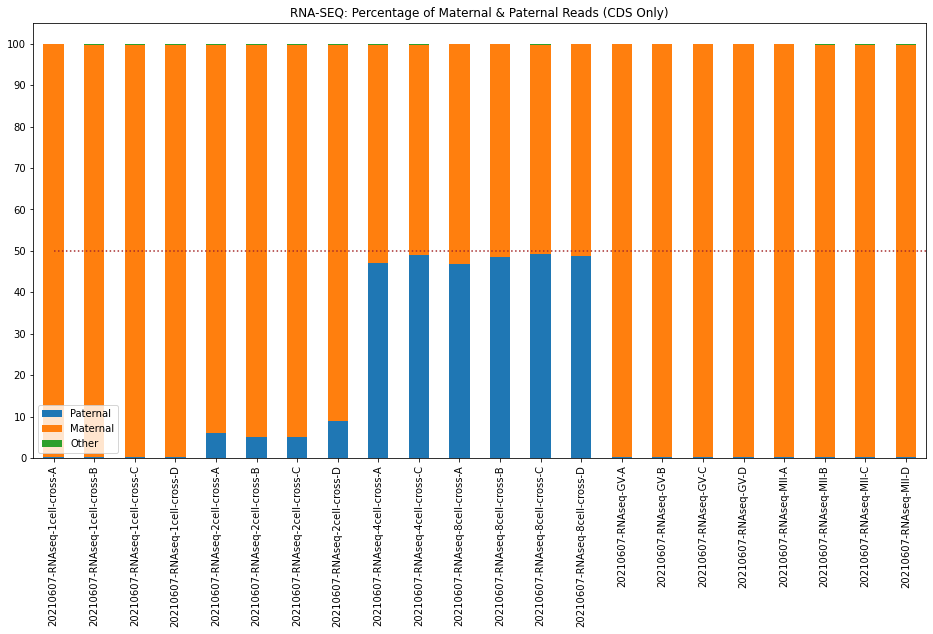

In [22]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

fig  = rnaseq_cds_barplot_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "RNA-SEQ: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(rnaseq_all_exps), linestyle=':', color="brown" )
plt.yticks(list(range(0,110, 10) ))
fig.figure.savefig("paternal_maternal_read_percentages_rnaseq_cds.pdf");

## Ribosome Profiling SNP Calls

In [23]:
riboseq_experiment_dfs = dict()

for e in riboseq_all_exps:
    this_file = os.path.join("snp_counts_riboseq", e + ".tsv.gz")
    riboseq_experiment_dfs[e] = get_df(this_file)
    

riboseq_reference_alt_counts = dict()

with Pool(4) as p:
    riboseq_counts_array = p.map( get_ref_alt_counts, [ riboseq_experiment_dfs[e] for e in riboseq_all_exps ] )
    
for i in range(len(riboseq_all_exps)):
    riboseq_reference_alt_counts[riboseq_all_exps[i]] = riboseq_counts_array[i]

riboseq_reference_alt_percentages = dict()

for e in riboseq_all_exps:
    riboseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(riboseq_reference_alt_counts[e])

In [24]:
for e in riboseq_all_exps:
    print(e)
    print("Alt: {:.1f}    Ref: {:.1f}".format( riboseq_reference_alt_percentages[e]["cds_alt_percentage"],
                                       riboseq_reference_alt_percentages[e]["cds_ref_percentage"]))

20210513-ITP-1cell-cross-50-A
Alt: 1.3    Ref: 97.0
20210513-ITP-1cell-cross-50-B
Alt: 0.9    Ref: 97.6
20210513-ITP-1cell-cross-50-C
Alt: 1.0    Ref: 96.8
20210513-ITP-1cell-cross-50-D
Alt: 1.2    Ref: 96.4
20210513-ITP-1cell-cross-50-E
Alt: 1.3    Ref: 96.0
20210513-ITP-2cell-cross-50-B
Alt: 11.8    Ref: 86.5
20210513-ITP-2cell-cross-50-C
Alt: 4.8    Ref: 93.0
20210513-ITP-2cell-cross-50-F
Alt: 7.1    Ref: 90.4
20210513-ITP-4cell-cross-50-B
Alt: 43.9    Ref: 52.7
20210513-ITP-4cell-cross-50-C
Alt: 43.5    Ref: 51.5
20210513-ITP-4cell-cross-50-D
Alt: 46.4    Ref: 51.6
20210513-ITP-8cell-cross-50-A
Alt: 46.0    Ref: 52.3
20210513-ITP-8cell-cross-50-B
Alt: 48.6    Ref: 49.6
20210513-ITP-8cell-cross-50-C
Alt: 47.6    Ref: 50.7
20210513-ITP-8cell-cross-50-D
Alt: 45.3    Ref: 52.9
20210301-ITP-MII-25-B
Alt: 1.0    Ref: 97.1
20210301-ITP-MII-50-A
Alt: 0.9    Ref: 97.8
20210301-ITP-MII-50-B
Alt: 0.8    Ref: 97.8
20210318-ITP-MII-50-B
Alt: 1.1    Ref: 97.4
20210614-ITP-MII-50-A
Alt: 1.0    Re

In [27]:
riboseq_barplot_cds_df = \
    get_barplot_df(percentage_df = riboseq_reference_alt_percentages, 
                   experiments   = riboseq_all_exps, 
                   cds           = True)

20210513-ITP-1cell-cross-50-A
Alt: 1.3    Ref: 97.0 Other: 1.8
20210513-ITP-1cell-cross-50-B
Alt: 0.9    Ref: 97.6 Other: 1.5
20210513-ITP-1cell-cross-50-C
Alt: 1.0    Ref: 96.8 Other: 2.2
20210513-ITP-1cell-cross-50-D
Alt: 1.2    Ref: 96.4 Other: 2.4
20210513-ITP-1cell-cross-50-E
Alt: 1.3    Ref: 96.0 Other: 2.6
20210513-ITP-2cell-cross-50-B
Alt: 11.8    Ref: 86.5 Other: 1.7
20210513-ITP-2cell-cross-50-C
Alt: 4.8    Ref: 93.0 Other: 2.2
20210513-ITP-2cell-cross-50-F
Alt: 7.1    Ref: 90.4 Other: 2.5
20210513-ITP-4cell-cross-50-B
Alt: 43.9    Ref: 52.7 Other: 3.4
20210513-ITP-4cell-cross-50-C
Alt: 43.5    Ref: 51.5 Other: 4.9
20210513-ITP-4cell-cross-50-D
Alt: 46.4    Ref: 51.6 Other: 2.0
20210513-ITP-8cell-cross-50-A
Alt: 46.0    Ref: 52.3 Other: 1.7
20210513-ITP-8cell-cross-50-B
Alt: 48.6    Ref: 49.6 Other: 1.7
20210513-ITP-8cell-cross-50-C
Alt: 47.6    Ref: 50.7 Other: 1.7
20210513-ITP-8cell-cross-50-D
Alt: 45.3    Ref: 52.9 Other: 1.8
20210301-ITP-MII-25-B
Alt: 1.0    Ref: 97.1 Oth

## Approximating the Error 

In GV and MII samples, we don't expect to see any reads coming from paternal genes. So, any such paternal reads are resulting from various sources of errors (e.g. mapping artifacts, sequencing or PCR errors etc.). We average the ratio of paternal reads in GV and MII samples to approximate error rate in ribosome profiling experiments in general.

In [28]:
sum_of_paternal_rates = 0

for e in riboseq_mii_exps + riboseq_gv_epxs:
    sum_of_paternal_rates += riboseq_barplot_cds_df.loc[e]["Paternal"]

ribo_error_rate = sum_of_paternal_rates / len(riboseq_mii_exps + riboseq_gv_epxs)
print("Error rate in ribosome profiling is %{:.2f}".format(ribo_error_rate))

Error rate in ribosome profiling is %1.06


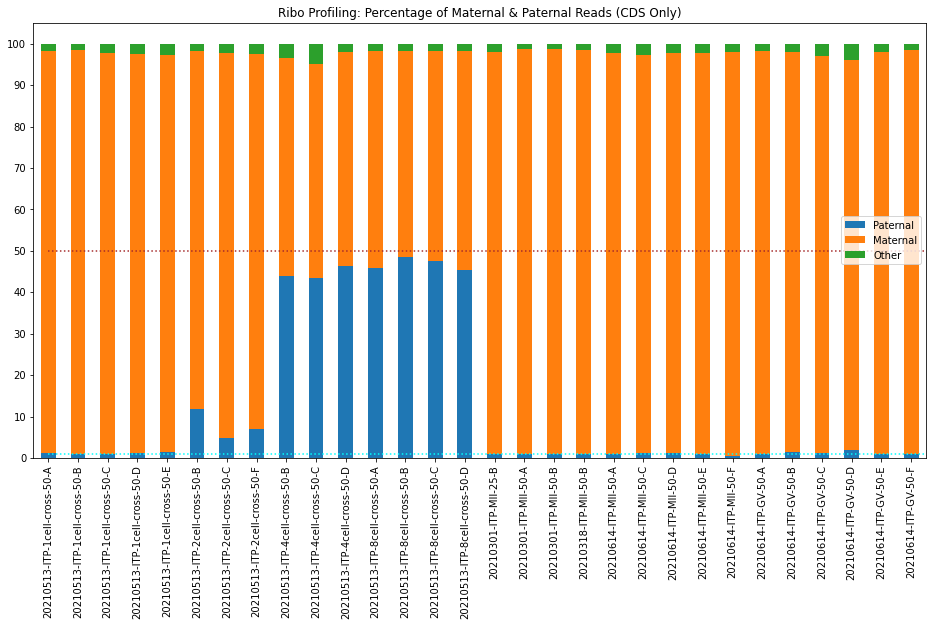

In [29]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

fig  = riboseq_barplot_cds_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "Ribo Profiling: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="brown" )
plt.hlines(1, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="cyan" )
plt.yticks(list(range(0,110, 10) ))
fig.figure.savefig("paternal_maternal_read_percentages_riboseq_cds.pdf");

## Aggregating SNP Counts

We sum SNPs accross replicates

In [30]:
def add_two_snp_dfs(df_1, df_2):
    """
    This is the helper function to add dataframes
    
    Adds two dataframes and produces one that is compatible with other SNP dataframes
    (Have the same column names)
    """
    
    index_col_name = "trans_pos"
    
    zipped_df1_transcripts_df1_positions = zip( df_1["transcript"], df_1["position"] )
    zipped_df2_transcripts_df2_positions = zip( df_2["transcript"], df_2["position"] )
    
    df1_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df1_transcripts_df1_positions ) )
    df2_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df2_transcripts_df2_positions ) )
    
    df_1_indexed = df_1.copy()
    df_2_indexed = df_2.copy()
    
    df_1_indexed[index_col_name] = df1_index_vec
    df_2_indexed[index_col_name] = df2_index_vec
    
    df_1_indexed.set_index(index_col_name, inplace = True)
    df_2_indexed.set_index(index_col_name, inplace = True)
    
    merged_df = df_1_indexed.merge( df_2_indexed, on = ["trans_pos"] )
    
    df_dict = {
        #"trnas_pos":  merged_df.index,
        "transcript": merged_df["transcript_x"],
        "position":   merged_df["position_x"],
        "REF":        merged_df["REF_x"],
        "ALT":        merged_df["ALT_x"],
        "A":          np.add(merged_df["A_x"] , merged_df["A_y"]),
        "C":          np.add(merged_df["C_x"] , merged_df["C_y"]),
        "G":          np.add(merged_df["G_x"] , merged_df["G_y"]),
        "T":          np.add(merged_df["T_x"] , merged_df["T_y"]),
        "snp_total":  np.add(merged_df["snp_total_x"] , merged_df["snp_total_y"]),
        "CDS_start":  merged_df["CDS_start_x"],
        "CDS_stop":  merged_df["CDS_stop_x"]     
    }
    
    result_df = pd.DataFrame.from_dict(df_dict)
    
    return (result_df)


##############################################################################


def add_snp_dfs(df_list):
    """
    THIS IS THE MAIN FUNCTION TO CALL!!!
    Adds a list of dataframes containing SNPS
    """
    result_df =  reduce( lambda x, y : add_two_snp_dfs(x,y), df_list  )
    result_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    return result_df

In the follwoing several cells, we do a quick sanity check for the above two functions.

In [31]:
add_two_snp_dfs( riboseq_experiment_dfs[riboseq_one_cell_exps[0]], riboseq_experiment_dfs[riboseq_one_cell_exps[1]] )

transcript  position REF ALT    A    C   G    T  \
trans_pos                                                                       
Spin1-201_848                  Spin1-201       848   C   G    0  320   2    1   
Zbed3-202_471                  Zbed3-202       471   T   C    0    0   0  217   
Zbed3-202_707                  Zbed3-202       707   A   G  218    0   0    0   
E330034G19Rik-203_257  E330034G19Rik-203       257   A   C  125    0   0    0   
Zbed3-202_320                  Zbed3-202       320   T   G    8    2  10  130   
...                                  ...       ...  ..  ..  ...  ...  ..  ...   
Gpd1-201_825                    Gpd1-201       825   T   C    0    0   0    0   
Gpd1-201_508                    Gpd1-201       508   C   T    0    0   0    0   
Gpd1-201_462                    Gpd1-201       462   C   T    0    0   0    0   
Smarcd1-201_1699             Smarcd1-201      1699   G   A    0    0   0    0   
Mid1-205_1745                   Mid1-205      1745   A   G    0    0   0    0   

                       snp_total  CDS_start  CDS_stop  
trans_pos                                              
Spin1-201_848                323        261      1049  
Zbed3-202_471                217        174       860  
Zbed3-202_707                218        174       860  
E330034G19Rik-203_257        125         56      1111  
Zbed3-202_320                150        174       860  
...                          ...        ...       ...  
Gpd1-201_825                   0         94      1143  
Gpd1-201_508                   0         94      1143  
Gpd1-201_462                   0         94      1143  
Smarcd1-201_1699               0        194      1741  
Mid1-205_1745                  0        345      2387  

[85339 rows x 11 columns]

In [32]:
riboseq_experiment_dfs[riboseq_one_cell_exps[1]]

transcript  position REF ALT    A    C   G   T  snp_total  CDS_start  \
21047     Spin1-201       848   C   G    0  181   2   1        184        261   
22358     Zbed3-202       707   A   G  118    0   0   0        118        174   
22356     Zbed3-202       471   T   C    0    0   0  93         93        174   
22354     Zbed3-202       320   T   G    4    2   6  78         90        174   
83783  AU022751-201       452   G   C    3    1  64   0         68         98   
...             ...       ...  ..  ..  ...  ...  ..  ..        ...        ...   
29009      Gpd1-201       825   T   C    0    0   0   0          0         94   
29008      Gpd1-201       508   C   T    0    0   0   0          0         94   
29007      Gpd1-201       462   C   T    0    0   0   0          0         94   
29006   Smarcd1-201      1699   G   A    0    0   0   0          0        194   
85338      Mid1-205      1745   A   G    0    0   0   0          0        345   

       CDS_stop  
21047      1049  
22358       860  
22356       860  
22354       860  
83783      1504  
...         ...  
29009      1143  
29008      1143  
29007      1143  
29006      1741  
85338      2387  

[85339 rows x 11 columns]

In [33]:
add_snp_dfs( (riboseq_experiment_dfs[riboseq_one_cell_exps[0]], 
              riboseq_experiment_dfs[riboseq_one_cell_exps[1]])  )

transcript  position REF ALT    A    C   G    T  \
trans_pos                                                                       
Spin1-201_848                  Spin1-201       848   C   G    0  320   2    1   
Zbed3-202_707                  Zbed3-202       707   A   G  218    0   0    0   
Zbed3-202_471                  Zbed3-202       471   T   C    0    0   0  217   
Zbed3-202_320                  Zbed3-202       320   T   G    8    2  10  130   
E330034G19Rik-203_257  E330034G19Rik-203       257   A   C  125    0   0    0   
...                                  ...       ...  ..  ..  ...  ...  ..  ...   
Itga11-201_2659               Itga11-201      2659   G   A    0    0   0    0   
Itga11-201_2966               Itga11-201      2966   C   T    0    0   0    0   
Itga11-201_3035               Itga11-201      3035   A   C    0    0   0    0   
Cln6-201_128                    Cln6-201       128   T   C    0    0   0    0   
Mid1-205_1745                   Mid1-205      1745   A   G    0    0   0    0   

                       snp_total  CDS_start  CDS_stop  
trans_pos                                              
Spin1-201_848                323        261      1049  
Zbed3-202_707                218        174       860  
Zbed3-202_471                217        174       860  
Zbed3-202_320                150        174       860  
E330034G19Rik-203_257        125         56      1111  
...                          ...        ...       ...  
Itga11-201_2659                0        120      3686  
Itga11-201_2966                0        120      3686  
Itga11-201_3035                0        120      3686  
Cln6-201_128                   0         97      1023  
Mid1-205_1745                  0        345      2387  

[85339 rows x 11 columns]

In [34]:
riboseq_snp_total_one_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_one_cell_exps] )
riboseq_snp_total_two_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_two_cell_exps] )
riboseq_snp_total_four_cell  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_four_cell_exps] )
riboseq_snp_total_eight_cell = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_eigth_cell_exps] )


riboseq_snp_total_mii = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_mii_exps] )
riboseq_snp_total_gv  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_gv_epxs] )


In [35]:
rnaseq_snp_total_one_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_one_cell_exps] )
rnaseq_snp_total_two_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_two_cell_exps] )
rnaseq_snp_total_four_cell  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_four_cell_exps] )
rnaseq_snp_total_eight_cell = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_eight_cell_exps] )


rnaseq_snp_total_mii = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_mii_exps] )
rnaseq_snp_total_gv  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_gv_epxs] )

We add the paternal / maternal counts ratios to our dataframes

In [36]:
def find_maternal_ratio(snp_df):
    maternal_ratios      = list()
    maternal_count       = list()
    paternal_count       = list()
    mat_pat_count        = list()
    
    for i, e in snp_df.iterrows():
        
        maternal_nuc  = e["REF"]
        paternal_nuc  = e["ALT"]
        mat_pat_total = e[maternal_nuc] + e[paternal_nuc]
        
        # Avoid division by 0
        if mat_pat_total == 0:
            mat_pat_total = 1
            
        maternal_ratio = e[maternal_nuc] / mat_pat_total
        
        mat_pat_count.append(mat_pat_total)
        maternal_ratios.append(maternal_ratio)
        maternal_count.append(e[maternal_nuc])
        paternal_count.append(e[paternal_nuc])
        
    snp_df["maternal_count"] = maternal_count 
    snp_df["paternal_count"] = paternal_count 
    snp_df["mat_pat_total"]  = mat_pat_count 
    snp_df["maternal_ratio"] = maternal_ratios
    
    

In [37]:
find_maternal_ratio( riboseq_snp_total_one_cell )
find_maternal_ratio( riboseq_snp_total_two_cell ) 
find_maternal_ratio( riboseq_snp_total_four_cell ) 
find_maternal_ratio( riboseq_snp_total_eight_cell )

find_maternal_ratio( riboseq_snp_total_mii )
find_maternal_ratio( riboseq_snp_total_gv ) 

In [38]:
find_maternal_ratio( rnaseq_snp_total_one_cell )
find_maternal_ratio( rnaseq_snp_total_two_cell ) 
find_maternal_ratio( rnaseq_snp_total_four_cell ) 
find_maternal_ratio( rnaseq_snp_total_eight_cell ) 

find_maternal_ratio( rnaseq_snp_total_mii )
find_maternal_ratio( rnaseq_snp_total_gv )

## Proportionality Test

In R
```
prop.test( paternal, total )
```

Note that the above test tells us whether `paternal_ribo / total_ribo` is significantly different than
`paternal_rna / total_rna`.

In [39]:
def perform_prop_test(df_1, df_2, error_threshold = 0.01):
    """
    Decide whether paternal  ratios differ between df_1 and df_2
    """
    
    pvalues        = []
    conf_midpoints = []

    merged_df = df_1.merge(df_2, on = "trans_pos")
    
    for i, e in merged_df.iterrows():
        #print(i, e)
        
        # Mark insufficient counts with p-val 10 and exclude them from the test
        if (e["maternal_count_x"]+ e["paternal_count_x"]) < 10  or\
           (e["maternal_count_y"] + e["paternal_count_y"]) < 10 :
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
        
        
        if e["maternal_count_x"]+ e["maternal_count_y"] == 0 or\
           e["paternal_count_x"] + e["paternal_count_y"] == 0 :
            
            #print("detected zero at", i)
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
            
        if e["paternal_count_x"] <=2 and e["paternal_count_y"] <= 2:
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
        
        r_paternal_counts = robjects.IntVector([ e["paternal_count_x"], e["paternal_count_y"] ])
        r_total_counts    = robjects.IntVector([ e["paternal_count_x"] + e["maternal_count_x"], 
                                                 e["paternal_count_y"] + e["maternal_count_y"] ])
        
        proptest_result = proptest(r_paternal_counts, r_total_counts)
        result_dict     = dict(proptest_result.items())
        conf_int        = result_dict["conf.int"]
        mid_point_conf  = (conf_int[0] + conf_int[1]) / 2
        
        
        if conf_int[1] < 0 and error_threshold > ((-1) * conf_int[1]):
            this_p_val = 5
        elif conf_int[1] >=0 and (error_threshold > conf_int[0]):
            this_p_val = 5
        else:
            this_p_val = proptest_result[2][0]
        
        
        pvalues.append(this_p_val)
        conf_midpoints.append(mid_point_conf)

        
    result_dict = { #"trans_pos" : merged_df["trans_pos"],
                    "p_val":      pvalues,
                    "conf_mid":   conf_midpoints,
                    "maternal_x": merged_df["maternal_count_x"],
                    "paternal_x": merged_df["paternal_count_x"],
                    "maternal_y": merged_df["maternal_count_y"],
                    "paternal_y": merged_df["paternal_count_y"]}
    
    
    
    result_df =  pd.DataFrame.from_dict( result_dict )
    
    return result_df

## Transcript Level SNPs

We aggregate paternal & paternal counts of transcripts. Next, we determine transcripts chaning behavior ( in terms of paternal / maternal ratio). 

In [40]:
def get_transcript_level_counts(snp_df):
    result_dict = {}
    
    for g in snp_df["transcript"]:
        result_dict[g] = { "transcript": g, "maternal_count": 0, "paternal_count": 0 }
        #result_dict[g] = { "maternal_count": 0, "paternal_count": 0 }
        
    for i, e in snp_df.iterrows():
        
        g = e["transcript"]
        
        result_dict[g]["maternal_count"] += e["maternal_count"] 
        result_dict[g]["paternal_count"] += e["paternal_count"]
        
    result_df = pd.DataFrame.from_dict( result_dict ).transpose()
    result_df.index.rename("trans_pos", inplace = True)

    
    return result_df

In [41]:
riboseq_t_level_snp_total_gv         = get_transcript_level_counts(riboseq_snp_total_gv)
riboseq_t_level_snp_total_mii        = get_transcript_level_counts(riboseq_snp_total_mii )
riboseq_t_level_snp_total_one_cell   = get_transcript_level_counts(riboseq_snp_total_one_cell )
riboseq_t_level_snp_total_two_cell   = get_transcript_level_counts(riboseq_snp_total_two_cell )
riboseq_t_level_snp_total_four_cell  = get_transcript_level_counts(riboseq_snp_total_four_cell )
riboseq_t_level_snp_total_eight_cell = get_transcript_level_counts(riboseq_snp_total_eight_cell )


In [42]:
rnaseq_t_level_snp_total_mii        = get_transcript_level_counts(rnaseq_snp_total_mii )
rnaseq_t_level_snp_total_gv         = get_transcript_level_counts(rnaseq_snp_total_gv )
rnaseq_t_level_snp_total_one_cell   = get_transcript_level_counts(rnaseq_snp_total_one_cell )
rnaseq_t_level_snp_total_two_cell   = get_transcript_level_counts(rnaseq_snp_total_two_cell )
rnaseq_t_level_snp_total_four_cell  = get_transcript_level_counts(rnaseq_snp_total_four_cell )
rnaseq_t_level_snp_total_eight_cell = get_transcript_level_counts(rnaseq_snp_total_eight_cell )


### Perform PropTest

In [43]:
proptest_error_threshold = 0.05

proptest_t_level_gv_ribo_rna         = perform_prop_test( riboseq_t_level_snp_total_gv, 
                                                          rnaseq_t_level_snp_total_gv,
                                                          error_threshold = proptest_error_threshold)

proptest_t_level_mii_ribo_rna        = perform_prop_test( riboseq_t_level_snp_total_mii, 
                                                          rnaseq_t_level_snp_total_mii,
                                                          error_threshold = proptest_error_threshold)

proptest_t_level_one_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_one_cell, 
                                                          rnaseq_t_level_snp_total_one_cell,
                                                          error_threshold = proptest_error_threshold)

proptest_t_level_two_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_two_cell, 
                                                          rnaseq_t_level_snp_total_two_cell,
                                                          error_threshold = proptest_error_threshold)

proptest_t_level_four_cell_ribo_rna  = perform_prop_test( riboseq_t_level_snp_total_four_cell, 
                                                          rnaseq_t_level_snp_total_four_cell,
                                                          error_threshold = proptest_error_threshold)

proptest_t_level_eight_cell_ribo_rna = perform_prop_test( riboseq_t_level_snp_total_eight_cell, 
                                                          rnaseq_t_level_snp_total_eight_cell,
                                                          error_threshold = proptest_error_threshold)

In [44]:
proptest_t_level_four_cell_ribo_rna.sort_values("p_val")[:5]

p_val  conf_mid maternal_x paternal_x maternal_y paternal_y
trans_pos                                                                
Nin-202    0.000324 -0.389946         25          7         36         56
Rps11-201  0.000987  0.217296         16         47       1435       1610
Mrps9-201  0.001033 -0.608108         10          0         29         45
Rpl28-201  0.001153  0.523810          0         12        132        120
Eif3d-201  0.001333 -0.536232         11          1         35         57

## A closer look at the midpoints of confidence Intervals

We take a closer look at the midpoints of the 95% confidence intervals coming from prop test. Note that this interval is for the difference between the difference of the proportions of paternal and maternal ratios.

**NOTE**:
Red vertical bars are drawn at (+-)0.01 and yellos vertical bars are drawn at (+-)0.05

In [45]:
plt.rcParams["figure.figsize"] = (15,5)

def plot_midpoint_hist(prop_test_res_df, title = ""):
    this_df = prop_test_res_df
    mid_points = this_df[this_df["p_val"] < 10]["conf_mid"]
    mid_points.plot.hist(bins = 100)
    plt.vlines([-0.01, 0.01], ymin=0, ymax=10, color = "red")
    plt.vlines([-0.05, 0.05], ymin=0, ymax=10, color = "orange")
    plt.title(title)

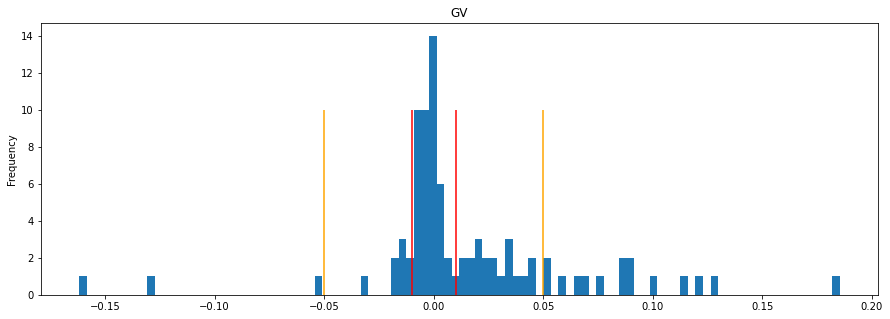

In [46]:
plot_midpoint_hist(proptest_t_level_gv_ribo_rna, title = "GV")


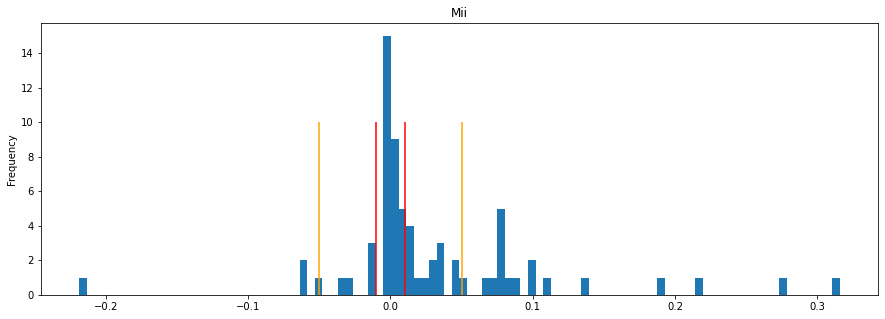

In [47]:
plot_midpoint_hist(proptest_t_level_mii_ribo_rna, title = "Mii")

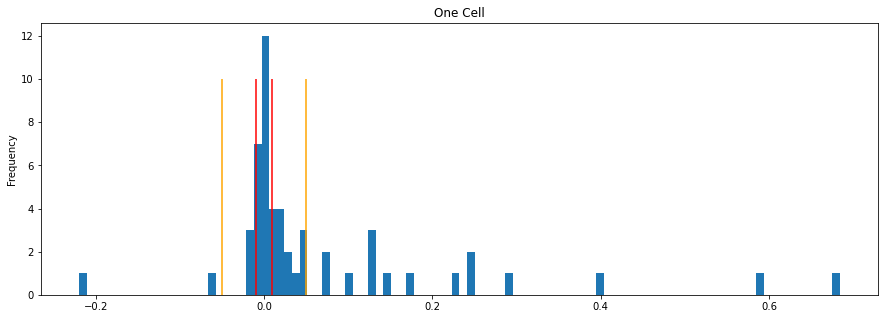

In [48]:
plot_midpoint_hist(proptest_t_level_one_cell_ribo_rna, title = "One Cell")

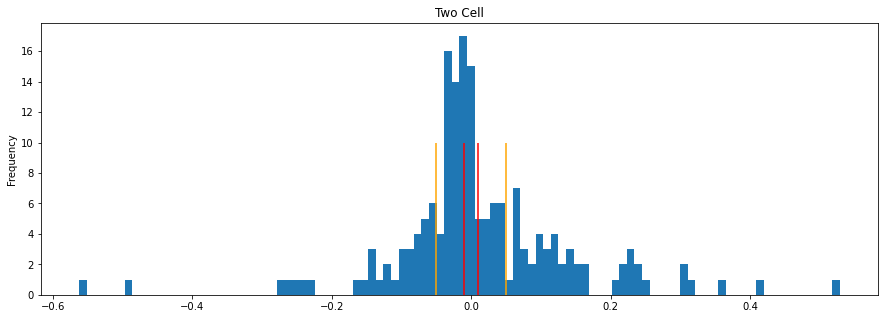

In [49]:
plot_midpoint_hist(proptest_t_level_two_cell_ribo_rna, title = "Two Cell")

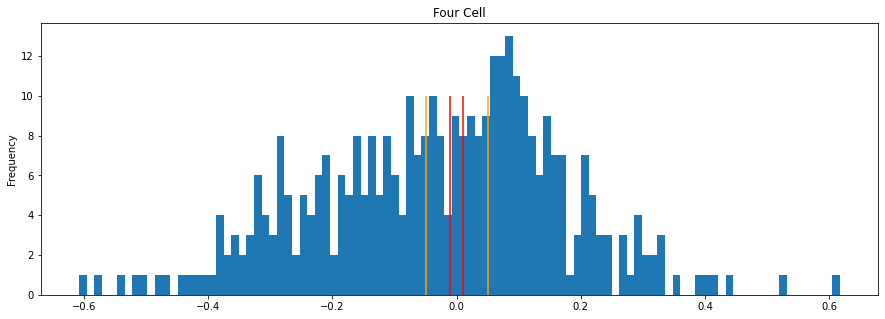

In [50]:
plot_midpoint_hist(proptest_t_level_four_cell_ribo_rna, title = "Four Cell")

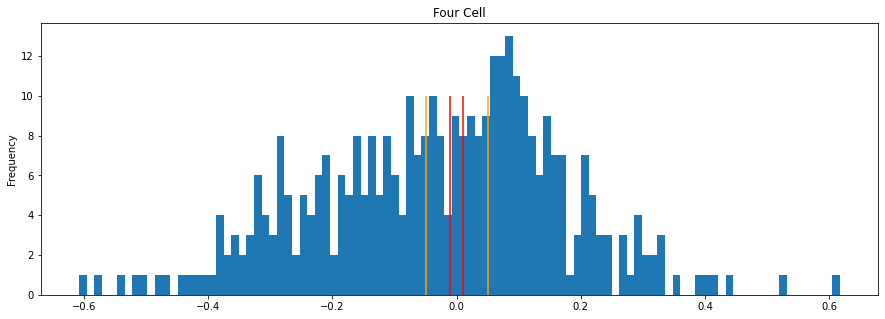

In [51]:
plot_midpoint_hist(proptest_t_level_four_cell_ribo_rna, title = "Four Cell")

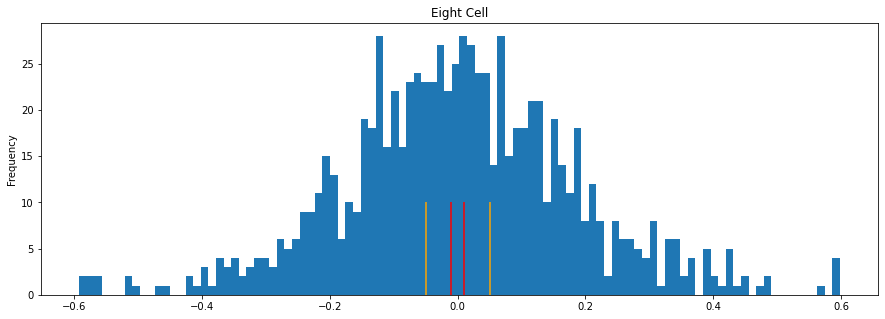

In [52]:
plot_midpoint_hist(proptest_t_level_eight_cell_ribo_rna, title = "Eight Cell")

## Filtering PropTest Results

We exclude the proptest results where the confidence interval of the diffrence between the ribo and rna ratios is below a certain threshold (see below number). These values are marked with the p-value 5 in the result tables.

We also add the FDR value to the results.

In [53]:
print("Proptest error threshold is : {}".format(proptest_error_threshold))

Proptest error threshold is : 0.05


In [54]:
padjust = robjects.r("p.adjust")


def filter_and_padjust_proptest_results( input_df , threshold = 2 ):
    
    #result_df = input_df[t_index]
    # exclude obvious cases marked with p values >= 5
    result_df = input_df[ input_df["p_val"] < 5 ]
    
    result_df = result_df[ np.logical_not(np.isclose(result_df["p_val"] , 1) ) ]
    
    
    
    p_values         = robjects.FloatVector( result_df["p_val"] )
    r_fdr_values     = padjust( p_values, method = "fdr" )
    result_df["fdr"] = [float(x) for x in r_fdr_values] 
    
    
    return result_df

In [55]:

filtered_proptest_t_level_gv_ribo_rna         = filter_and_padjust_proptest_results(proptest_t_level_gv_ribo_rna)
filtered_proptest_t_level_mii_ribo_rna        = filter_and_padjust_proptest_results(proptest_t_level_mii_ribo_rna)
filtered_proptest_t_level_one_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_one_cell_ribo_rna)
filtered_proptest_t_level_two_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_two_cell_ribo_rna)
filtered_proptest_t_level_four_cell_ribo_rna  = filter_and_padjust_proptest_results(proptest_t_level_four_cell_ribo_rna)
filtered_proptest_t_level_eight_cell_ribo_rna = filter_and_padjust_proptest_results(proptest_t_level_eight_cell_ribo_rna)

### MII

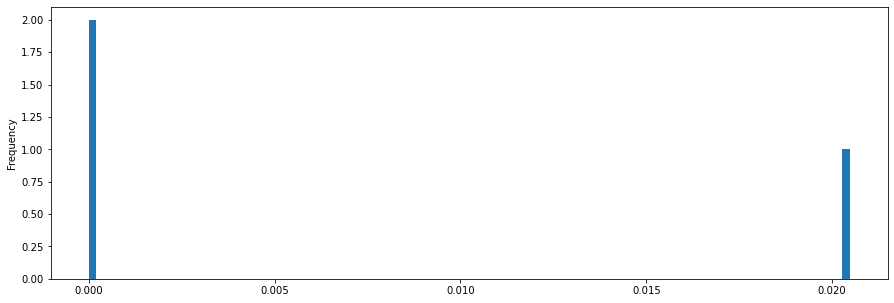

In [56]:
filtered_proptest_t_level_mii_ribo_rna["p_val"].plot.hist(bins=100);

In [57]:
filtered_proptest_t_level_mii_ribo_rna.sort_values(by="fdr")

p_val  conf_mid maternal_x paternal_x maternal_y  \
trans_pos                                                             
Ccdc47-201  8.201531e-13  0.315789         13          6        191   
Bmi1-201    1.374721e-04  0.276552         20         18        448   
Fbxw16-201  2.046744e-02 -0.218750         24          0        375   

           paternal_y           fdr  
trans_pos                            
Ccdc47-201          0  2.460459e-12  
Bmi1-201          110  2.062082e-04  
Fbxw16-201        105  2.046744e-02

### GV

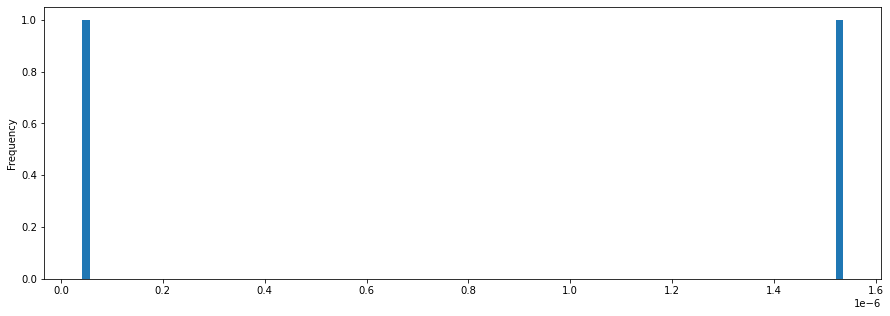

In [58]:
filtered_proptest_t_level_gv_ribo_rna["p_val"].plot.hist(bins=100);

In [59]:
filtered_proptest_t_level_gv_ribo_rna.sort_values(by="fdr")

p_val  conf_mid maternal_x paternal_x maternal_y  \
trans_pos                                                             
Fbxw16-201  4.168897e-08 -0.129962        220          1       1300   
Oas1d-201   1.536170e-06 -0.161958        145          4        739   

           paternal_y           fdr  
trans_pos                            
Fbxw16-201        202  8.337794e-08  
Oas1d-201         172  1.536170e-06

In [60]:
interesting_genes = dict()
FDR_THRESHOLD     = 0.05

### One Cell

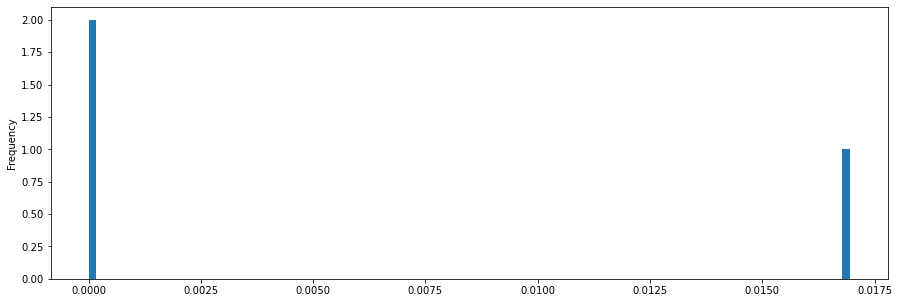

In [61]:
filtered_proptest_t_level_one_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [62]:
one_cell_selected_entries = filtered_proptest_t_level_one_cell_ribo_rna[\
                                        filtered_proptest_t_level_one_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                            .sort_values(by="fdr")
one_cell_selected_entries

p_val  conf_mid maternal_x paternal_x maternal_y  \
trans_pos                                                             
Ccdc47-201  2.139852e-22  0.684211          6         13        139   
Rpa1-202    1.104555e-14  0.591667          6          9        119   
Fbxw16-201  1.694371e-02 -0.219858         25          0        440   

           paternal_y           fdr  
trans_pos                            
Ccdc47-201          0  6.419556e-22  
Rpa1-202            1  1.656832e-14  
Fbxw16-201        124  1.694371e-02

In [63]:
interesting_genes[1] = list( one_cell_selected_entries.index )

### Two Cell

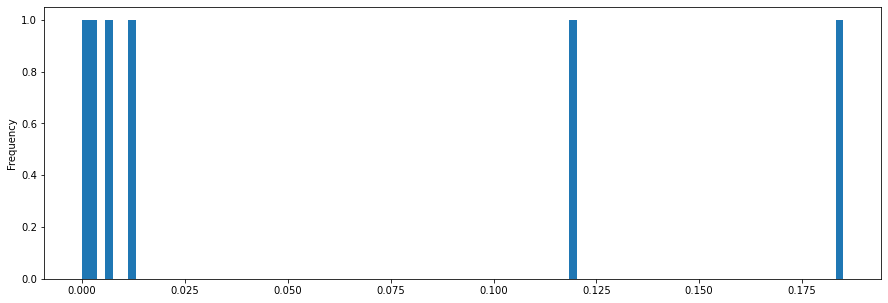

In [64]:

filtered_proptest_t_level_two_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [65]:
two_cell_selected_entries = filtered_proptest_t_level_two_cell_ribo_rna[\
                                filtered_proptest_t_level_two_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                   .sort_values(by="fdr")

two_cell_selected_entries

p_val  conf_mid maternal_x paternal_x maternal_y  \
trans_pos                                                             
Bmi1-201    1.906544e-09  0.417111         14         16        365   
Dyrk3-201   2.345179e-03  0.528571          1         13         21   
Zfp296-201  6.274671e-03 -0.493274         10          0        113   
Riok2-201   1.209329e-02 -0.562500         10          0          7   

           paternal_y           fdr  
trans_pos                            
Bmi1-201           48  1.143926e-08  
Dyrk3-201          14  7.035536e-03  
Zfp296-201        110  1.254934e-02  
Riok2-201           9  1.813993e-02

In [66]:
interesting_genes[2] = list(two_cell_selected_entries.index)

### Four Cell

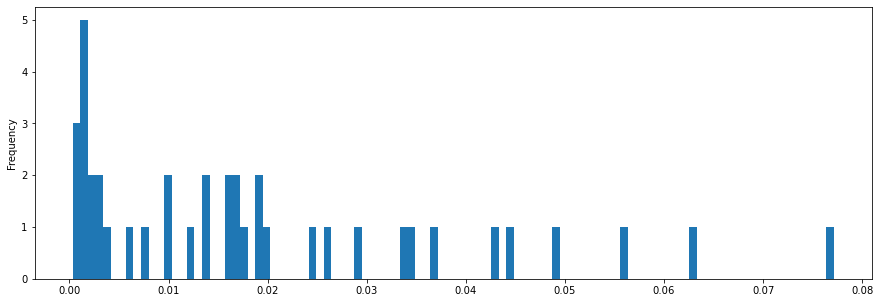

In [67]:
filtered_proptest_t_level_four_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [68]:
four_cell_selected_entries = filtered_proptest_t_level_four_cell_ribo_rna[filtered_proptest_t_level_four_cell_ribo_rna["fdr"] < FDR_THRESHOLD].sort_values(by="fdr")
four_cell_selected_entries

p_val  conf_mid maternal_x paternal_x maternal_y paternal_y  \
trans_pos                                                                     
Rps11-201    0.000987  0.217296         16         47       1435       1610   
Eif3d-201    0.001333 -0.536232         11          1         35         57   
Nin-202      0.000324 -0.389946         25          7         36         56   
Mysm1-201    0.001368 -0.507463         14          0         33         34   
Tsr1-201     0.001518 -0.435294         12          5         23         62   
Mrps9-201    0.001033 -0.608108         10          0         29         45   
Ddx21-201    0.001371 -0.438462         18          2         30         35   
Rpl28-201    0.001153  0.523810          0         12        132        120   
Baz1a-205    0.002120  0.399351          6         22         27         17   
Ncoa3-201    0.002457  0.617424          7         17         10          1   
Ctsa-202     0.002717 -0.403922         16          1        137        118   
Cdc42-202    0.003053 -0.575758         10          1         11         22   
Brca2-201    0.003691  0.210131         25         43        130         95   
Folr1-204    0.005778 -0.281210         25          5        143        116   
Znhit3-201   0.007602 -0.473422         10          0        634        570   
Ccnb1-201    0.009552 -0.284504         21          6        110        113   
Rpl26-206    0.010202 -0.334615         15          3        389        391   
Sgo2a-201    0.013525 -0.521739         10          0         11         12   
Rps19-203    0.013634  0.223607          8         27        955       1157   
Tpx2-206     0.012513 -0.301003         18          8         36         56   
Cdk1-201     0.017182  0.330808          4         14         73         59   
Naalad2-204  0.017494  0.416364          4          7         39         11   
Rnpep-202    0.016104 -0.466667         13          0          8          7   
Pa2g4-202    0.016444 -0.358543         15          2         33         30   
Pemt-202     0.016529 -0.287287         15          7        101        155   
Cct6a-201    0.019225  0.265873          7         21         65         61   
Dctd-203     0.019910 -0.387013         10          4         18         37   
Spdl1-201    0.019320  0.283052          1         22         16         33   
Rps6-201     0.024521 -0.269916         15          6        659        824   
Nup155-201   0.026033 -0.329365         18          3         19         17   
Eef1b2-204   0.029420 -0.325681         13          4         36         46   
Eif3g-201    0.034256 -0.359107         10          2         92        102   
Polr1e-204   0.033953 -0.364286         11          1         58         47   
Eif4b-201    0.037040 -0.324113         13          2         51         43   
Isyna1-204   0.042673 -0.371580          9          2         46         57   
Ltv1-201     0.044263 -0.377387          9          1        104         95   

                  fdr  
trans_pos              
Rps11-201    0.007591  
Eif3d-201    0.007591  
Nin-202      0.007591  
Mysm1-201    0.007591  
Tsr1-201     0.007591  
Mrps9-201    0.007591  
Ddx21-201    0.007591  
Rpl28-201    0.007591  
Baz1a-205    0.009424  
Ncoa3-201    0.009829  
Ctsa-202     0.009880  
Cdc42-202    0.010176  
Brca2-201    0.011358  
Folr1-204    0.016509  
Znhit3-201   0.020272  
Ccnb1-201    0.023879  
Rpl26-206    0.024005  
Sgo2a-201    0.027267  
Rps19-203    0.027267  
Tpx2-206     0.027267  
Cdk1-201     0.027991  
Naalad2-204  0.027991  
Rnpep-202    0.027991  
Pa2g4-202    0.027991  
Pemt-202     0.027991  
Cct6a-201    0.028443  
Dctd-203     0.028443  
Spdl1-201    0.028443  
Rps6-201     0.033822  
Nup155-201   0.034711  
Eef1b2-204   0.037961  
Eif3g-201    0.041523  
Polr1e-204   0.041523  
Eif4b-201    0.043576  
Isyna1-204   0.048769  
Ltv1-201     0.049181

In [69]:
interesting_genes[4] = list( four_cell_selected_entries.index )
len(interesting_genes[4])

36

### Eight Cell

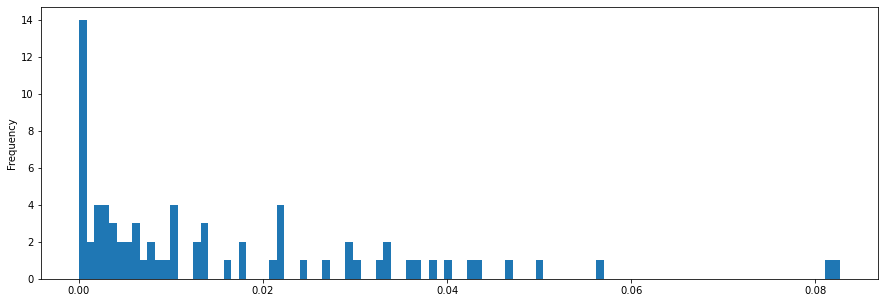

In [70]:
filtered_proptest_t_level_eight_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [71]:
eight_cell_selected_entries = filtered_proptest_t_level_eight_cell_ribo_rna[\
                                filtered_proptest_t_level_eight_cell_ribo_rna["fdr"] < FDR_THRESHOLD].sort_values(by="fdr")
eight_cell_selected_entries[:60]

p_val  conf_mid maternal_x paternal_x maternal_y  \
trans_pos                                                               
Idh3g-201     4.362811e-27  0.476190         11         10        263   
Slc6a8-203    4.547391e-09  0.490291          5          5        102   
Wtap-203      3.107707e-08 -0.588235         10          7          0   
Ddx3x-201     4.302610e-07  0.592593         11         16         36   
Slc13a2-201   1.577287e-06  0.597254          2         21         52   
Huwe1-201     1.931803e-05  0.363636         14          8         54   
Tsen2-201     3.159634e-05  0.437388          6         37         30   
Lclat1-201    4.065614e-05 -0.313866         50         18         59   
Tmppe-201     4.159355e-05  0.598333          9         16         23   
Klhdc4-201    3.788086e-04 -0.592593         11          0         88   
Cbx3-201      4.278249e-04 -0.571429         12          2         14   
Snrnp70-201   5.165444e-04 -0.513761         15          0         53   
Tgoln1-201    6.596874e-04  0.597561          0         11         49   
Ddb1-201      6.184726e-04 -0.369774         32          9         23   
Nop14-201     1.128998e-03  0.423802          4         15         85   
Rps11-201     1.248285e-03  0.133739         49        105       4258   
Lyar-201      1.835485e-03 -0.456446         11          3         54   
Stip1-201     1.794463e-03 -0.157261         78         34        764   
Rpl38-203     1.994033e-03  0.152969         44         67       1992   
Noc2l-201     2.137808e-03  0.186930         31         53        293   
Atp6v0a4-202  2.687626e-03  0.421827          4         15         43   
Ppp2ca-201    2.668354e-03 -0.566667          9          1         19   
Pgd-201       2.622569e-03  0.284848         12         23        145   
Ctsc-201      3.187105e-03  0.334788          6         16        582   
Ankrd10-201   3.850397e-03  0.254175         14         24        259   
Mrto4-201     4.098263e-03  0.308098          7         18        504   
Srpk1-204     4.040395e-03 -0.520588          8          2         19   
Ccnh-201      4.343495e-03  0.487923          0         11        101   
Bcat1-201     4.778928e-03 -0.284600         26          1        116   
Ccar1-201     5.448865e-03  0.399123          4         12         74   
Scaf4-201     5.775498e-03 -0.566667         11          1          7   
Sdf4-201      5.931010e-03 -0.386525         15          0        173   
Ulk1-201      6.432458e-03 -0.422427         17          4         12   
Dnmt1-201     6.377474e-03  0.431034          0         14         25   
Actr5-201     6.999724e-03  0.334169          6         15        106   
Umps-201      7.680440e-03 -0.362353         15          2        156   
Mtf1-201      7.632363e-03  0.444177          2          9        236   
Rtf2-201      9.038972e-03  0.305882          7         14        326   
Atp13a3-202   9.737718e-03 -0.200402         46         14         94   
Atg7-201      1.009203e-02  0.369253          2         14         86   
Cth-201       9.963117e-03  0.204136          8         38        155   
Ppat-202      1.069580e-02 -0.260258         29         12         38   
Plk1-201      1.066146e-02  0.309845          5         17        123   
Eprs-201      1.244281e-02 -0.277586         19          7        121   
Znrf2-201     1.319640e-02 -0.402894         10          3         37   
Gmnn-201      1.329048e-02 -0.399177         12          0        146   
Wdr48-201     1.385258e-02 -0.501684         10          1         11   
Ddx52-201     1.390258e-02 -0.352339         12          4         68   
Wdr73-201     1.616744e-02 -0.350000         14          1        119   
Rpn2-202      1.756018e-02  0.419808          2          9         74   
Rpl28-201     1.794266e-02  0.229245          8         24        381   
Gtf3c5-201    2.122644e-02  0.366071          2         12         57   
Card6-201     2.212854e-02 -0.569231          8          2          3   
Zfc3h1

In [72]:
interesting_genes[8] = list( eight_cell_selected_entries.index )

In [73]:
set_of_interesting_genes = set(interesting_genes[1] + interesting_genes[2] + interesting_genes[4] + interesting_genes[8])

In [74]:
len(set_of_interesting_genes)

112

### Test Input Sizes

We print the number of genes that go into the proptest as input

In [75]:
test_sizes = dict()

test_sizes["Mii"]        = len(proptest_t_level_mii_ribo_rna[ proptest_t_level_mii_ribo_rna["p_val"] < 10 ] )
test_sizes[1]   = len(proptest_t_level_one_cell_ribo_rna[ proptest_t_level_one_cell_ribo_rna["p_val"] < 10 ])
test_sizes[2]   = len(proptest_t_level_two_cell_ribo_rna[ proptest_t_level_two_cell_ribo_rna["p_val"] < 10 ] )
test_sizes[4]  = len(proptest_t_level_four_cell_ribo_rna[ proptest_t_level_four_cell_ribo_rna["p_val"] < 10 ] )
test_sizes[8] = len(proptest_t_level_eight_cell_ribo_rna[ proptest_t_level_eight_cell_ribo_rna["p_val"] < 10 ] )

for k,v in interesting_genes.items():
    print("{} Cell: {} tested and {} found significant.".format(k, test_sizes[k], len(v)) )


1 Cell: 53 tested and 3 found significant.
2 Cell: 173 tested and 4 found significant.
4 Cell: 362 tested and 36 found significant.
8 Cell: 850 tested and 71 found significant.


Note that we further refine this selection by excluding genes with paternal trnaslation or expression at mii. This clears genes coming from 1 cell stage as well.

In [76]:

ribo_transcript_snp_count_dfs = [riboseq_t_level_snp_total_gv, riboseq_t_level_snp_total_mii, 
                            riboseq_t_level_snp_total_one_cell, riboseq_t_level_snp_total_two_cell,
                            riboseq_t_level_snp_total_four_cell, riboseq_t_level_snp_total_eight_cell]

rna_transcript_snp_count_dfs = [rnaseq_t_level_snp_total_gv, rnaseq_t_level_snp_total_mii,
                                rnaseq_t_level_snp_total_one_cell, rnaseq_t_level_snp_total_two_cell,
                                rnaseq_t_level_snp_total_four_cell, rnaseq_t_level_snp_total_eight_cell]


def get_transcript_ratios(transcript):

    prefix = "paternal"
    ribo_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"] ) for x in ribo_transcript_snp_count_dfs ]
    prefix = "maternal"
    ribo_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in ribo_transcript_snp_count_dfs ]

    # Avoid division by 0
    #for i ,v in enumerate(ribo_maternal_counts):
    #    if v == 0:
    #        ribo_maternal_counts[i] = 1
    
    prefix = "paternal"
    rna_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]
    prefix = "maternal"
    rna_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]

    # Avoid division by 0
    #for i , v in enumerate(rna_maternal_counts):
    #    if v == 0:
    #        rna_maternal_counts[i] = 1
    
    ribo_ratios = np.divide( ribo_paternal_counts, ribo_maternal_counts )
    rna_ratios  = np.divide( rna_paternal_counts, rna_maternal_counts )
    
    ribo_total_ratios = np.divide( ribo_paternal_counts, np.add( ribo_paternal_counts , ribo_maternal_counts ) )
    rna_total_ratios  = np.divide( rna_paternal_counts, np.add( rna_paternal_counts , rna_maternal_counts ) )
    ####!!!!!
    # Remove pseodo count from maternals if paternal / total visuals look good
    
    result_dict = {
        "ribo_ratios"          : ribo_total_ratios,
        "rna_ratios"           : rna_total_ratios,
        #"ribo_ratios"          : ribo_ratios,
        #"rna_ratios"           : rna_ratios,
        #"ribo_total_ratios"    : ribo_total_ratios,
        #"rna_total_ratios"     : rna_total_ratios,
        "ribo_paternal_counts" : ribo_paternal_counts,
        "ribo_maternal_counts" : ribo_maternal_counts,
        "rna_paternal_counts"  : rna_paternal_counts,
        "rna_maternal_counts"  : rna_maternal_counts
    }
    
    return( result_dict )


In [77]:

def _plot_ratios( snp_ratio_and_counts, title = "Some Title" ):
    """
    Helper Function:
    Plots paternal / maternal ratios for ribosome profiling and RNA-Seq 
    Also, annotates the data points with the actual counts of the form (paternal, maternal)
    """

    fig, ax = plt.subplots()
    
    ax.plot(snp_ratio_and_counts["ribo_ratios"] , "o", color = "blue", label = "ribo")
    ax.plot(snp_ratio_and_counts["rna_ratios"] , "^", color = "orange", label = "rna")
    
    xpos = list(range(6))
    
    for i in range(6):
        ax.annotate( "{}, {}".format(snp_ratio_and_counts["ribo_paternal_counts"][i],
                                     snp_ratio_and_counts["ribo_maternal_counts"][i]) , 
                    (i, snp_ratio_and_counts["ribo_ratios"][i]),
                    textcoords="offset points",
                    xytext=(20,5),
                    ha = "center",
                   color = "blue")
        
        ax.annotate( "{}, {}".format(snp_ratio_and_counts["rna_paternal_counts"][i],
                                     snp_ratio_and_counts["rna_maternal_counts"][i]) , 
                    (i, snp_ratio_and_counts["rna_ratios"][i]),
                    textcoords="offset points",
                    xytext=(-20,5),
                    ha = "center",
                   color = "orange")

    #ax.legend(loc='upper right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    
    plt.title(title)
    plt.ylabel("paternal / paternal + maternal")
    plt.xlabel("Stage")

    #ax.set_ylim(bottom = min_val, top = max_val)

    plt.xticks(ticks = [0,1,2,3,4,5], labels = ["gv", "m2", "1", "2", "4", "8"])
    plt.show()
    plt.close()
    return fig

In [78]:
def plot_transcript_ratios(transcript):
    """
    Helper Function:
    Plots paternal / maternal ratios for ribosome profiling and RNA-Seq 
    Also, annotates the data points with the actual counts of the form (paternal, maternal)
    """
    
    snp_ratio_and_counts = get_transcript_ratios(transcript)
    return _plot_ratios( snp_ratio_and_counts, title = transcript )

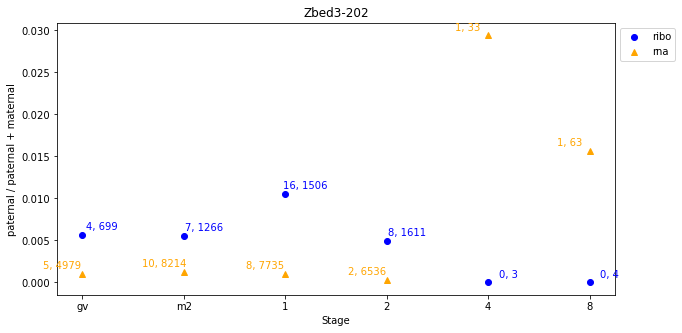

In [79]:
# Sample Plot
plt.rcParams["figure.figsize"] = (10,5)


plot_transcript_ratios(transcript = "Zbed3-202");

In [80]:
def get_mat_pat_snp_counts_from_df( this_df, transcript):
    res_df = this_df.loc[ this_df["transcript"] == transcript ]
    res_df = res_df[ ["maternal_count", "paternal_count"] ]
    return  res_df

def display_transcript_snps(transcript):
    my_ribo_dfs = { "1 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_one_cell, transcript),
                    "2 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_two_cell, transcript),
                    "4 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_four_cell, transcript),
                    "8 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_eight_cell, transcript),
                  }
    
    my_rna_dfs =  { "1 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_one_cell, transcript),
                    "2 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_two_cell, transcript),
                    "4 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_four_cell, transcript),
                    "8 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_eight_cell, transcript),
                  }
    
    for k in my_ribo_dfs.keys():
        this_df = my_ribo_dfs[k].merge(my_rna_dfs[k], on="trans_pos", suffixes=("_ribo", "_rna"))
        display(HTML("<center>{}</center>".format(k)))
        display( HTML(this_df.to_html() ) )
        

In [81]:
def get_brief_transcript_info(transcript):
    print(transcript)
    display( plot_transcript_ratios(transcript) )
    display_transcript_snps(transcript)
    return 0

## PropTest Results: Raw

In [82]:
#mini_genes = 
exp_types  = ["mii", "1", "2", "4", "8"] 

df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["ribo_ratios"][i+1]
        
ribo_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()
ribo_ratios_df.to_csv("./raw_proptest_ribo_ratios.csv")

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


In [83]:
exp_types  = ["mii", "1", "2", "4", "8"] 

df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["rna_ratios"][i+1]
        
rna_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()
rna_ratios_df.to_csv("./raw_proptest_rna_ratios.csv")

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


In [84]:
pseudo_count = 0.1
ribo_to_rna_ratios = (ribo_ratios_df + pseudo_count) / ((rna_ratios_df ) + pseudo_count)
ribo_to_rna_ratios.to_csv("./raw_proptest_ribo_to_rna_ratios.csv")
ribo_to_rna_ratios

Ddb1-201  Ncoa3-201  Atp6v0a4-202  Rps11-201  Terf1-203  Mysm1-201  \
mii  1.300000   1.000000      1.000000   0.802956   1.000000   1.000000   
1    1.086957   1.000000           NaN        NaN   1.000000   0.852941   
2    0.906542   0.746835      0.782609   2.499617        NaN   0.591837   
4    1.166667   4.234127      2.250000   1.345608   1.896552   0.164619   
8    0.463541   1.070393      1.902019   1.206363   1.486493   0.586313   

     Ccar1-201  Rnpep-202  Tprn-201  Ctsa-202  ...  Cbx3-201  Ltv1-201  \
mii   1.000000   0.948187  1.000000       NaN  ...       NaN  1.000000   
1     1.000000   1.000000  1.000000       NaN  ...       NaN  1.000000   
2          NaN   1.000000  4.636364  1.620155  ...       NaN  3.142857   
4     1.240683   0.176471  1.628571  0.282230  ...  0.398844  0.346388   
8     1.885214   1.165094  1.629310  0.972948  ...  0.298246  1.228035   

     Gmnn-201  Wdr48-201  Eif3d-201  Srpk1-204  Brca2-201  Rtf2-201  \
mii  1.000000   1.000000   1.000000   1.000000   1.212766  1.000000   
1    0.975550   1.000000        NaN   1.000000   1.121951  1.000000   
2    0.595469   1.000000        NaN   1.000000   1.367294  0.557522   
4    0.752322   1.714286   0.254783   0.516408   1.402378  0.629033   
8    0.200330   0.275644   1.014168   0.365591   0.940077  1.663830   

     Atp13a3-202  Spdl1-201  
mii     1.000000   1.000000  
1       1.000000   1.000000  
2       0.424779   1.085825  
4       0.887204   1.365952  
8       0.624530   1.081511  

[5 rows x 112 columns]

## Refining Gene Selection:

We exclude the genes having paternal reads at the MII stage.

In [85]:
mii_proptest_at_interesting_genes = proptest_t_level_mii_ribo_rna.loc[set_of_interesting_genes]

genes_with_paternal_reads_in_mii = \
    set(mii_proptest_at_interesting_genes[ \
            np.logical_or(mii_proptest_at_interesting_genes["paternal_x"] > 0, 
                          mii_proptest_at_interesting_genes["paternal_y"] > 0) ].index)

refined_gene_selection = list(\
                              set(set_of_interesting_genes).difference(genes_with_paternal_reads_in_mii)
                             )

print("There are {} genes excluded".format(len(refined_gene_selection)))

There are 80 genes excluded


In [86]:
# Uncomment to plot excluded genes
#for g in genes_with_paternal_reads_in_mii:
#    plot_transcript_ratios(g);

In [87]:
refined_ribo_ratios_df        = ribo_ratios_df[refined_gene_selection]
refined_rna_ratios_df         = rna_ratios_df[refined_gene_selection]
refined_ribo_to_rna_ratios_df = ribo_to_rna_ratios[ refined_gene_selection ]

refined_ribo_ratios_df.to_csv("./refined_ribo_ratios.csv")
refined_rna_ratios_df.to_csv("./refined_rna_ratios.csv")
refined_ribo_to_rna_ratios_df.to_csv("./refined_ribo_to_rna_ratios.csv")

In [88]:
refined_ribo_ratios_df

Actr5-201  Ddx52-201  Rpl26-206  Lclat1-201  Rpn2-202  Nop14-201  \
mii   0.000000        NaN        NaN         NaN  0.000000   0.000000   
1          NaN        NaN        NaN         NaN       NaN   0.000000   
2     0.000000        NaN   1.000000         NaN       NaN   0.500000   
4     0.100000   0.666667   0.166667    0.488372  1.000000   0.833333   
8     0.714286   0.250000   0.420000    0.264706  0.818182   0.789474   

     Atp6v0a4-202  Ncoa3-201  Tnpo3-201  Terf1-203  ...  Slc6a8-203  Rtf2-201  \
mii      0.000000   0.000000        NaN   0.000000  ...         NaN  0.000000   
1             NaN   0.000000        NaN   0.000000  ...         NaN  0.000000   
2        0.000000   0.000000   0.000000        NaN  ...         NaN  0.000000   
4        1.000000   0.708333   0.000000   1.000000  ...         0.0  0.230769   
8        0.789474   0.571429   0.083333   0.857143  ...         0.5  0.666667   

     Bcat1-201  Znrf2-201  Ddx21-201  Atp13a3-202  Sdf4-201  Mtf1-201  \
mii        NaN   0.000000   0.000000     0.000000       0.0  0.000000   
1          NaN   0.000000        NaN     0.000000       NaN  0.000000   
2     0.000000        NaN        NaN     0.000000       NaN       NaN   
4     0.000000   1.000000   0.100000     0.420000       0.0  0.000000   
8     0.037037   0.230769   0.433333     0.233333       0.0  0.818182   

      Cth-201  Ltn1-201  
mii  0.000000  0.000000  
1         NaN  0.000000  
2         NaN       NaN  
4    0.500000  0.142857  
8    0.826087  0.153846  

[5 rows x 80 columns]

In [89]:
refined_gene_selection

['Actr5-201',
 'Ddx52-201',
 'Rpl26-206',
 'Lclat1-201',
 'Rpn2-202',
 'Nop14-201',
 'Atp6v0a4-202',
 'Ncoa3-201',
 'Tnpo3-201',
 'Terf1-203',
 'Scaf4-201',
 'Card6-201',
 'Hnrnpdl-202',
 'Baz1a-205',
 'Eef1b2-204',
 'Ppp2ca-201',
 'Txlna-202',
 'Folr1-204',
 'Znhit3-201',
 'Dctd-203',
 'Cct6a-201',
 'Dyrk3-201',
 'Idh3g-201',
 'Eprs-201',
 'Dnajc21-201',
 'Lyar-201',
 'Zfp296-201',
 'Tgoln1-201',
 'Pemt-202',
 'Nup155-201',
 'Mysm1-201',
 'BC055324-201',
 'Ccar1-201',
 'Kdm2b-202',
 'Isyna1-204',
 'Ulk1-201',
 'Nin-202',
 'Cdc42-202',
 'Tprn-201',
 'Stip1-201',
 'Ccnh-201',
 'Dnaja2-201',
 'Ppat-202',
 'Spdl1-201',
 'Naalad2-204',
 'Gtf3c5-201',
 'Abhd6-202',
 'Cbx3-201',
 'Slc13a2-201',
 'Ltv1-201',
 'Gmnn-201',
 'Umps-201',
 'Plk1-201',
 'Ctsc-201',
 'Wdr48-201',
 'Cdk1-201',
 'Zfc3h1-201',
 'Ankrd10-201',
 'Pa2g4-202',
 'Mrps9-201',
 'Eif3d-201',
 'Polr1e-204',
 'Pgd-201',
 'Tmppe-201',
 'Srpk1-204',
 'Noc2l-201',
 'Pkm-201',
 'Rpl21-201',
 'Atg7-201',
 'Mcm7-201',
 'Slc6a8-203',
 

## Comparison of Error Thresholds 

Below we compare the results fpr the threshold values 0.01 and 0.05 used in proptest.
Recall that this threshold used as follows.
If the confidence interval of the difference is lower than the given threshold, theresult is assigned the p-value
5 and is excluded.

In [90]:
def select_genes_from_df_by_fdr(this_df):
    return list(this_df[ this_df["fdr"] < FDR_THRESHOLD ].index)

### 0.01

In [91]:
proptest_error_threshold_01 = 0.01


pseudo_count = 0.0

#PERFORM THE TEST
proptest_t_level_gv_ribo_rna_01         = perform_prop_test( riboseq_t_level_snp_total_gv, 
                                                          rnaseq_t_level_snp_total_gv,
                                                          error_threshold = proptest_error_threshold_01)

proptest_t_level_mii_ribo_rna_01        = perform_prop_test( riboseq_t_level_snp_total_mii, 
                                                          rnaseq_t_level_snp_total_mii,
                                                          error_threshold = proptest_error_threshold_01)

proptest_t_level_one_cell_ribo_rna_01   = perform_prop_test( riboseq_t_level_snp_total_one_cell, 
                                                          rnaseq_t_level_snp_total_one_cell,
                                                          error_threshold = proptest_error_threshold_01)

proptest_t_level_two_cell_ribo_rna_01   = perform_prop_test( riboseq_t_level_snp_total_two_cell, 
                                                          rnaseq_t_level_snp_total_two_cell,
                                                          error_threshold = proptest_error_threshold_01)

proptest_t_level_four_cell_ribo_rna_01  = perform_prop_test( riboseq_t_level_snp_total_four_cell, 
                                                          rnaseq_t_level_snp_total_four_cell,
                                                          error_threshold = proptest_error_threshold_01)

proptest_t_level_eight_cell_ribo_rna_01 = perform_prop_test( riboseq_t_level_snp_total_eight_cell, 
                                                          rnaseq_t_level_snp_total_eight_cell,
                                                          error_threshold = proptest_error_threshold_01)


# FILTER THE RESULTS

filtered_proptest_t_level_gv_ribo_rna_01         = filter_and_padjust_proptest_results(
                                                       proptest_t_level_gv_ribo_rna_01)
filtered_proptest_t_level_mii_ribo_rna_01        = filter_and_padjust_proptest_results(
                                                       proptest_t_level_mii_ribo_rna_01)
filtered_proptest_t_level_one_cell_ribo_rna_01   = filter_and_padjust_proptest_results(
                                                       proptest_t_level_one_cell_ribo_rna_01)
filtered_proptest_t_level_two_cell_ribo_rna_01   = filter_and_padjust_proptest_results(
                                                       proptest_t_level_two_cell_ribo_rna_01)
filtered_proptest_t_level_four_cell_ribo_rna_01  = filter_and_padjust_proptest_results(
                                                       proptest_t_level_four_cell_ribo_rna_01)
filtered_proptest_t_level_eight_cell_ribo_rna_01 = filter_and_padjust_proptest_results(
                                                       proptest_t_level_eight_cell_ribo_rna_01)



# PICK GENES
filter_results_dfs_01 = [filtered_proptest_t_level_one_cell_ribo_rna_01, 
                         filtered_proptest_t_level_two_cell_ribo_rna_01,
                         filtered_proptest_t_level_four_cell_ribo_rna_01,
                         filtered_proptest_t_level_eight_cell_ribo_rna_01]

interesting_genes_01 = list()
for d in filter_results_dfs_01:
    interesting_genes_01 += select_genes_from_df_by_fdr(d)
    
interesting_genes_01 = list( set(interesting_genes_01) )

print("{} genes selected".format(len(interesting_genes_01)))
    
# REFINE GENE SELECTION
mii_proptest_at_interesting_genes_01 = proptest_t_level_mii_ribo_rna_01.loc[interesting_genes_01]

genes_with_paternal_reads_in_mii_01 = \
    set(mii_proptest_at_interesting_genes_01[ \
            np.logical_or(mii_proptest_at_interesting_genes_01["paternal_x"] > 0, 
                          mii_proptest_at_interesting_genes_01["paternal_y"] > 0) ].index)

refined_gene_selection_01 = list(\
                              set(interesting_genes_01).difference(genes_with_paternal_reads_in_mii_01)
                             )

print("{} refined genes selected".format(len(refined_gene_selection_01)))


# WRITE RESULTS
exp_types  = ["mii", "1", "2", "4", "8"] 

df_dict_01 = dict([ (x, {}) for x in exp_types ])

for g in interesting_genes_01:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict_01[e][g] = a["ribo_ratios"][i+1]
        
ribo_ratios_df_01 = pd.DataFrame.from_dict(df_dict_01).transpose()
ribo_ratios_df_01.to_csv("./raw_proptest_ribo_ratios_01.csv")

df_dict_01 = dict([ (x, {}) for x in exp_types ])

for g in interesting_genes_01:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict_01[e][g] = a["rna_ratios"][i+1]
        
rna_ratios_df_01 = pd.DataFrame.from_dict(df_dict_01).transpose()
rna_ratios_df_01.to_csv("./raw_proptest_rna_ratios_01.csv")


#ribo_to_rna_ratios_01 = (ribo_ratios_df_01 + pseudo_count) / ((rna_ratios_df_01 ) + pseudo_count)
ribo_to_rna_ratios_01 = (ribo_ratios_df_01 + pseudo_count) - ((rna_ratios_df_01 ) + pseudo_count)
ribo_to_rna_ratios_01.to_csv("./raw_proptest_ribo_to_rna_ratios_01.csv")

# WRITE REFINED RESULTS

refined_ribo_ratios_df_01        = ribo_ratios_df_01[refined_gene_selection_01]
refined_rna_ratios_df_01         = rna_ratios_df_01[refined_gene_selection_01]
refined_ribo_to_rna_ratios_df_01 = ribo_to_rna_ratios_01[ refined_gene_selection_01 ]

refined_ribo_ratios_df_01.to_csv("./refined_ribo_ratios_01.csv")
refined_rna_ratios_df_01.to_csv("./rraw_ribo_to_rna_ratios_05efined_rna_ratios_01.csv")
refined_ribo_to_rna_ratios_df_01.to_csv("./refined_ribo_to_rna_ratios_01.csv")


133 genes selected
90 refined genes selected


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [92]:
refined_ribo_to_rna_ratios_df_01

Ncoa3-201  Atp6v0a4-202  Bzw2-201  Nolc1-201  Mysm1-201  Ccar1-201  \
mii   0.000000      0.000000       NaN   0.000000   0.000000   0.000000   
1     0.000000           NaN       NaN  -0.008130  -0.017241   0.000000   
2    -0.033898     -0.027778       NaN   0.294118  -0.068966        NaN   
4     0.617424      0.611111 -0.263636   0.159536  -0.507463   0.130252   
8     0.044156      0.421827 -0.244427  -0.030622  -0.262987   0.399123   

     Psap-205  Stip1-201  Ccnh-201  Kif18b-201  ...  Cbx3-201  Gmnn-201  \
mii  0.000000   0.000000  0.000000    0.000000  ...       NaN  0.000000   
1    0.000000        NaN       NaN    1.000000  ...       NaN -0.002506   
2         NaN  -0.097345       NaN    0.444444  ...       NaN -0.067935   
4    0.192714   0.112049 -0.106082    0.097179  ... -0.452174 -0.126984   
8   -0.002450  -0.157261  0.487923    0.210368  ... -0.571429 -0.399177   

     Utp14a-201  Wdr48-201  Prpsap1-201  Eif3d-201  Srpk1-204  Rtf2-201  \
mii         NaN   0.000000          NaN   0.000000   0.000000  0.000000   
1           NaN   0.000000     0.000000        NaN   0.000000  0.000000   
2           NaN   0.000000     0.000000        NaN   0.000000 -0.079365   
4           NaN   0.250000     0.333333  -0.536232  -0.405797 -0.195068   
8      0.363636  -0.501684     0.346866   0.009105  -0.520588  0.305882   

     Atp13a3-202  Spdl1-201  
mii     0.000000   0.000000  
1       0.000000   0.000000  
2      -0.135417   0.041779  
4      -0.066111   0.283052  
8      -0.200402   0.060294  

[5 rows x 90 columns]

### 0.05

In [93]:
proptest_error_threshold_05 = 0.05


pseudo_count = 0.0

#PERFORM THE TEST
proptest_t_level_gv_ribo_rna_05         = perform_prop_test( riboseq_t_level_snp_total_gv, 
                                                          rnaseq_t_level_snp_total_gv,
                                                          error_threshold = proptest_error_threshold_05)

proptest_t_level_mii_ribo_rna_05        = perform_prop_test( riboseq_t_level_snp_total_mii, 
                                                          rnaseq_t_level_snp_total_mii,
                                                          error_threshold = proptest_error_threshold_05)

proptest_t_level_one_cell_ribo_rna_05   = perform_prop_test( riboseq_t_level_snp_total_one_cell, 
                                                          rnaseq_t_level_snp_total_one_cell,
                                                          error_threshold = proptest_error_threshold_05)

proptest_t_level_two_cell_ribo_rna_05   = perform_prop_test( riboseq_t_level_snp_total_two_cell, 
                                                          rnaseq_t_level_snp_total_two_cell,
                                                          error_threshold = proptest_error_threshold_05)

proptest_t_level_four_cell_ribo_rna_05  = perform_prop_test( riboseq_t_level_snp_total_four_cell, 
                                                          rnaseq_t_level_snp_total_four_cell,
                                                          error_threshold = proptest_error_threshold_05)

proptest_t_level_eight_cell_ribo_rna_05 = perform_prop_test( riboseq_t_level_snp_total_eight_cell, 
                                                          rnaseq_t_level_snp_total_eight_cell,
                                                          error_threshold = proptest_error_threshold_05)


# FILTER THE RESULTS

filtered_proptest_t_level_gv_ribo_rna_05         = filter_and_padjust_proptest_results(
                                                       proptest_t_level_gv_ribo_rna_05)
filtered_proptest_t_level_mii_ribo_rna_05        = filter_and_padjust_proptest_results(
                                                       proptest_t_level_mii_ribo_rna_05)
filtered_proptest_t_level_one_cell_ribo_rna_05   = filter_and_padjust_proptest_results(
                                                       proptest_t_level_one_cell_ribo_rna_05)
filtered_proptest_t_level_two_cell_ribo_rna_05   = filter_and_padjust_proptest_results(
                                                       proptest_t_level_two_cell_ribo_rna_05)
filtered_proptest_t_level_four_cell_ribo_rna_05  = filter_and_padjust_proptest_results(
                                                       proptest_t_level_four_cell_ribo_rna_05)
filtered_proptest_t_level_eight_cell_ribo_rna_05 = filter_and_padjust_proptest_results(
                                                       proptest_t_level_eight_cell_ribo_rna_05)



# PICK GENES
filter_results_dfs_05 = [filtered_proptest_t_level_one_cell_ribo_rna_05, 
                         filtered_proptest_t_level_two_cell_ribo_rna_05,
                         filtered_proptest_t_level_four_cell_ribo_rna_05,
                         filtered_proptest_t_level_eight_cell_ribo_rna_05]

interesting_genes_05 = list()
for d in filter_results_dfs_05:
    interesting_genes_05 += select_genes_from_df_by_fdr(d)
    
interesting_genes_05 = list( set(interesting_genes_05) )

print("{} genes selected".format(len(interesting_genes_05)))
    
# REFINE GENE SELECTION
mii_proptest_at_interesting_genes_05 = proptest_t_level_mii_ribo_rna_05.loc[interesting_genes_05]

genes_with_paternal_reads_in_mii_05 = \
    set(mii_proptest_at_interesting_genes_05[ \
            np.logical_or(mii_proptest_at_interesting_genes_05["paternal_x"] > 0, 
                          mii_proptest_at_interesting_genes_05["paternal_y"] > 0) ].index)

refined_gene_selection_05 = list(\
                              set(interesting_genes_05).difference(genes_with_paternal_reads_in_mii_05)
                             )

print("{} refined genes selected".format(len(refined_gene_selection_05)))


# WRITE RESULTS
exp_types  = ["mii", "1", "2", "4", "8"] 

df_dict_05 = dict([ (x, {}) for x in exp_types ])

for g in interesting_genes_05:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict_05[e][g] = a["ribo_ratios"][i+1]
        
ribo_ratios_df_05 = pd.DataFrame.from_dict(df_dict_05).transpose()
ribo_ratios_df_05.to_csv("./raw_proptest_ribo_ratios_05.csv")

df_dict_05 = dict([ (x, {}) for x in exp_types ])

for g in interesting_genes_05:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict_05[e][g] = a["rna_ratios"][i+1]
        
rna_ratios_df_05 = pd.DataFrame.from_dict(df_dict_05).transpose()
rna_ratios_df_05.to_csv("./raw_proptest_rna_ratios_05.csv")

#ribo_to_rna_ratios_05 = (ribo_ratios_df_05 + pseudo_count) / ((rna_ratios_df_05 ) + pseudo_count)
ribo_to_rna_ratios_05 = (ribo_ratios_df_05 + pseudo_count) - ((rna_ratios_df_05 ) + pseudo_count)

ribo_to_rna_ratios_05.to_csv("./raw_proptest_ribo_to_rna_ratios_05.csv")

# WRITE REFINED RESULTS

refined_ribo_ratios_df_05        = ribo_ratios_df_05[refined_gene_selection_05]
refined_rna_ratios_df_05         = rna_ratios_df_05[refined_gene_selection_05]
refined_ribo_to_rna_ratios_df_05 = ribo_to_rna_ratios_05[ refined_gene_selection_05 ]

refined_ribo_ratios_df_05.to_csv("./refined_ribo_ratios_05.csv")
refined_rna_ratios_df_05.to_csv("./refined_rna_ratios_05.csv")
refined_ribo_to_rna_ratios_df_05.to_csv("./refined_ribo_to_rna_ratios_05.csv")


112 genes selected
80 refined genes selected


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


In [94]:
refined_ribo_to_rna_ratios_df_05

Ddx52-201  Lclat1-201  Actr5-201  Rpl26-206  Rpn2-202  Nop14-201  \
mii        NaN         NaN        NaN        NaN  0.000000   0.000000   
1          NaN         NaN        NaN        NaN       NaN   0.000000   
2          NaN         NaN  -0.285714   0.529412       NaN   0.050000   
4     0.063492    0.076607  -0.214815  -0.334615  0.555556   0.378788   
8    -0.352339   -0.313866   0.334169  -0.103955  0.419808   0.423802   

     Ncoa3-201  Atp6v0a4-202  Tnpo3-201  Terf1-203  ...  Slc6a8-203  Rtf2-201  \
mii   0.000000      0.000000        NaN    0.00000  ...         NaN  0.000000   
1     0.000000           NaN        NaN    0.00000  ...         NaN  0.000000   
2    -0.033898     -0.027778  -0.333333        NaN  ...         NaN -0.079365   
4     0.617424      0.611111  -0.444444    0.52000  ...   -0.561404 -0.195068   
8     0.044156      0.421827  -0.416667    0.31325  ...    0.490291  0.305882   

     Bcat1-201  Znrf2-201  Ddx21-201  Atp13a3-202  Sdf4-201  Mtf1-201  \
mii        NaN   0.000000   0.000000     0.000000  0.000000  0.000000   
1          NaN   0.000000        NaN     0.000000       NaN -0.002513   
2     0.000000        NaN        NaN    -0.135417       NaN       NaN   
4    -0.277778   0.317073  -0.438462    -0.066111 -0.361702 -0.500000   
8    -0.284600  -0.402894  -0.041780    -0.200402 -0.386525  0.444177   

      Cth-201  Ltn1-201  
mii  0.000000  0.000000  
1         NaN  0.000000  
2         NaN       NaN  
4   -0.160714 -0.523810  
8    0.204136 -0.398785  

[5 rows x 80 columns]

In [95]:
binary_result_dfs_05 =  [filtered_proptest_t_level_mii_ribo_rna_05,] + filter_results_dfs_05

test_binary_result_dict_05 = dict([ (x, {}) for x in exp_types ])

#for g in refined_ribo_to_rna_ratios_df_05.columns:
    
    
for g in refined_ribo_to_rna_ratios_df_05.columns:
    for i, e in enumerate(exp_types):
        proptest_result_is_significant = ""
        
        try:
            this_data        = binary_result_dfs_05[i].loc[g]
            if this_data["fdr"] < FDR_THRESHOLD:
                proptest_result_is_significant = "*"
        except KeyError:
            pass
        
        test_binary_result_dict_05[e][g] = proptest_result_is_significant
        
test_binary_result_df_05 =  pd.DataFrame.from_dict(test_binary_result_dict_05).transpose()
test_binary_result_df_05.to_csv("./refined_ribo_to_rna_binary_significance_05.csv")

In [96]:
filtered_proptest_t_level_mii_ribo_rna_05

p_val  conf_mid maternal_x paternal_x maternal_y  \
trans_pos                                                             
Bmi1-201    1.374721e-04  0.276552         20         18        448   
Ccdc47-201  8.201531e-13  0.315789         13          6        191   
Fbxw16-201  2.046744e-02 -0.218750         24          0        375   

           paternal_y           fdr  
trans_pos                            
Bmi1-201          110  2.062082e-04  
Ccdc47-201          0  2.460459e-12  
Fbxw16-201        105  2.046744e-02

In [97]:
test_binary_result_df_05

Ddx52-201 Lclat1-201 Actr5-201 Rpl26-206 Rpn2-202 Nop14-201 Ncoa3-201  \
mii                                                                         
1                                                                           
2                                                                           
4                                          *                            *   
8           *          *         *                  *         *             

    Atp6v0a4-202 Tnpo3-201 Terf1-203  ... Slc6a8-203 Rtf2-201 Bcat1-201  \
mii                                   ...                                 
1                                     ...                                 
2                                     ...                                 
4                                     ...                                 
8              *         *         *  ...          *        *         *   

    Znrf2-201 Ddx21-201 Atp13a3-202 Sdf4-201 Mtf1-201 Cth-201 Ltn1-201  
mii                                                                     
1                                                                       
2                                                                       
4                     *                                                 
8           *                     *        *        *       *        *  

[5 rows x 80 columns]

### Sanity Check on the Error Threshold
When we increase the error threshold to 0.5, we should obtain very few (or nothing) genes.

In [98]:
proptest_error_threshold_5 = 0.5


pseudo_count = 0.1

#PERFORM THE TEST
proptest_t_level_gv_ribo_rna_5         = perform_prop_test( riboseq_t_level_snp_total_gv, 
                                                          rnaseq_t_level_snp_total_gv,
                                                          error_threshold = proptest_error_threshold_5)

proptest_t_level_mii_ribo_rna_5        = perform_prop_test( riboseq_t_level_snp_total_mii, 
                                                          rnaseq_t_level_snp_total_mii,
                                                          error_threshold = proptest_error_threshold_5)

proptest_t_level_one_cell_ribo_rna_5   = perform_prop_test( riboseq_t_level_snp_total_one_cell, 
                                                          rnaseq_t_level_snp_total_one_cell,
                                                          error_threshold = proptest_error_threshold_5)

proptest_t_level_two_cell_ribo_rna_5   = perform_prop_test( riboseq_t_level_snp_total_two_cell, 
                                                          rnaseq_t_level_snp_total_two_cell,
                                                          error_threshold = proptest_error_threshold_5)

proptest_t_level_four_cell_ribo_rna_5  = perform_prop_test( riboseq_t_level_snp_total_four_cell, 
                                                          rnaseq_t_level_snp_total_four_cell,
                                                          error_threshold = proptest_error_threshold_5)

proptest_t_level_eight_cell_ribo_rna_5 = perform_prop_test( riboseq_t_level_snp_total_eight_cell, 
                                                          rnaseq_t_level_snp_total_eight_cell,
                                                          error_threshold = proptest_error_threshold_5)


# FILTER THE RESULTS

filtered_proptest_t_level_gv_ribo_rna_5         = filter_and_padjust_proptest_results(
                                                       proptest_t_level_gv_ribo_rna_5)
filtered_proptest_t_level_mii_ribo_rna_5        = filter_and_padjust_proptest_results(
                                                       proptest_t_level_mii_ribo_rna_5)
filtered_proptest_t_level_one_cell_ribo_rna_5   = filter_and_padjust_proptest_results(
                                                       proptest_t_level_one_cell_ribo_rna_5)
filtered_proptest_t_level_two_cell_ribo_rna_5   = filter_and_padjust_proptest_results(
                                                       proptest_t_level_two_cell_ribo_rna_5)
filtered_proptest_t_level_four_cell_ribo_rna_5  = filter_and_padjust_proptest_results(
                                                       proptest_t_level_four_cell_ribo_rna_5)
filtered_proptest_t_level_eight_cell_ribo_rna_5 = filter_and_padjust_proptest_results(
                                                       proptest_t_level_eight_cell_ribo_rna_5)



# PICK GENES
filter_results_dfs_5 = [filtered_proptest_t_level_one_cell_ribo_rna_5, 
                         filtered_proptest_t_level_two_cell_ribo_rna_5,
                         filtered_proptest_t_level_four_cell_ribo_rna_5,
                         filtered_proptest_t_level_eight_cell_ribo_rna_5]

interesting_genes_5 = list()
for d in filter_results_dfs_5:
    interesting_genes_5 += select_genes_from_df_by_fdr(d)
    
interesting_genes_5 = list( set(interesting_genes_5) )

print("{} genes selected".format(len(interesting_genes_5)))
    
# REFINE GENE SELECTION
mii_proptest_at_interesting_genes_5 = proptest_t_level_mii_ribo_rna_5.loc[interesting_genes_5]

genes_with_paternal_reads_in_mii_5 = \
    set(mii_proptest_at_interesting_genes_5[ \
            np.logical_or(mii_proptest_at_interesting_genes_5["paternal_x"] > 0, 
                          mii_proptest_at_interesting_genes_5["paternal_y"] > 0) ].index)

refined_gene_selection_5 = list(\
                              set(interesting_genes_5).difference(genes_with_paternal_reads_in_mii_5)
                             )

print("{} refined genes selected".format(len(refined_gene_selection_5)))

0 genes selected
0 refined genes selected


In [99]:
def _get_ref_alt_total(count_df):
    ref_total = 0
    alt_total = 0
    
    for i, c in count_df.iterrows():
        ref_total += c[ c["REF"] ]
        alt_total += c[ c["ALT"] ]
        
    return (ref_total, alt_total)


def get_details_of_gene(g, position_details = False):
    cols_displayed               = ["transcript", "position", "REF", "ALT", "A", "C", "G", "T"]
    ribo_experiments_displayed   = riboseq_two_cell_exps + \
                                   riboseq_four_cell_exps + riboseq_eigth_cell_exps
    rnaseq_experiments_displayed = rnaseq_two_cell_exps + \
                                   rnaseq_four_cell_exps + rnaseq_eight_cell_exps
    
    plot_transcript_ratios(g);
    
    for e in ribo_experiments_displayed:
        this_df = riboseq_experiment_dfs[e][ riboseq_experiment_dfs[e].transcript == g ][cols_displayed]
        print(e)
        maternal_count, paternal_count = _get_ref_alt_total(this_df)
        print("Pat: {}       Mat: {}".format(paternal_count, maternal_count) )
        if position_details:
            print( this_df)
        print("--------------------------------")
        
    print("#########################################")    
    print("RNA-SEQ:")
    
    for e in rnaseq_experiments_displayed:
        this_df = rnaseq_experiment_dfs[e][ rnaseq_experiment_dfs[e].transcript == g ][cols_displayed]
        print(e)
        maternal_count, paternal_count = _get_ref_alt_total(this_df)
        print("Pat: {}       Mat: {}".format(paternal_count, maternal_count) )
        if position_details:
            print( this_df)
        print("--------------------------------")
    
        
#get_details_of_gene("Ppp2ca-201", position_details = False)

## Classes of Genes

We classify genes based on their paternal translation/expression

### Paternal genes that are translationally dormant

In [100]:
paternal_dormant_genes = [
"Sdf4-201",
"Snrnp70-201",
"Ppp2ca-201",
"Tnpo3-201",
"Bcat1-201",
"Ppp2ca-201",
"Mysm1-201",
]



Sdf4-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


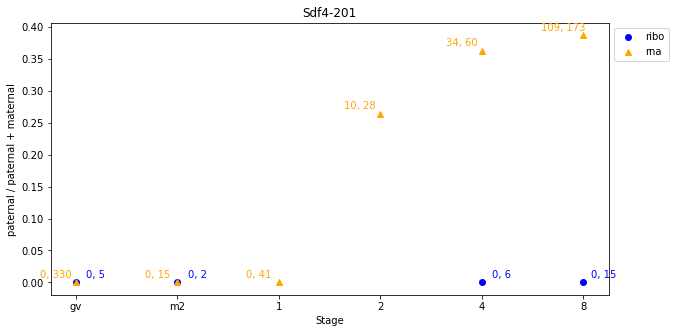

Snrnp70-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


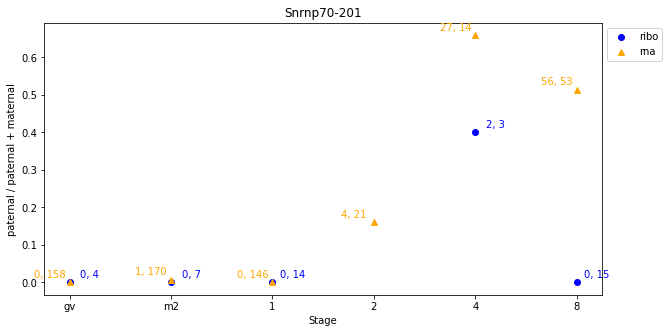

Ppp2ca-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


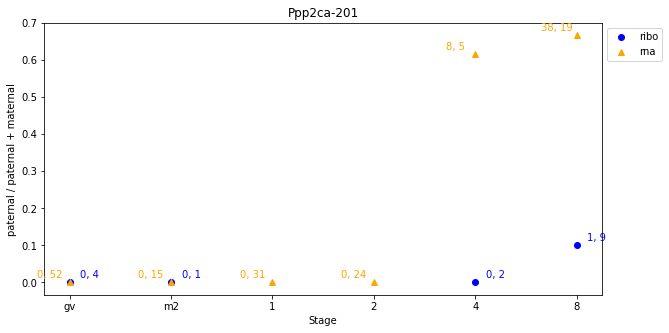

Tnpo3-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


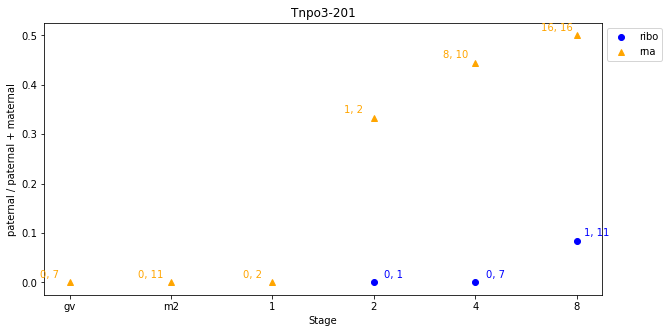

Bcat1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


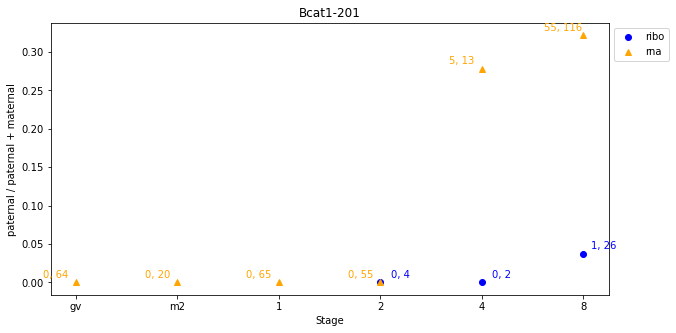

Ppp2ca-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


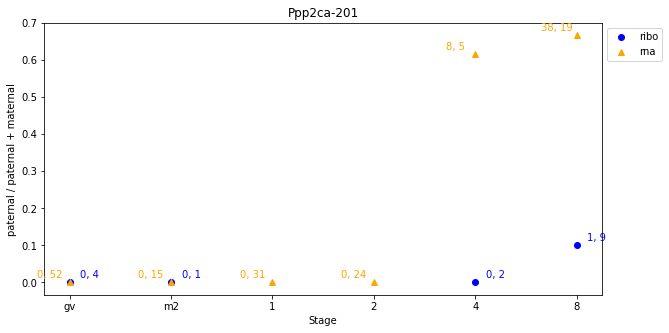

Mysm1-201


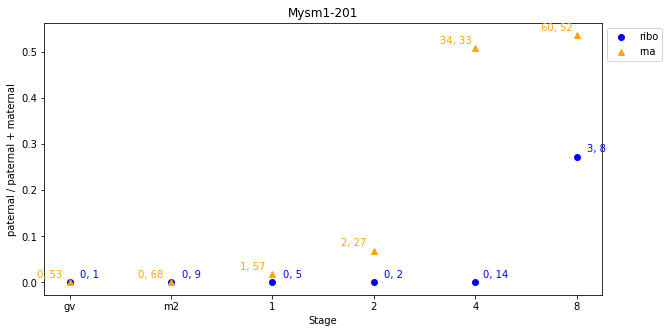

In [101]:
for g in paternal_dormant_genes:
    print(g)
    plot_transcript_ratios(g);

### Activation at 2 Cell Stage

In [102]:
genes_activated_at_2_cell_stage = \
["Dyrk3-201",
"Spdl1-201",
#"Rpl26-206",
#"Isyna1-204",
#"Tprn-201",
"Cct6a-201",
"Rps11-201"]

Dyrk3-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


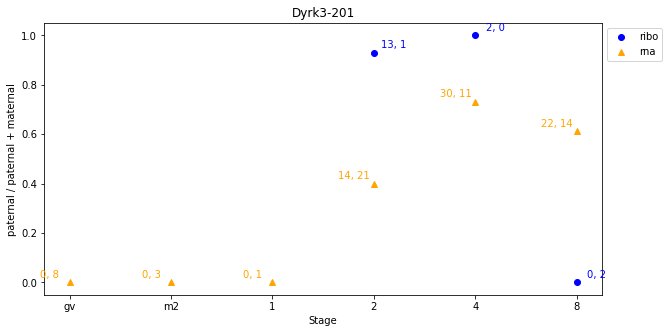

Spdl1-201


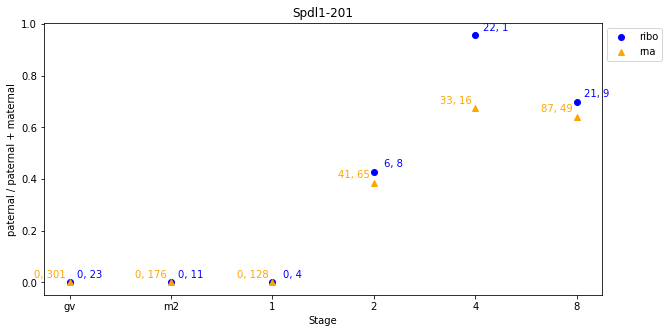

Cct6a-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


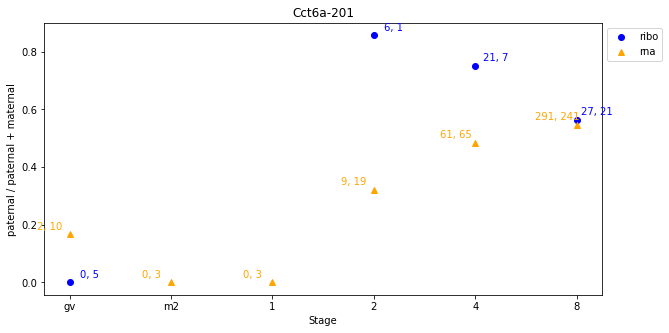

Rps11-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


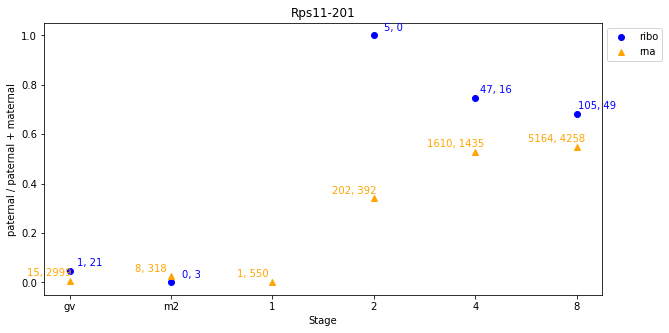

In [103]:
for g in genes_activated_at_2_cell_stage:
    print(g)
    plot_transcript_ratios(g);

### Activation at 4 Cell Stage 

In [104]:
genes_activated_at_4_cell_stage = \
[
"Atp13a3-202",
"Atp6v0a4-202",
"Ncoa3-201",
"Rpl28-201",
"Naalad2-204",
"Mcm7-201",
"Slc13a2-201",
"Ppat-202",
"Gtf3c5-201",
"Pemt-202",
]

Atp13a3-202


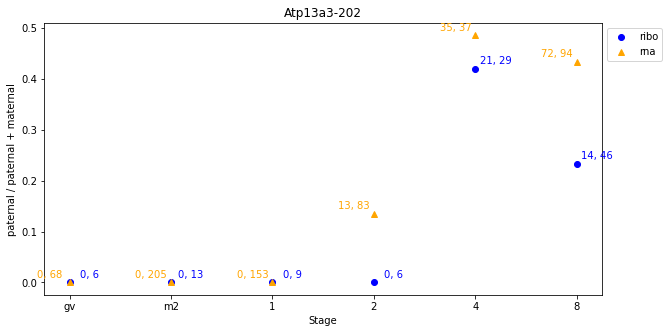

Atp6v0a4-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


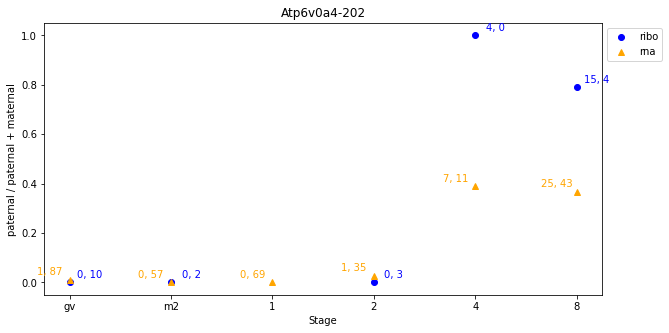

Ncoa3-201


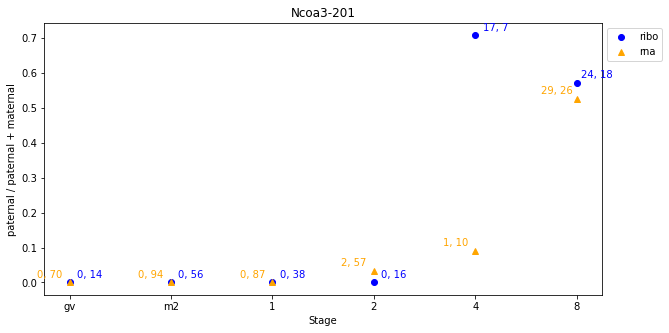

Rpl28-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


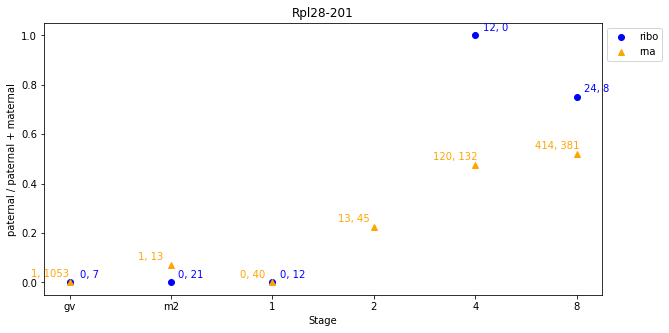

Naalad2-204


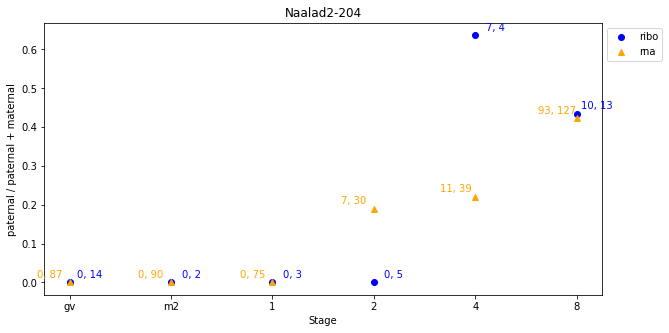

Mcm7-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


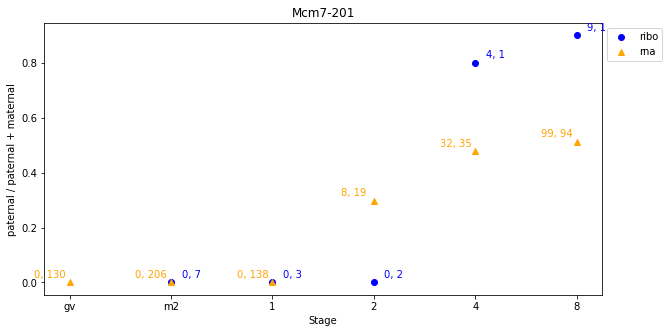

Slc13a2-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


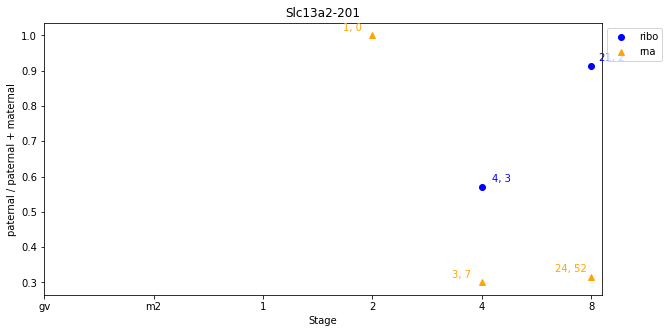

Ppat-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


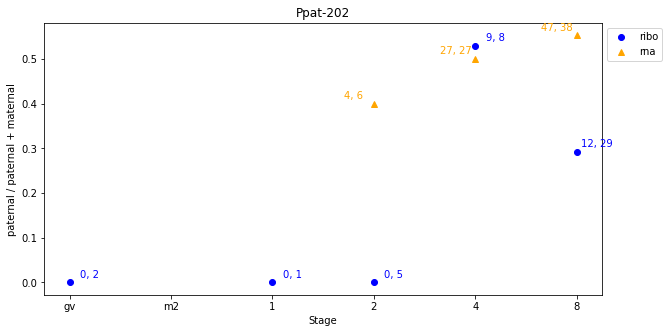

Gtf3c5-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


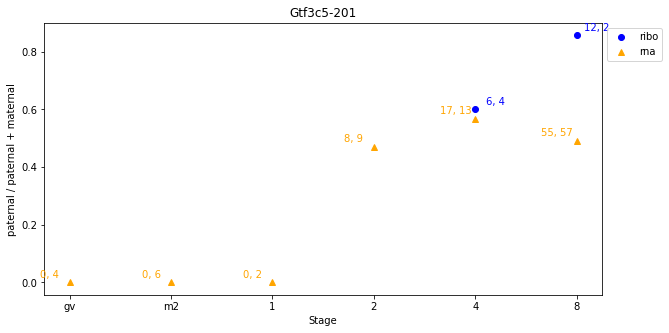

Pemt-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


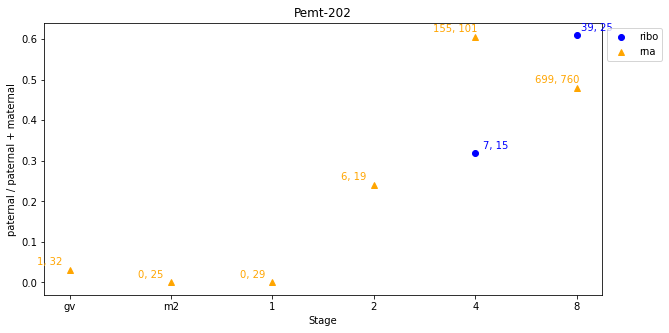

In [105]:
for g in genes_activated_at_4_cell_stage:
    print(g)
    plot_transcript_ratios(g);

### Activation at 8 Cell Stage

In [106]:
genes_activated_at_8_cell_stage = \
[

"Terf1-203",
"Tgoln1-201",
"Actr5-201",
"Pa2g4-202",
"Rtf2-201",
"Mtf1-201",
"Tmppe-201",
"Ltv1-201",
"Terf1-203",
"Nup155-201",
"Zfp296-201",
"Folr1-204"
]

Terf1-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


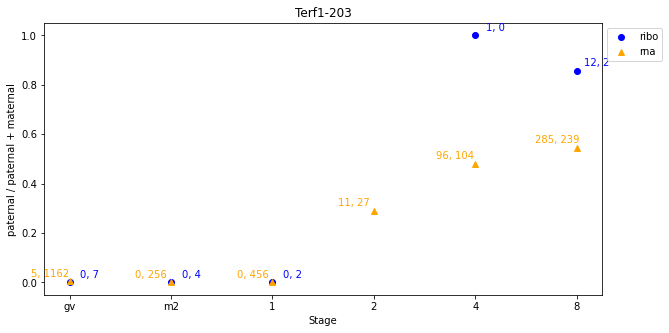

Tgoln1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


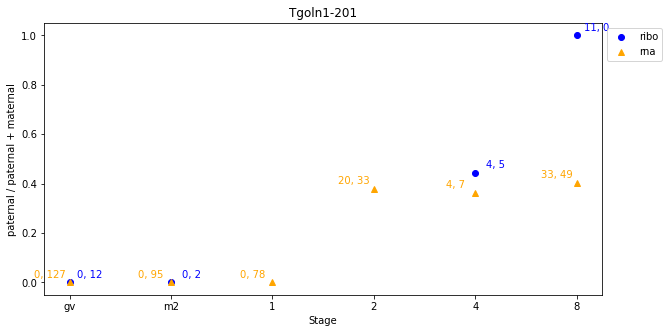

Actr5-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


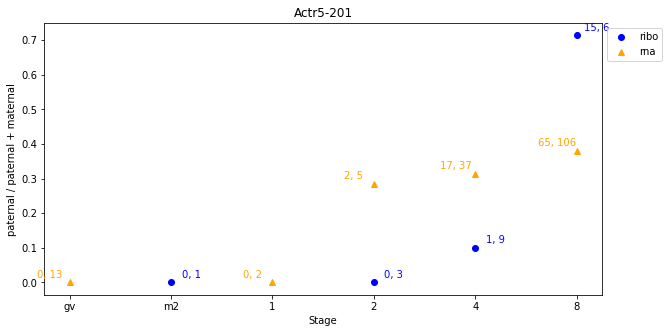

Pa2g4-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


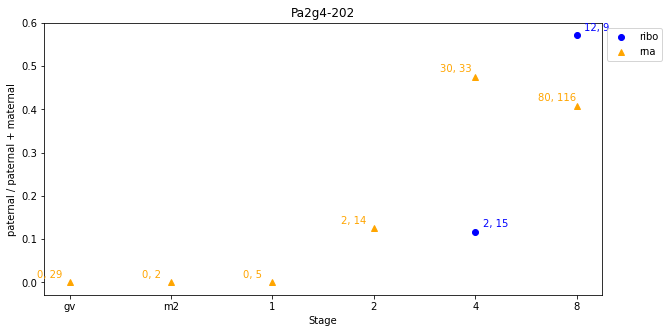

Rtf2-201


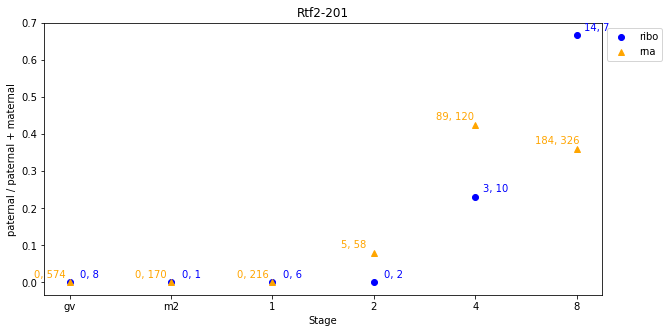

Mtf1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


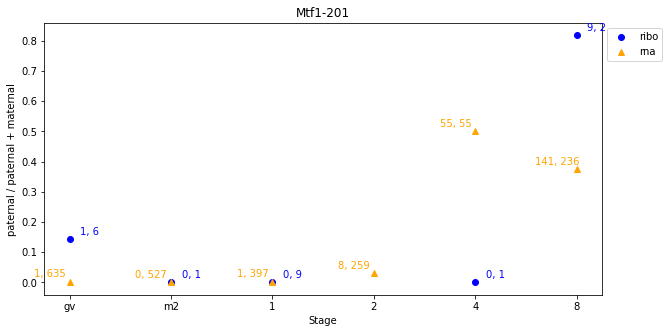

Tmppe-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


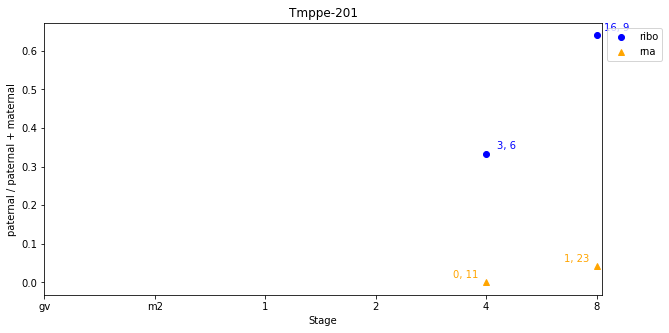

Ltv1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


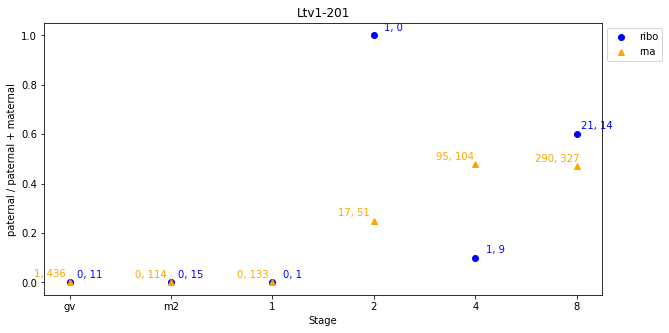

Terf1-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


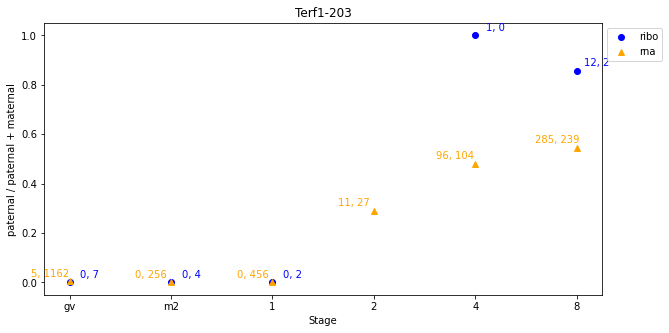

Nup155-201


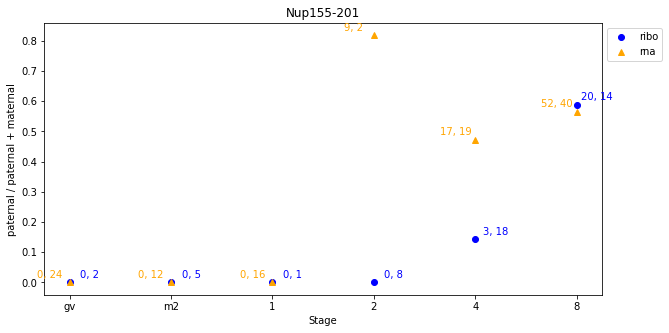

Zfp296-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


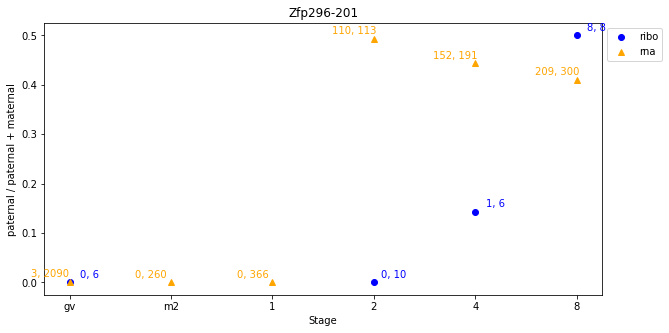

Folr1-204


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


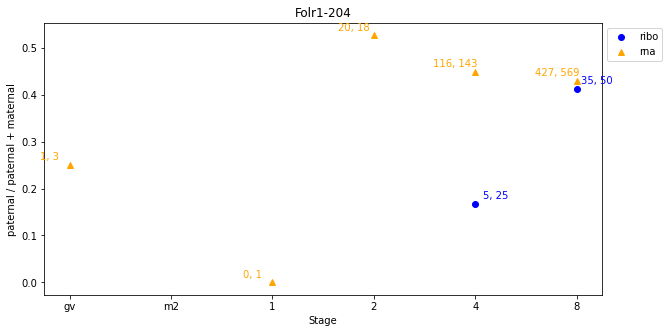

In [107]:
for g in genes_activated_at_8_cell_stage:
    print(g)
    plot_transcript_ratios(g);

### Genes that differ significantly at 8 Cell Stage

  * Ccnh-201
  * Pgd-201
  * Mrto4-201
  * Lyar-201
  * Sdf4-201
  * Ddb1-201
  * Atg7-201
  * Ppp2ca-201
  * Gtf3c5-201
  * Umps-201
  * **Slc13a2-201** 
  * **Tpx2-206**
  * Ankrd10-201
  * Rpl21-201
  * Tprn-201
  * Rtf2-201
  * Baz1a-205
  * Rpl38-203
  * Wdr-48-201
  * Kdm2b-202
  * Actr5-201
  * Cbx3-201
  * Pemt-202
  * Atp13a3-202
  * Terf1-203
  * Cth=201
  * Plk1-201
  * Ltn1-201
  * Lclat1-201
  * Ppat-202
  * Gmnn-201
  * Mcm7-201
  * Atp6v0a4-202
  * Tnpo3-201
  * Bcat1-201
  * Rpn2-202
  * Ulk1-201

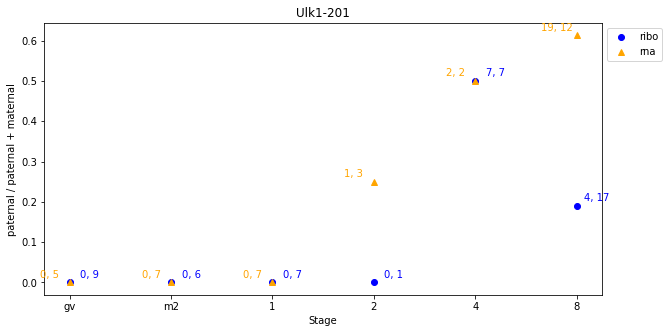

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 3       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 1       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 3       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 1       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 0       Mat: 9
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 2       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 1       Mat: 2
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 1       Mat: 0
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [108]:
get_details_of_gene("Ulk1-201", position_details = False)

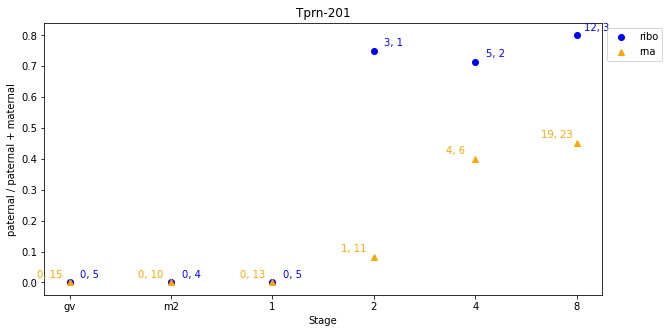

20210513-ITP-2cell-cross-50-B
Pat: 3       Mat: 1
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 6       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 2       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 3       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 2
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [109]:
get_details_of_gene("Tprn-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


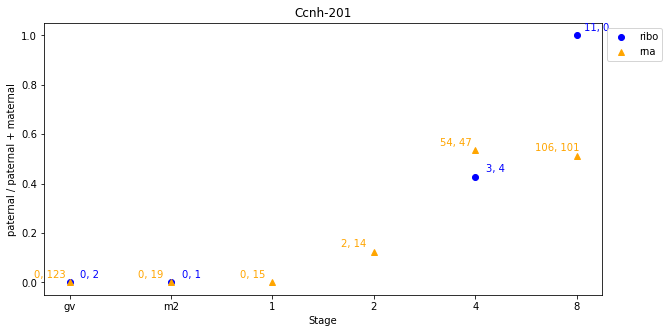

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 3       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 4       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 5       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 2
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [110]:
get_details_of_gene("Ccnh-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


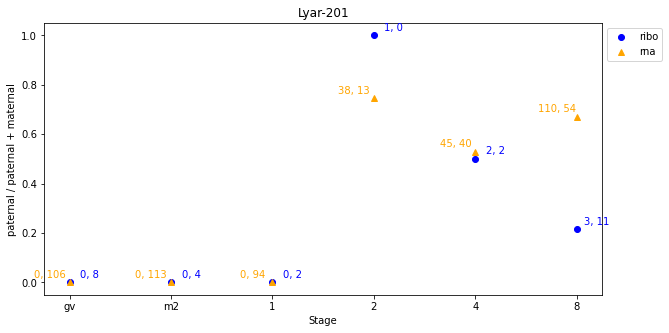

20210513-ITP-2cell-cross-50-B
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 3       Mat: 7
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 5       Mat: 3
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 1

In [111]:
get_details_of_gene("Lyar-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


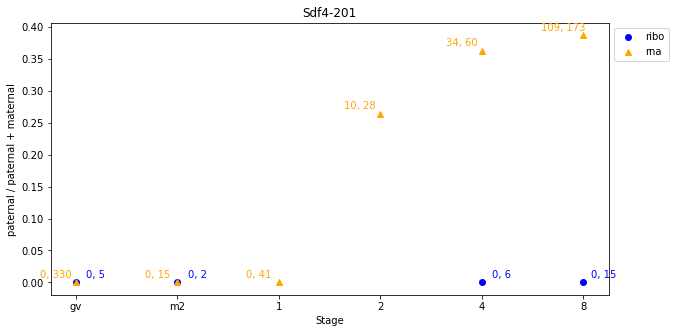

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 3
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 8
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 0       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 4
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 5       Mat: 5
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 4

In [112]:
get_details_of_gene("Sdf4-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


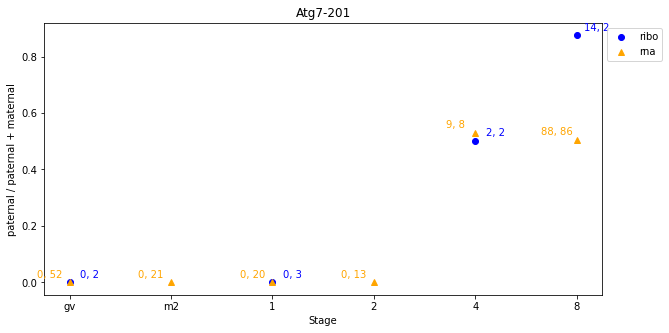

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 1       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 10       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 2       Mat: 1
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 3
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 

In [113]:
get_details_of_gene("Atg7-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


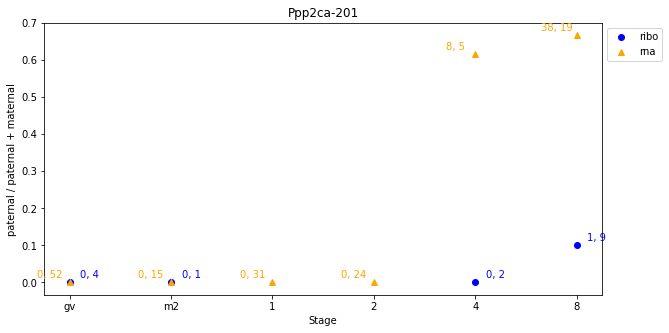

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 0       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 1       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 3
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 5
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [114]:
get_details_of_gene("Ppp2ca-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


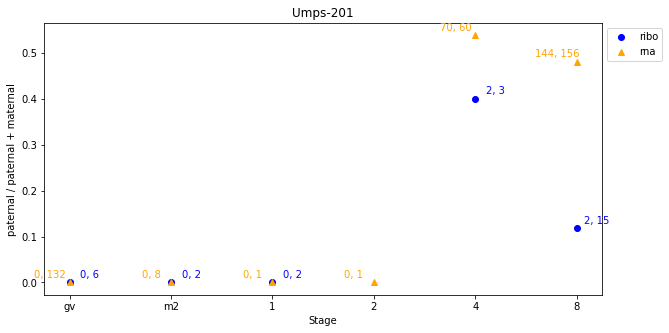

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 2       Mat: 5
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 0       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 3
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 0
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [115]:
get_details_of_gene("Umps-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


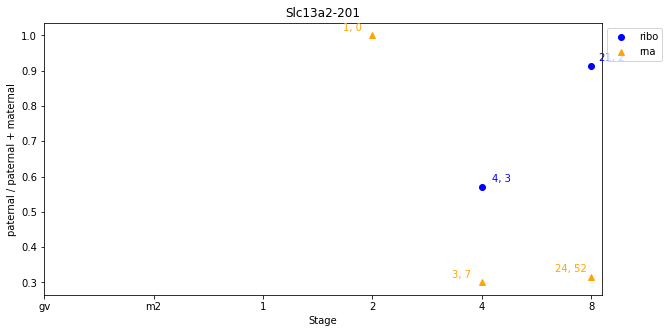

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
        transcript  position REF ALT  A  C  G  T
13286  Slc13a2-201      1784   G   T  0  0  0  0
13285  Slc13a2-201      1652   A   G  0  0  0  0
13284  Slc13a2-201      1616   T   C  0  0  0  0
13283  Slc13a2-201      1212   G   C  0  0  0  0
13282  Slc13a2-201      1100   T   C  0  0  0  0
13281  Slc13a2-201      1079   G   T  0  0  0  0
13280  Slc13a2-201      1073   G   A  0  0  0  0
13279  Slc13a2-201       800   T   C  0  0  0  0
13278  Slc13a2-201       695   C   T  0  0  0  0
13277  Slc13a2-201       545   T   C  0  0  0  0
13276  Slc13a2-201       533   C   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
        transcript  position REF ALT  A  C  G  T
13281  Slc13a2-201      1079   G   T  0  0  0  0
13280  Slc13a2-201      1073   G   A  0  0  0  0
13279  Slc13a2-201       800   T   C  0  0  0  0
13278  Slc13a2-201       695   C   T  0  0  0  0
13277  Slc13a2-201       545   T  

In [116]:
get_details_of_gene("Slc13a2-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


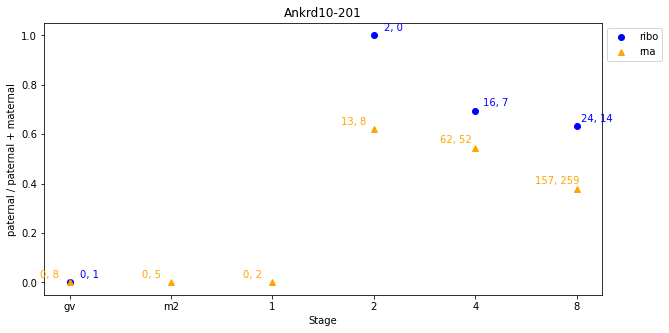

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 4       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 9       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 3       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 3       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 10       Mat: 7
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 8       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 3       Mat: 1
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 6       Mat: 0
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 

In [117]:
get_details_of_gene("Ankrd10-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


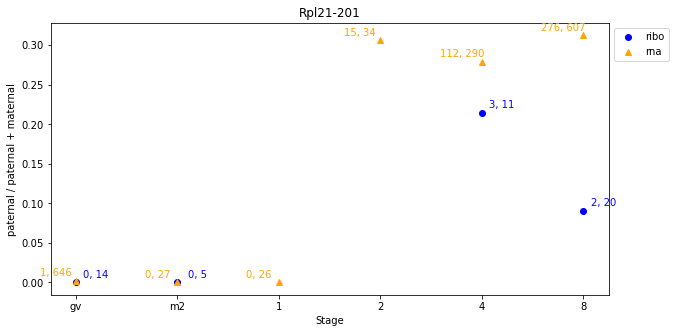

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 2       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 1       Mat: 4
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 5
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 2       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 0       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 5
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 7       Mat: 8
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 1

In [118]:
get_details_of_gene("Rpl21-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


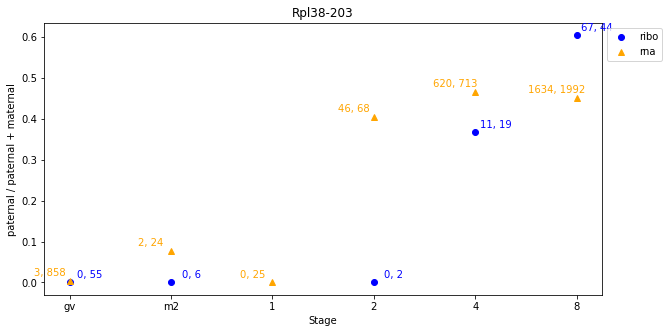

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 5       Mat: 7
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 3       Mat: 6
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 3       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 12       Mat: 12
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 17       Mat: 13
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 29       Mat: 12
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 9       Mat: 7
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 8       Mat: 20
--------------------------------
20210607-RNAseq-2cell-cross-B

In [119]:
get_details_of_gene("Rpl38-203", position_details = False)

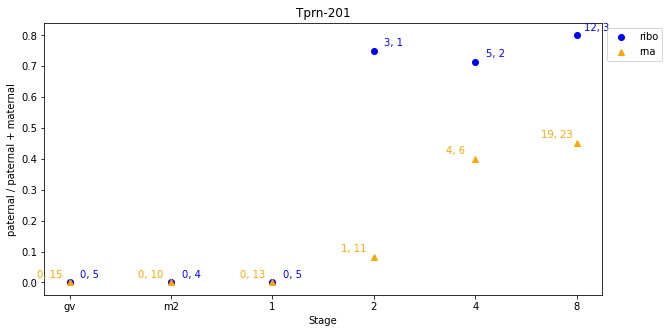

20210513-ITP-2cell-cross-50-B
Pat: 3       Mat: 1
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 6       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 2       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 3       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 2
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [120]:
get_details_of_gene("Tprn-201", position_details = False)

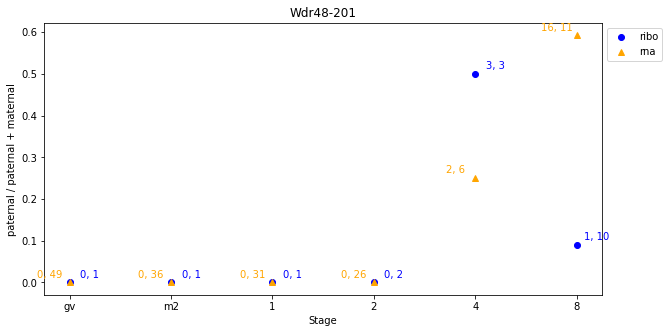

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 1       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 0       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 1       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 1
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 10
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 

In [121]:
get_details_of_gene("Wdr48-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


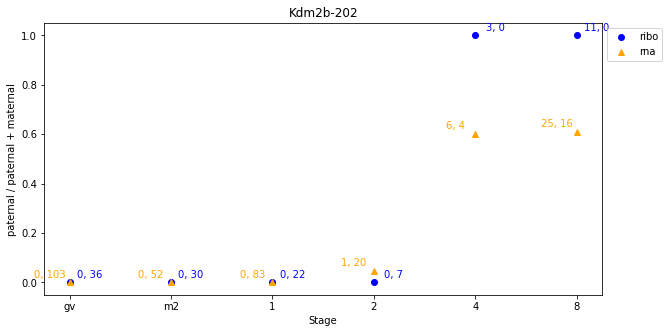

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 6
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 2       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 6       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 4       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 3
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 1

In [122]:
get_details_of_gene("Kdm2b-202", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


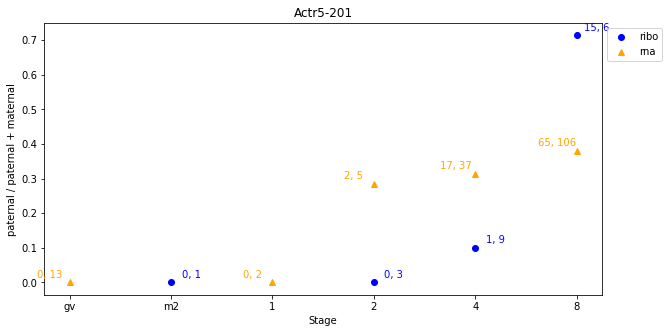

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 3
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 1       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 6       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 6       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 3       Mat: 2
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 0
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 0

In [123]:
get_details_of_gene("Actr5-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


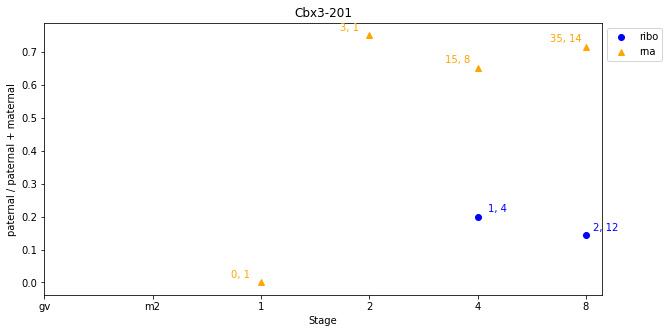

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 0       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 2       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 0       Mat: 3
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 1       Mat: 1
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 1

In [124]:
get_details_of_gene("Cbx3-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


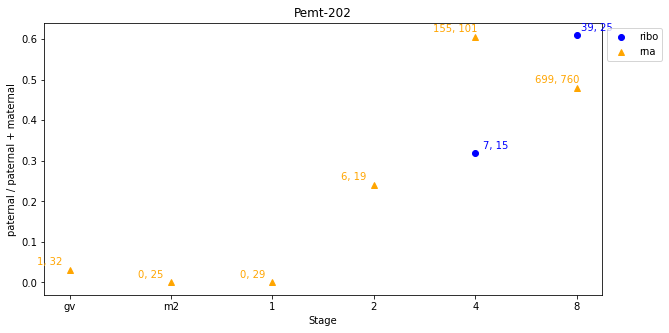

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 9
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 3       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 3       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 11       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 15       Mat: 5
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 10       Mat: 7
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 3       Mat: 7
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 2       Mat: 7
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat

In [125]:
get_details_of_gene("Pemt-202", position_details = False)

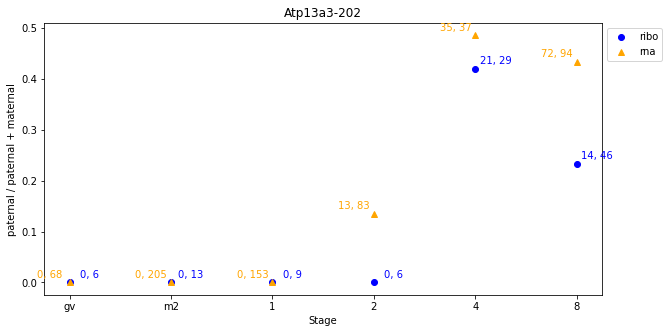

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 3
        transcript  position REF ALT  A  C  G  T
30433  Atp13a3-202      3114   G   A  0  0  2  0
30424  Atp13a3-202      1015   C   T  0  1  0  0
30435  Atp13a3-202      3861   T   C  0  0  0  0
30434  Atp13a3-202      3777   A   G  0  0  0  0
30432  Atp13a3-202      2976   T   C  0  0  0  0
30431  Atp13a3-202      2886   C   T  0  0  0  0
30430  Atp13a3-202      2700   C   T  0  0  0  0
30429  Atp13a3-202      2616   A   G  0  0  0  0
30428  Atp13a3-202      2241   C   T  0  0  0  0
30427  Atp13a3-202      1926   T   C  0  0  0  0
30426  Atp13a3-202      1869   A   G  0  0  0  0
30425  Atp13a3-202      1530   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 3
        transcript  position REF ALT  A  C  G  T
30431  Atp13a3-202      2886   C   T  0  2  0  0
30425  Atp13a3-202      1530   T   C  0  0  0  1
30435  Atp13a3-202      3861   T   C  0  0  0  0
30434  Atp13a3-202      3777   A  

In [126]:
get_details_of_gene("Atp13a3-202", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


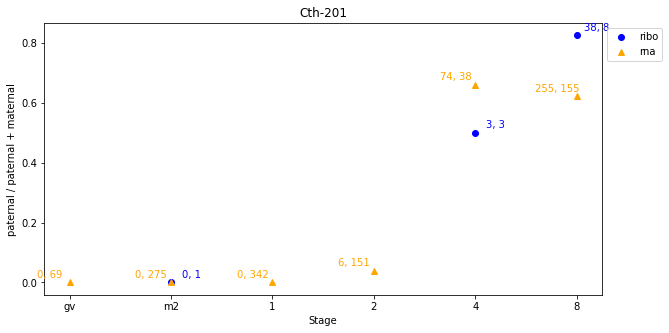

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 5       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 17       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 5       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 11       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 4       Mat: 39
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat

In [127]:
get_details_of_gene("Cth-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


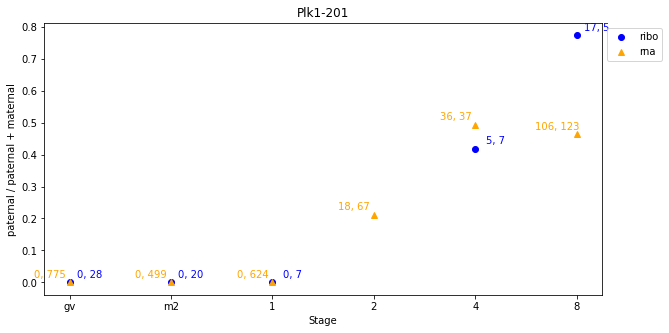

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 3
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 1
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 5       Mat: 1
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 3       Mat: 2
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 9       Mat: 0
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 4       Mat: 13
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 

In [128]:
get_details_of_gene("Plk1-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


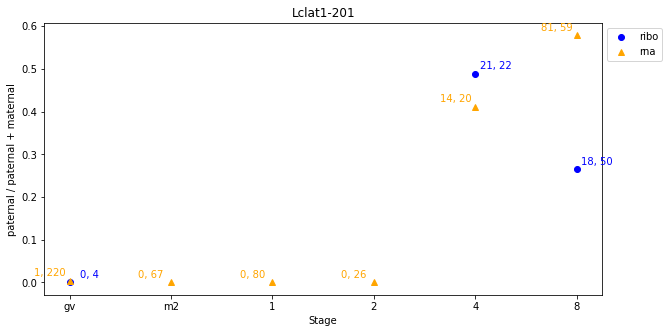

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 10       Mat: 4
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 5
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 9       Mat: 13
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 3       Mat: 13
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 6       Mat: 17
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 5       Mat: 6
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 4       Mat: 14
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 7
--------------------------------
20210607-RNAseq-2cell-cross-B
P

In [129]:
get_details_of_gene("Lclat1-201", position_details = False)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


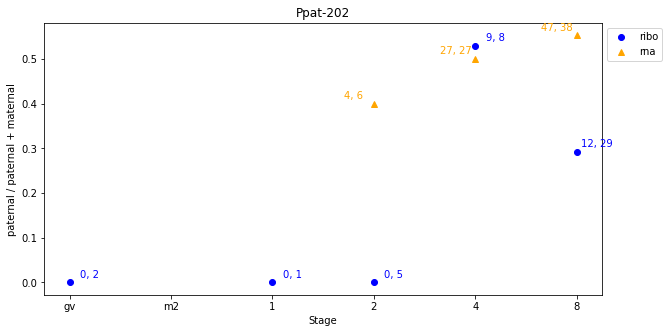

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 3
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 3       Mat: 3
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 4       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 1       Mat: 3
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 5       Mat: 11
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 4       Mat: 7
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 2       Mat: 8
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 0       Mat: 2
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat: 

In [130]:
get_details_of_gene("Ppat-202", position_details = False)

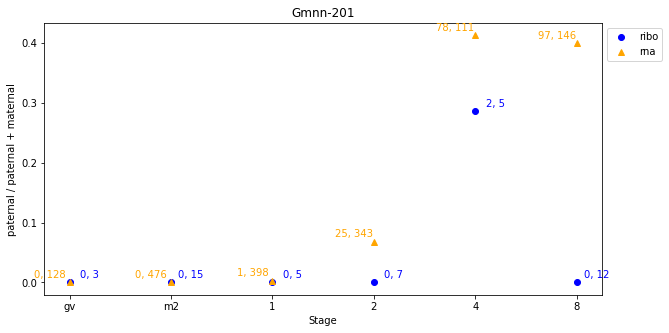

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 2
      transcript  position REF ALT  A  C  G  T
20290   Gmnn-201       771   T   G  0  0  0  2
20289   Gmnn-201       537   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 5
      transcript  position REF ALT  A  C  G  T
20290   Gmnn-201       771   T   G  0  0  0  3
20289   Gmnn-201       537   T   C  0  0  0  2
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
20290   Gmnn-201       771   T   G  0  0  0  0
20289   Gmnn-201       537   T   C  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
20290   Gmnn-201       771   T   G  0  0  0  0
20289   Gmnn-201       537   T   C  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 0
      transcript  position REF ALT  A  C  G  T
20290  

In [131]:
get_details_of_gene("Gmnn-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


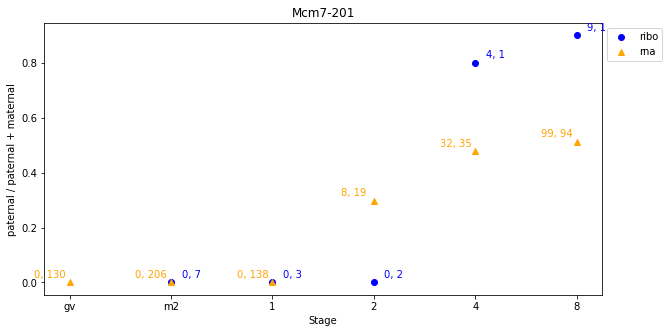

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
62121   Mcm7-201      2616   G   A  0  0  0  0
62120   Mcm7-201      2532   A   G  0  0  0  0
62119   Mcm7-201      2526   G   C  0  0  0  0
62118   Mcm7-201      2397   G   A  0  0  0  0
62117   Mcm7-201      1596   C   A  0  0  0  0
62116   Mcm7-201       961   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 2
      transcript  position REF ALT  A  C  G  T
62121   Mcm7-201      2616   G   A  0  0  2  0
62120   Mcm7-201      2532   A   G  0  0  0  0
62119   Mcm7-201      2526   G   C  0  0  0  0
62118   Mcm7-201      2397   G   A  0  0  0  0
62117   Mcm7-201      1596   C   A  0  0  0  0
62116   Mcm7-201       961   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
62121   Mcm7-201      2616   G   A  0  0  0  0
62120   Mcm7-201      2532   A  

In [132]:
get_details_of_gene("Mcm7-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


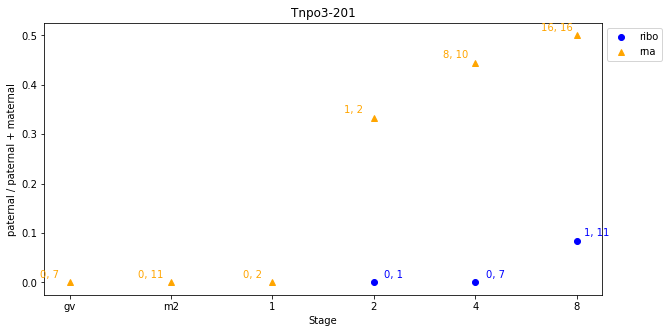

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
63722  Tnpo3-201      2757   T   C  0  0  0  0
63721  Tnpo3-201      1842   T   C  0  0  0  0
63720  Tnpo3-201      1833   G   T  0  0  0  0
63719  Tnpo3-201       867   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 1
      transcript  position REF ALT  A  C  G  T
63719  Tnpo3-201       867   T   C  0  0  0  1
63722  Tnpo3-201      2757   T   C  0  0  0  0
63721  Tnpo3-201      1842   T   C  0  0  0  0
63720  Tnpo3-201      1833   G   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
63722  Tnpo3-201      2757   T   C  0  0  0  0
63721  Tnpo3-201      1842   T   C  0  0  0  0
63720  Tnpo3-201      1833   G   T  0  0  0  0
63719  Tnpo3-201       867   T   C  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat

In [133]:
get_details_of_gene("Tnpo3-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


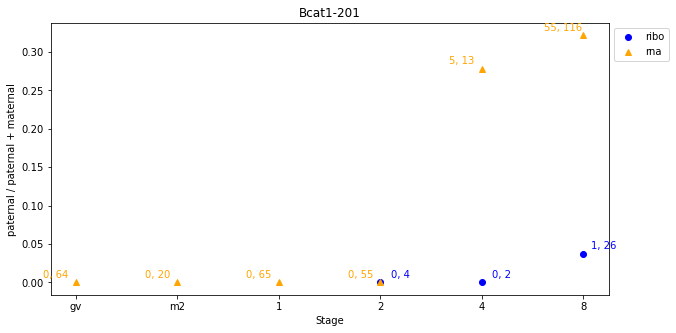

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
67080  Bcat1-201       967   C   T  0  0  0  0
67081  Bcat1-201      1105   A   G  0  0  0  0
67082  Bcat1-201      1132   G   A  0  0  0  0
67083  Bcat1-201      1153   G   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
67083  Bcat1-201      1153   G   A  0  0  0  0
67082  Bcat1-201      1132   G   A  0  0  0  0
67081  Bcat1-201      1105   A   G  0  0  0  0
67080  Bcat1-201       967   C   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 4
      transcript  position REF ALT  A  C  G  T
67080  Bcat1-201       967   C   T  0  2  0  0
67083  Bcat1-201      1153   G   A  0  0  2  0
67082  Bcat1-201      1132   G   A  0  0  0  0
67081  Bcat1-201      1105   A   G  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat

In [134]:
get_details_of_gene("Bcat1-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


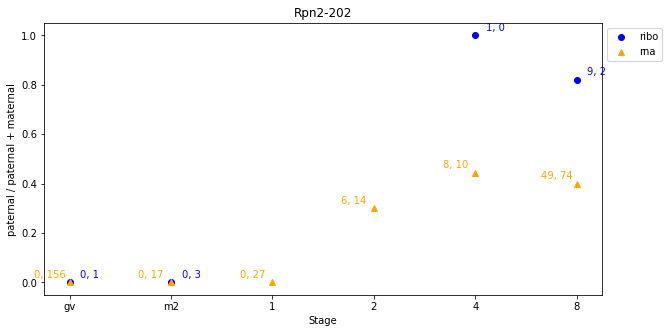

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
46652   Rpn2-202      1917   G   A  0  0  0  0
46651   Rpn2-202      1202   C   T  0  0  0  0
46650   Rpn2-202      1099   A   G  0  0  0  0
46649   Rpn2-202       915   G   A  0  0  0  0
46648   Rpn2-202       288   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
46650   Rpn2-202      1099   A   G  0  0  0  0
46649   Rpn2-202       915   G   A  0  0  0  0
46648   Rpn2-202       288   T   C  0  0  0  0
46651   Rpn2-202      1202   C   T  0  0  0  0
46652   Rpn2-202      1917   G   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
46652   Rpn2-202      1917   G   A  0  0  0  0
46651   Rpn2-202      1202   C   T  0  0  0  0
46650   Rpn2-202      1099   A   G  0  0  0  0
46649   Rpn2-202       915   G  

In [135]:
get_details_of_gene("Rpn2-202", position_details = True)

## Genes That Differ Significantly at 4 Cell Stage

  * Ccnb1-201
  * Cct6a-201
  * Dctd-203
  * Eprs-201
  * Polr1e-204
  * Cdc42-202
  * Ltv1-201
  * Ankrd10-201
  * Rpl21-201
  * Rtf2-201
  * Ncoa3-201
  * Rpl26-206
  * Pemt-202
  * Mysm1-201
  * Eif3d-201
  * Ddx21-201
  * Nin-202
  * Naalad2-204
  * Spdl1-201
  * Brca2-201
  * Cdk1-201
  * Znhit3-201
  * Rps6-201
  * Isyna1-204
  * Pa2g4-202
  * Rnpep-202
  * Folr1-204
  * Mrps9-201

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


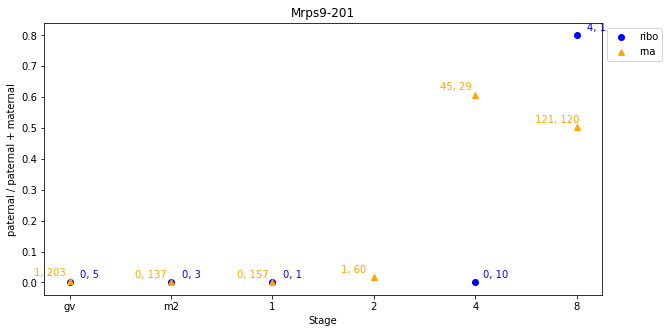

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
5417  Mrps9-201       749   A   C  0  0  0  0
5416  Mrps9-201       357   G   A  0  0  0  0
5415  Mrps9-201       212   T   C  0  0  0  0
5414  Mrps9-201       122   A   G  0  0  0  0
5413  Mrps9-201       105   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
5413  Mrps9-201       105   T   C  0  0  0  0
5414  Mrps9-201       122   A   G  0  0  0  0
5417  Mrps9-201       749   A   C  0  0  0  0
5416  Mrps9-201       357   G   A  0  0  0  0
5415  Mrps9-201       212   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
5413  Mrps9-201       105   T   C  0  0  0  0
5414  Mrps9-201       122   A   G  0  0  0  0
5415  Mrps9-201       212   T   C  0  0  0  0
5417  Mrps9-201       749   A   C  0  0  0  0
54

In [136]:
get_details_of_gene("Mrps9-201", position_details = True)

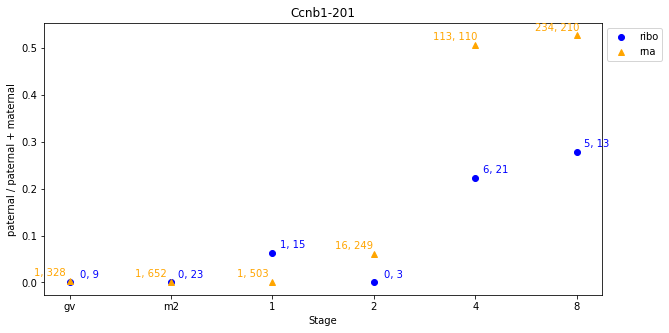

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 2
      transcript  position REF ALT  A  C  G  T
22801  Ccnb1-201       546   G   A  0  0  2  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
22801  Ccnb1-201       546   G   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 1
      transcript  position REF ALT  A  C  G  T
22801  Ccnb1-201       546   G   A  0  0  1  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 6
      transcript  position REF ALT  A  C  G  T
22801  Ccnb1-201       546   G   A  1  0  6  0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 3       Mat: 8
      transcript  position REF ALT  A  C  G  T
22801  Ccnb1-201       546   G   A  3  0  8  0
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 7
      transcript  position REF ALT  A  C  G  T
22801  Ccnb1-201  

In [137]:
get_details_of_gene("Ccnb1-201", position_details = True)

In [138]:
#get_details_of_gene("Cct6a-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


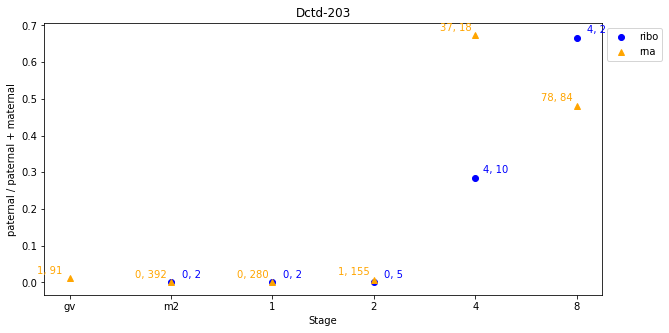

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 5
      transcript  position REF ALT  A  C  G  T
75516   Dctd-203       732   A   G  3  0  0  0
75514   Dctd-203       506   T   A  0  0  0  2
75515   Dctd-203       711   C   T  0  0  0  0
75513   Dctd-203       393   A   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
75516   Dctd-203       732   A   G  0  0  0  0
75515   Dctd-203       711   C   T  0  0  0  0
75514   Dctd-203       506   T   A  0  0  0  0
75513   Dctd-203       393   A   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
75515   Dctd-203       711   C   T  0  0  0  0
75514   Dctd-203       506   T   A  0  0  0  0
75513   Dctd-203       393   A   G  0  0  0  0
75516   Dctd-203       732   A   G  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 2       Mat

In [139]:
get_details_of_gene("Dctd-203", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


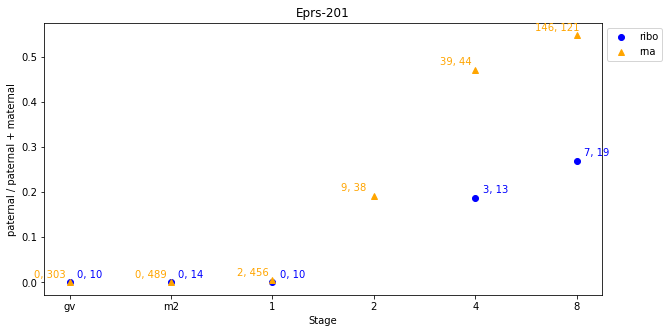

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
9929   Eprs-201       669   A   G  0  0  0  0
9927   Eprs-201       434   A   G  0  0  0  0
9926   Eprs-201       347   T   C  0  0  0  0
9925   Eprs-201       346   G   T  0  0  0  0
9924   Eprs-201       328   G   A  0  0  0  0
9923   Eprs-201       214   G   A  0  0  0  0
9928   Eprs-201       546   G   A  0  0  0  0
9930   Eprs-201      1636   G   A  0  0  0  0
9931   Eprs-201      1675   C   T  0  0  0  0
9940   Eprs-201      4495   T   C  0  0  0  0
9941   Eprs-201      4627   C   T  0  0  0  0
9939   Eprs-201      4345   T   G  0  0  0  0
9938   Eprs-201      3142   C   G  0  0  0  0
9937   Eprs-201      2842   G   A  0  0  0  0
9936   Eprs-201      2812   C   T  0  0  0  0
9935   Eprs-201      2767   C   G  0  0  0  0
9934   Eprs-201      2077   C   T  0  0  0  0
9933   Eprs-201      2038   C   T  0  0  0  0
9932   Eprs-201      2006   T   C  0  0  0  0
------------------------------

In [140]:
get_details_of_gene("Eprs-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


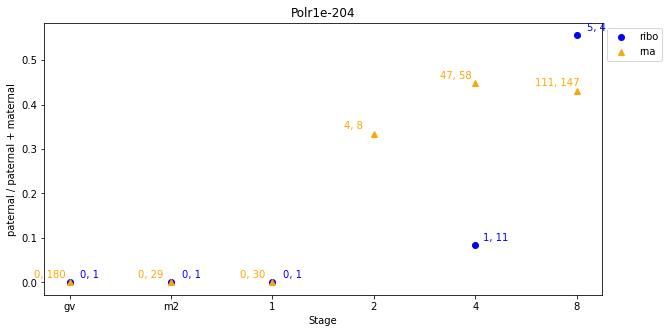

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
52243  Polr1e-204       770   C   T  0  0  0  0
52248  Polr1e-204      1381   G   A  0  0  0  0
52247  Polr1e-204      1242   G   C  0  0  0  0
52246  Polr1e-204      1238   G   T  0  0  0  0
52245  Polr1e-204      1157   T   C  0  0  0  0
52244  Polr1e-204      1077   A   G  0  0  0  0
52242  Polr1e-204       724   T   C  0  0  0  0
52241  Polr1e-204       721   G   A  0  0  0  0
52240  Polr1e-204       717   G   T  0  0  0  0
52239  Polr1e-204       692   C   T  0  0  0  0
52238  Polr1e-204       659   T   C  0  0  0  0
52237  Polr1e-204       329   T   C  0  0  0  0
52236  Polr1e-204        98   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
52241  Polr1e-204       721   G   A  0  0  0  0
52248  Polr1e-204      1381   G   A  0  0  0  0
52247  Polr1e-204      1242   G   C  0  0  0  0
522

In [141]:
get_details_of_gene("Polr1e-204", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


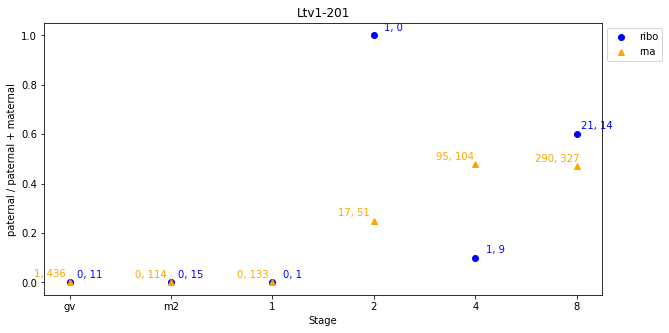

20210513-ITP-2cell-cross-50-B
Pat: 1       Mat: 0
    transcript  position REF ALT  A  C  G  T
459   Ltv1-201       297   T   C  0  1  0  0
465   Ltv1-201       990   G   C  0  0  0  0
464   Ltv1-201       744   A   G  0  0  0  0
463   Ltv1-201       691   C   A  0  0  0  0
462   Ltv1-201       394   T   A  0  0  0  0
461   Ltv1-201       391   A   G  0  0  0  0
460   Ltv1-201       336   T   C  0  0  0  0
458   Ltv1-201       228   C   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
    transcript  position REF ALT  A  C  G  T
461   Ltv1-201       391   A   G  0  0  0  0
465   Ltv1-201       990   G   C  0  0  0  0
464   Ltv1-201       744   A   G  0  0  0  0
463   Ltv1-201       691   C   A  0  0  0  0
462   Ltv1-201       394   T   A  0  0  0  0
460   Ltv1-201       336   T   C  0  0  0  0
459   Ltv1-201       297   T   C  0  0  0  0
458   Ltv1-201       228   C   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross

In [142]:
get_details_of_gene("Ltv1-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


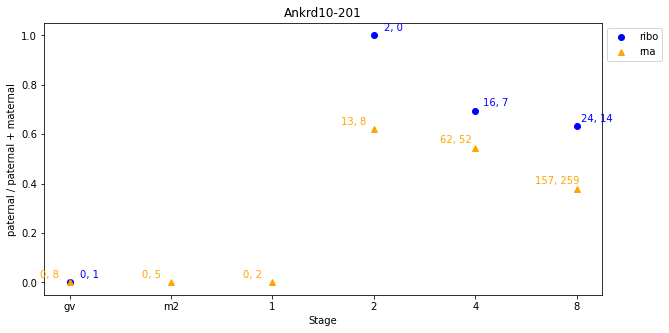

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
        transcript  position REF ALT  A  C  G  T
74315  Ankrd10-201      1208   G   A  0  0  0  0
74314  Ankrd10-201      1175   C   T  0  0  0  0
74313  Ankrd10-201      1174   A   G  0  0  0  0
74312  Ankrd10-201       972   G   A  0  0  0  0
74311  Ankrd10-201       878   T   C  0  0  0  0
74310  Ankrd10-201       269   G   A  0  0  0  0
74309  Ankrd10-201       154   G   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 2       Mat: 0
        transcript  position REF ALT  A  C  G  T
74311  Ankrd10-201       878   T   C  0  2  0  0
74315  Ankrd10-201      1208   G   A  0  0  0  0
74314  Ankrd10-201      1175   C   T  0  0  0  0
74313  Ankrd10-201      1174   A   G  0  0  0  0
74312  Ankrd10-201       972   G   A  0  0  0  0
74310  Ankrd10-201       269   G   A  0  0  0  0
74309  Ankrd10-201       154   G   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0


In [143]:
get_details_of_gene("Ankrd10-201", position_details = True)

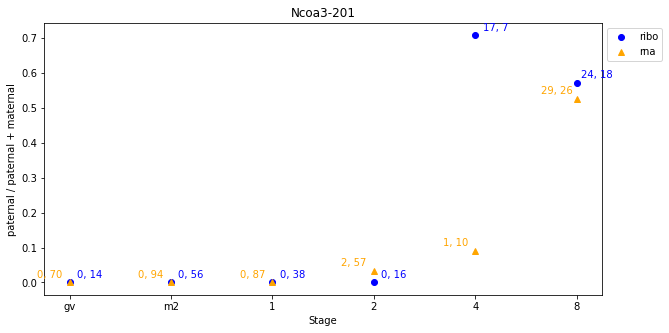

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 7
      transcript  position REF ALT  A  C  G  T
47084  Ncoa3-201      2935   C   G  0  2  0  0
47086  Ncoa3-201      4414   C   T  0  2  0  0
47081  Ncoa3-201      2032   T   C  0  0  0  1
47080  Ncoa3-201      1974   C   T  0  1  0  0
47083  Ncoa3-201      2326   G   T  0  0  1  0
47085  Ncoa3-201      4276   T   C  0  0  0  0
47082  Ncoa3-201      2122   G   A  0  0  0  0
47079  Ncoa3-201      1618   T   C  0  0  0  0
47078  Ncoa3-201      1615   T   C  0  0  0  0
47077  Ncoa3-201      1563   A   G  0  0  0  0
47076  Ncoa3-201      1080   G   A  0  0  0  0
47075  Ncoa3-201       991   C   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 4
      transcript  position REF ALT  A  C  G  T
47084  Ncoa3-201      2935   C   G  0  3  0  0
47081  Ncoa3-201      2032   T   C  0  0  0  1
47075  Ncoa3-201       991   C   G  0  0  0  0
47086  Ncoa3-201      4414   C   T  0  0  0  0
47076  Ncoa3-201     

In [144]:
get_details_of_gene("Ncoa3-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


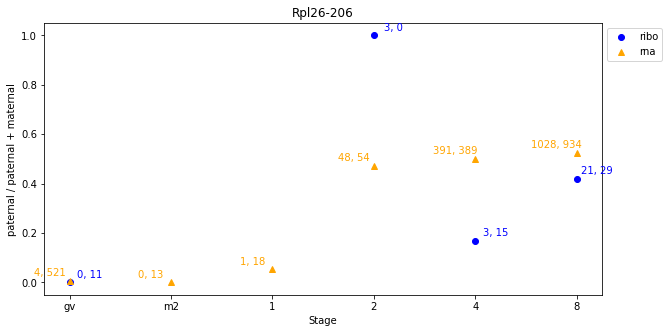

20210513-ITP-2cell-cross-50-B
Pat: 3       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 5
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 2       Mat: 2
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 0       Mat: 8
--------------------------------
20210513-ITP-8cell-cross-50-A
Pat: 5       Mat: 8
--------------------------------
20210513-ITP-8cell-cross-50-B
Pat: 8       Mat: 4
--------------------------------
20210513-ITP-8cell-cross-50-C
Pat: 4       Mat: 10
--------------------------------
20210513-ITP-8cell-cross-50-D
Pat: 4       Mat: 7
--------------------------------
#########################################
RNA-SEQ:
20210607-RNAseq-2cell-cross-A
Pat: 14       Mat: 20
--------------------------------
20210607-RNAseq-2cell-cross-B
Pat

In [145]:
get_details_of_gene("Rpl26-206", position_details = False)

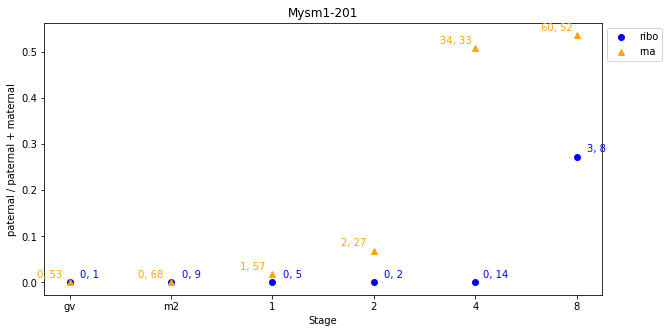

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
53296  Mysm1-201      1059   A   C  0  0  0  0
53295  Mysm1-201       900   G   A  0  0  0  0
53294  Mysm1-201       610   C   G  0  0  0  0
53293  Mysm1-201       375   C   T  0  0  0  0
53292  Mysm1-201       351   G   T  0  0  0  0
53291  Mysm1-201       332   G   A  0  0  0  0
53297  Mysm1-201      2136   G   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
53294  Mysm1-201       610   C   G  0  0  0  0
53297  Mysm1-201      2136   G   A  0  0  0  0
53296  Mysm1-201      1059   A   C  0  0  0  0
53295  Mysm1-201       900   G   A  0  0  0  0
53293  Mysm1-201       375   C   T  0  0  0  0
53292  Mysm1-201       351   G   T  0  0  0  0
53291  Mysm1-201       332   G   A  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 2
      transcript  position REF A

In [146]:
get_details_of_gene("Mysm1-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


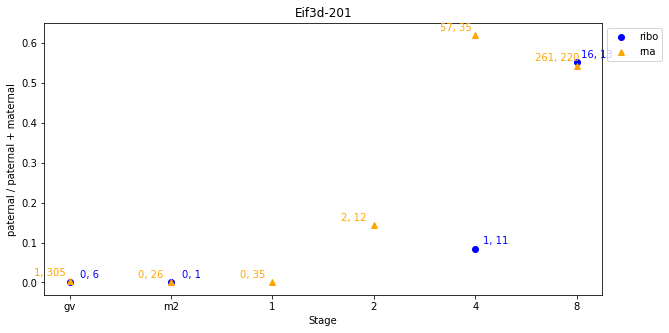

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
27780  Eif3d-201      1278   T   C  0  0  0  0
27779  Eif3d-201      1176   G   A  0  0  0  0
27778  Eif3d-201      1029   T   C  0  0  0  0
27777  Eif3d-201       774   A   G  0  0  0  0
27776  Eif3d-201       351   A   G  0  0  0  0
27781  Eif3d-201      1296   C   T  0  0  0  0
27782  Eif3d-201      1308   C   T  0  0  0  0
27783  Eif3d-201      1575   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
27781  Eif3d-201      1296   C   T  0  0  0  0
27780  Eif3d-201      1278   T   C  0  0  0  0
27779  Eif3d-201      1176   G   A  0  0  0  0
27778  Eif3d-201      1029   T   C  0  0  0  0
27777  Eif3d-201       774   A   G  0  0  0  0
27776  Eif3d-201       351   A   G  0  0  0  0
27782  Eif3d-201      1308   C   T  0  0  0  0
27783  Eif3d-201      1575   T   C  0  0  0  0
---------------------

In [147]:
get_details_of_gene("Eif3d-201", position_details = True)

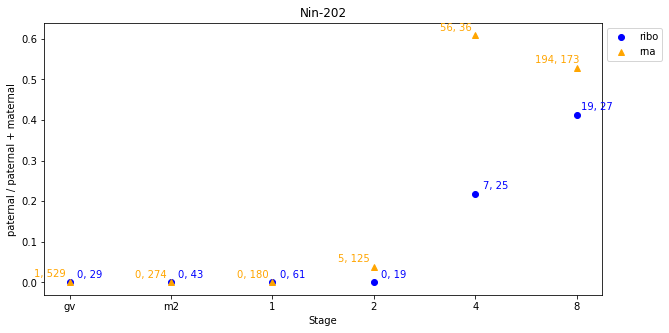

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 8
      transcript  position REF ALT  A  C  G  T
17741    Nin-202      1977   A   G  2  0  0  0
17742    Nin-202      1986   G   A  0  0  2  0
17763    Nin-202      5676   A   G  1  0  0  0
17757    Nin-202      4283   C   T  0  1  0  0
17756    Nin-202      4264   G   A  0  0  1  0
17729    Nin-202       654   C   T  0  1  0  0
17731    Nin-202       729   A   G  0  0  0  0
17751    Nin-202      3618   A   G  0  0  0  0
17750    Nin-202      3471   C   T  0  0  0  0
17749    Nin-202      3183   A   G  0  0  0  0
17748    Nin-202      3048   C   T  0  0  0  0
17747    Nin-202      3037   A   G  0  0  0  0
17746    Nin-202      2746   A   G  0  0  0  0
17745    Nin-202      2571   A   G  0  0  0  0
17744    Nin-202      2070   A   G  0  0  0  0
17743    Nin-202      2039   G   A  0  0  0  0
17740    Nin-202      1942   G   C  0  0  0  0
17739    Nin-202      1935   G   T  0  0  0  0
17738    Nin-202      1929   T   C  0  0  0  0
17737    N

Pat: 49       Mat: 37
      transcript  position REF ALT  A   C  G  T
17763    Nin-202      5676   A   G  6   1  9  0
17761    Nin-202      5280   G   C  0  10  5  0
17762    Nin-202      5346   A   G  5   0  5  0
17764    Nin-202      5748   A   C  1   5  0  0
17760    Nin-202      5037   G   A  2   0  4  0
17731    Nin-202       729   A   G  1   0  3  0
17734    Nin-202      1284   A   G  2   0  2  0
17735    Nin-202      1285   C   T  0   2  0  2
17737    Nin-202      1674   G   A  1   0  3  0
17742    Nin-202      1986   G   A  1   0  2  0
17741    Nin-202      1977   A   G  1   0  1  0
17754    Nin-202      3834   T   C  0   1  0  1
17740    Nin-202      1942   G   C  0   1  0  0
17744    Nin-202      2070   A   G  0   0  1  0
17749    Nin-202      3183   A   G  0   0  1  0
17755    Nin-202      4240   A   C  1   0  0  0
17758    Nin-202      4447   C   G  0   0  1  0
17738    Nin-202      1929   T   C  0   1  0  0
17739    Nin-202      1935   G   T  0   0  0  1
17736    Nin-202  

In [148]:
get_details_of_gene("Nin-202", position_details = True)

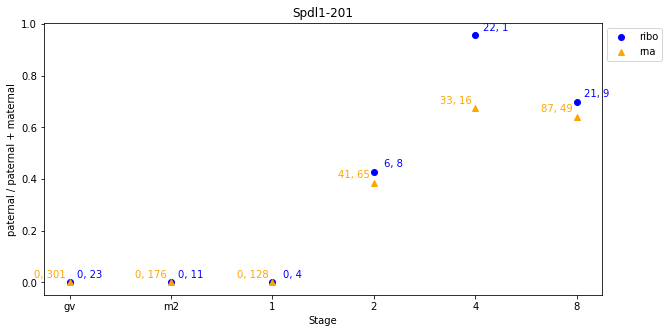

20210513-ITP-2cell-cross-50-B
Pat: 2       Mat: 5
      transcript  position REF ALT  A  C  G  T
11142  Spdl1-201      1565   G   A  0  0  3  0
11141  Spdl1-201      1499   G   C  0  0  2  0
11139  Spdl1-201      1466   G   A  2  0  0  0
11143  Spdl1-201      1979   A   G  0  0  0  0
11140  Spdl1-201      1493   T   C  0  0  0  0
11131  Spdl1-201       524   G   A  0  0  0  0
11138  Spdl1-201      1428   C   T  0  0  0  0
11137  Spdl1-201      1208   C   T  0  0  0  0
11136  Spdl1-201      1140   A   G  0  0  0  0
11135  Spdl1-201      1017   C   T  0  0  0  0
11134  Spdl1-201       672   G   C  0  0  0  0
11133  Spdl1-201       667   C   A  0  0  0  0
11132  Spdl1-201       648   A   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 3
      transcript  position REF ALT  A  C  G  T
11136  Spdl1-201      1140   A   G  2  0  0  0
11137  Spdl1-201      1208   C   T  0  1  0  0
11142  Spdl1-201      1565   G   A  0  0  0  0
11143  Spdl1-201     

In [149]:
get_details_of_gene("Spdl1-201", position_details = True)

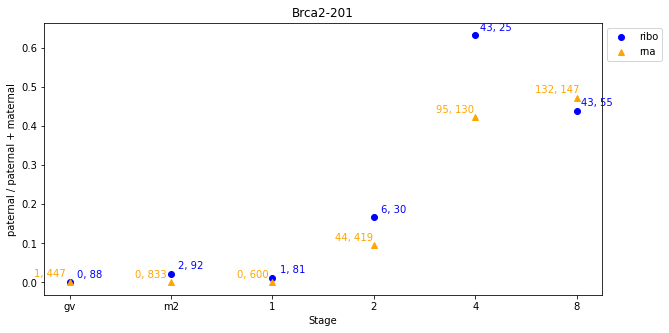

20210513-ITP-2cell-cross-50-B
Pat: 5       Mat: 9
      transcript  position REF ALT  A  C  G  T
63101  Brca2-201      2731   C   T  0  2  0  2
63159  Brca2-201      9232   A   G  1  0  2  0
63098  Brca2-201      1573   A   C  2  0  0  0
63097  Brca2-201       778   G   A  0  0  1  0
63107  Brca2-201      3119   T   A  0  0  0  1
...          ...       ...  ..  .. .. .. .. ..
63132  Brca2-201      5675   T   C  0  0  0  0
63131  Brca2-201      5599   T   A  0  0  0  0
63130  Brca2-201      5588   A   C  0  0  0  0
63129  Brca2-201      5129   A   G  0  0  0  0
63128  Brca2-201      5027   C   A  0  0  0  0

[77 rows x 8 columns]
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 1       Mat: 14
      transcript  position REF ALT  A  C  G  T
63099  Brca2-201      2492   A   C  4  0  0  0
63139  Brca2-201      6163   A   C  2  0  0  0
63113  Brca2-201      3631   T   G  0  0  0  2
63155  Brca2-201      8965   A   G  2  0  0  0
63098  Brca2-201      1573   A   C  2  0  0 

Pat: 56       Mat: 73
      transcript  position REF ALT  A  C   G  T
63095  Brca2-201       601   G   A  9  0  11  0
63096  Brca2-201       618   C   T  0  8   0  9
63097  Brca2-201       778   G   A  8  0   1  0
63155  Brca2-201      8965   A   G  3  0   5  0
63158  Brca2-201      9136   G   A  3  0   1  0
...          ...       ...  ..  .. .. ..  .. ..
63137  Brca2-201      5996   T   A  0  0   0  0
63138  Brca2-201      6007   T   C  0  0   0  0
63139  Brca2-201      6163   A   C  0  0   0  0
63140  Brca2-201      6314   A   G  0  0   0  0
63141  Brca2-201      6317   C   A  0  0   0  0

[77 rows x 8 columns]
--------------------------------
20210607-RNAseq-8cell-cross-A
Pat: 26       Mat: 49
      transcript  position REF ALT  A  C  G  T
63155  Brca2-201      8965   A   G  5  0  2  0
63170  Brca2-201     10326   C   T  0  3  0  4
63096  Brca2-201       618   C   T  0  3  0  2
63095  Brca2-201       601   G   A  1  1  3  0
63171  Brca2-201     10337   G   A  4  0  1  0
...         

In [150]:
get_details_of_gene("Brca2-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


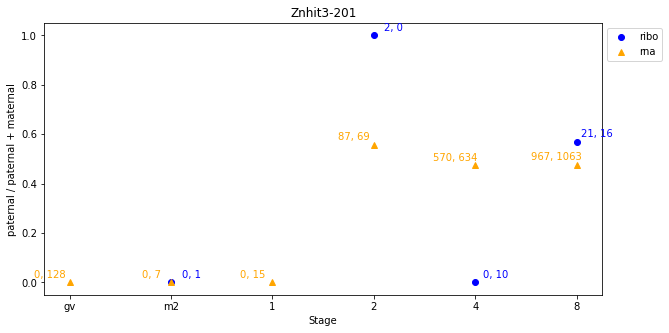

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
13669  Znhit3-201       232   C   G  0  0  0  0
13668  Znhit3-201       226   C   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
13669  Znhit3-201       232   C   G  0  0  0  0
13668  Znhit3-201       226   C   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 2       Mat: 0
       transcript  position REF ALT  A  C  G  T
13669  Znhit3-201       232   C   G  0  0  2  0
13668  Znhit3-201       226   C   T  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
13669  Znhit3-201       232   C   G  0  0  0  0
13668  Znhit3-201       226   C   T  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 2
       transcript  position REF ALT  A  C 

In [151]:
get_details_of_gene("Znhit3-201", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


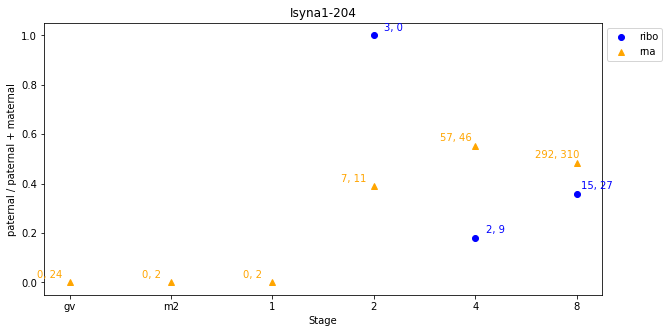

20210513-ITP-2cell-cross-50-B
Pat: 1       Mat: 0
       transcript  position REF ALT  A  C  G  T
76025  Isyna1-204      1405   T   C  0  1  0  0
76026  Isyna1-204      1573   A   G  0  0  0  0
76024  Isyna1-204       883   A   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 2       Mat: 0
       transcript  position REF ALT  A  C  G  T
76025  Isyna1-204      1405   T   C  0  2  0  0
76026  Isyna1-204      1573   A   G  0  0  0  0
76024  Isyna1-204       883   A   T  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
76026  Isyna1-204      1573   A   G  0  0  0  0
76025  Isyna1-204      1405   T   C  0  0  0  0
76024  Isyna1-204       883   A   T  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 1       Mat: 5
       transcript  position REF ALT  A  C  G  T
76025  Isyna1-204      1405   T   C  0  1  0  2
76024  Isyna1-204       883  

In [152]:
get_details_of_gene("Isyna1-204", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


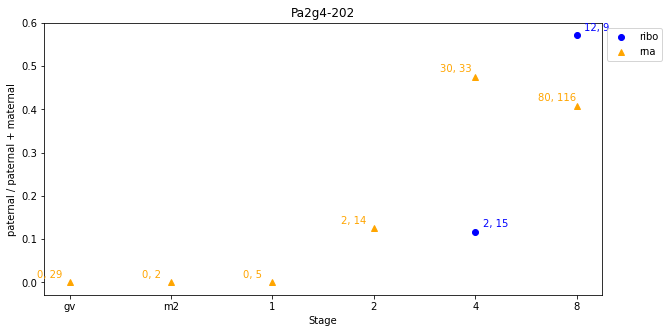

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
4454  Pa2g4-202      1300   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
4454  Pa2g4-202      1300   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
     transcript  position REF ALT  A  C  G  T
4454  Pa2g4-202      1300   T   C  0  0  0  0
--------------------------------
20210513-ITP-4cell-cross-50-B
Pat: 0       Mat: 3
     transcript  position REF ALT  A  C  G  T
4454  Pa2g4-202      1300   T   C  0  0  0  3
--------------------------------
20210513-ITP-4cell-cross-50-C
Pat: 0       Mat: 5
     transcript  position REF ALT  A  C  G  T
4454  Pa2g4-202      1300   T   C  0  0  0  5
--------------------------------
20210513-ITP-4cell-cross-50-D
Pat: 2       Mat: 7
     transcript  position REF ALT  A  C  G  T
4454  Pa2g4-202      1300   T

In [153]:
get_details_of_gene("Pa2g4-202", position_details = True)

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


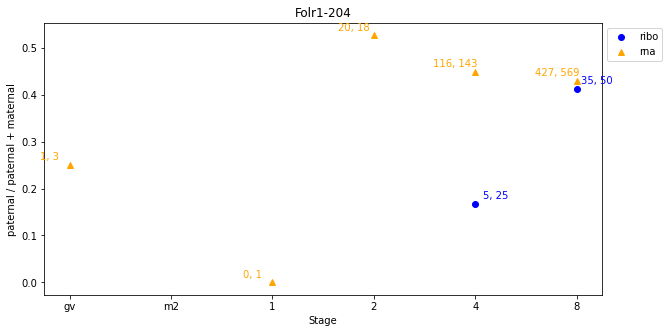

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
71994  Folr1-204      1118   T   C  0  0  0  0
71993  Folr1-204      1039   G   A  0  0  0  0
71992  Folr1-204      1015   T   C  0  0  0  0
71991  Folr1-204       933   A   G  0  0  0  0
71990  Folr1-204       550   C   T  0  0  0  0
71989  Folr1-204       529   A   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
71990  Folr1-204       550   C   T  0  0  0  0
71994  Folr1-204      1118   T   C  0  0  0  0
71993  Folr1-204      1039   G   A  0  0  0  0
71992  Folr1-204      1015   T   C  0  0  0  0
71991  Folr1-204       933   A   G  0  0  0  0
71989  Folr1-204       529   A   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-F
Pat: 0       Mat: 0
      transcript  position REF ALT  A  C  G  T
71994  Folr1-204      1118   T   C  0  0  0  0
71993  Folr1-204      1039   G  

In [154]:
get_details_of_gene("Folr1-204", position_details = True)

### Genes That Differ Significantly at 2 Cell Stage

  * Nup155-201
  * Tpx2-206

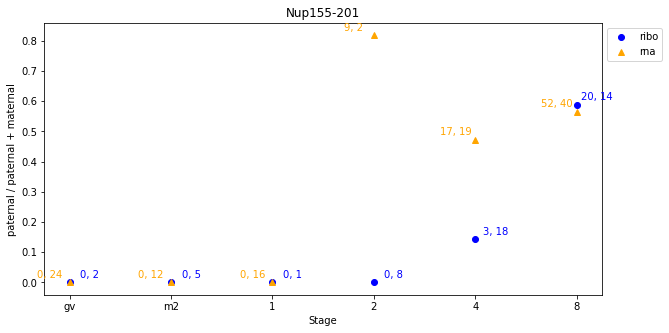

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 7
       transcript  position REF ALT  A  C  G  T
26359  Nup155-201      1223   T   C  0  0  0  2
26368  Nup155-201      3944   G   A  0  0  2  0
26369  Nup155-201      3947   G   A  0  0  2  0
26363  Nup155-201      2945   T   C  0  0  0  1
26357  Nup155-201       527   G   A  0  0  0  0
26370  Nup155-201      4262   A   G  0  0  0  0
26367  Nup155-201      3467   A   G  0  0  0  0
26366  Nup155-201      3170   T   C  0  0  0  0
26365  Nup155-201      3152   C   G  0  0  0  0
26364  Nup155-201      3104   T   C  0  0  0  0
26362  Nup155-201      2315   G   A  0  0  0  0
26361  Nup155-201      1496   T   C  0  0  0  0
26360  Nup155-201      1379   G   C  0  0  0  0
26358  Nup155-201       721   T   C  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 0
       transcript  position REF ALT  A  C  G  T
26369  Nup155-201      3947   G   A  0  0  0  0
26368  Nup155-201      3944   G   A  0  0  0  0
263

In [155]:
get_details_of_gene("Nup155-201", position_details = True)

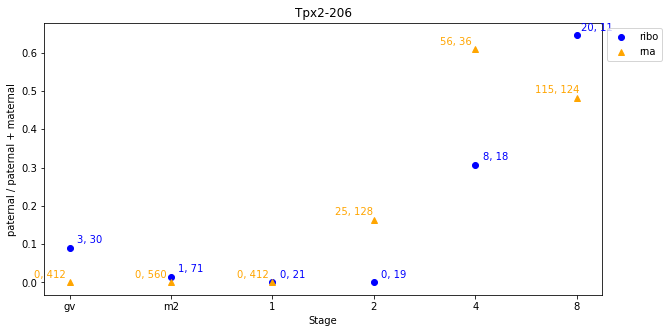

20210513-ITP-2cell-cross-50-B
Pat: 0       Mat: 2
      transcript  position REF ALT  A  C  G  T
46341   Tpx2-206      2702   G   A  0  0  2  0
46340   Tpx2-206      2678   T   C  0  0  0  0
46339   Tpx2-206      2387   C   A  0  0  0  0
46338   Tpx2-206      1754   C   T  0  0  0  0
46337   Tpx2-206      1412   C   T  0  0  0  0
46336   Tpx2-206      1217   C   T  0  0  0  0
46335   Tpx2-206       832   A   G  0  0  0  0
46334   Tpx2-206       653   C   T  0  0  0  0
46333   Tpx2-206       533   C   G  0  0  0  0
--------------------------------
20210513-ITP-2cell-cross-50-C
Pat: 0       Mat: 14
      transcript  position REF ALT  A  C  G  T
46341   Tpx2-206      2702   G   A  0  0  4  0
46339   Tpx2-206      2387   C   A  0  3  0  0
46333   Tpx2-206       533   C   G  0  3  0  0
46334   Tpx2-206       653   C   T  0  2  0  0
46338   Tpx2-206      1754   C   T  0  2  0  0
46340   Tpx2-206      2678   T   C  0  0  0  0
46337   Tpx2-206      1412   C   T  0  0  0  0
46336   Tpx2-206    

In [156]:
get_details_of_gene("Tpx2-206", position_details = True)

# PLOTS OF ALL GENES PASSING PROPTEST


Ddb1-201


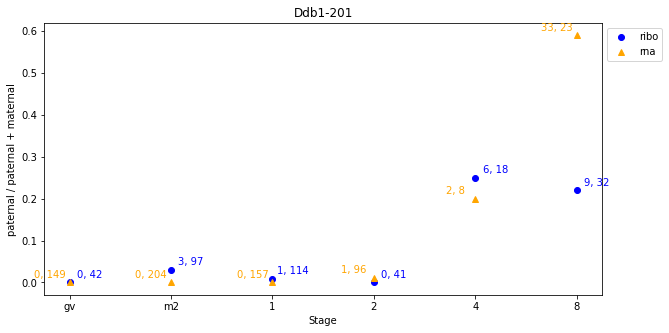

Ncoa3-201


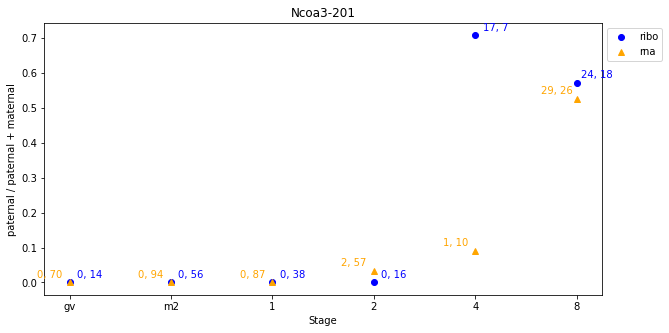

Atp6v0a4-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


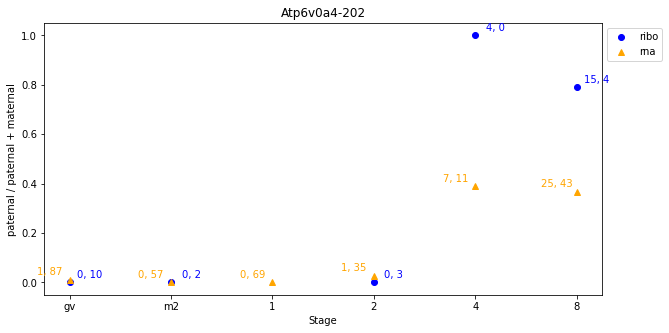

Rps11-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


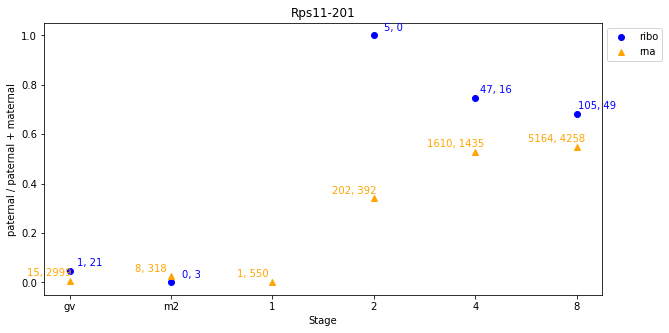

Terf1-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


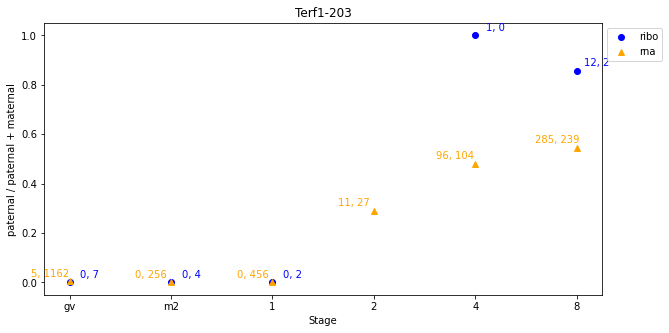

Mysm1-201


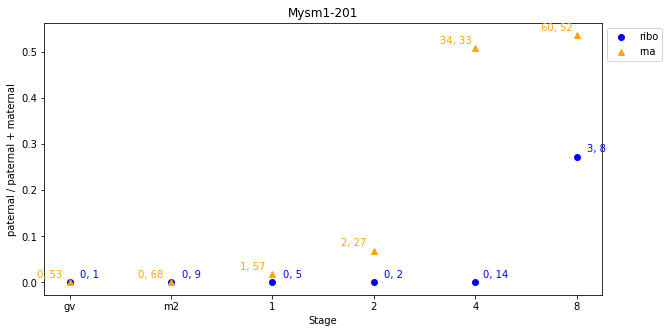

Ccar1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


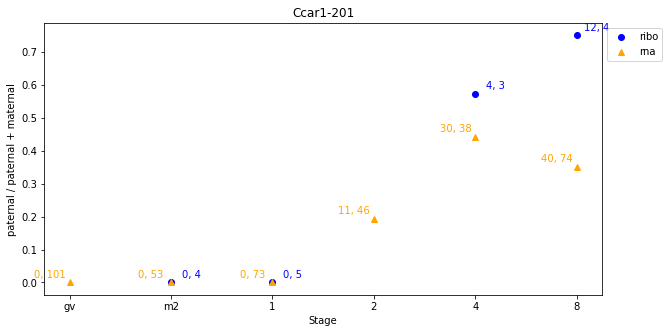

Rnpep-202


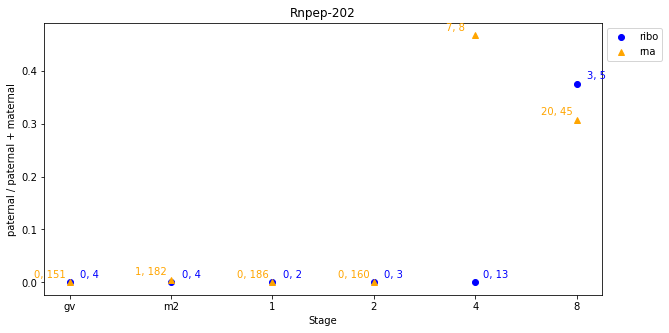

Tprn-201


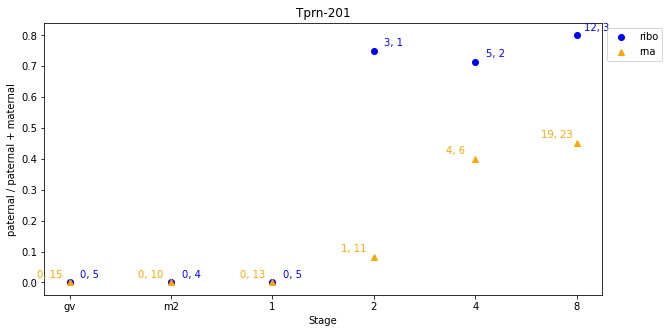

Ctsa-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


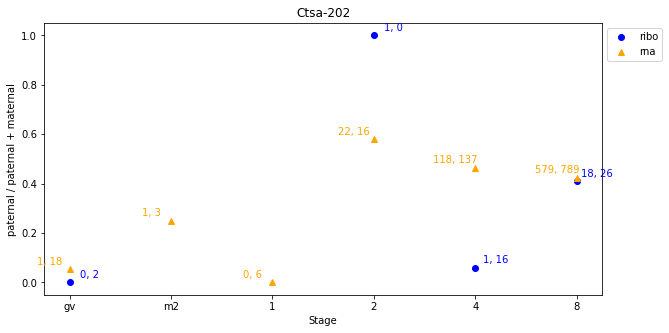

Stip1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


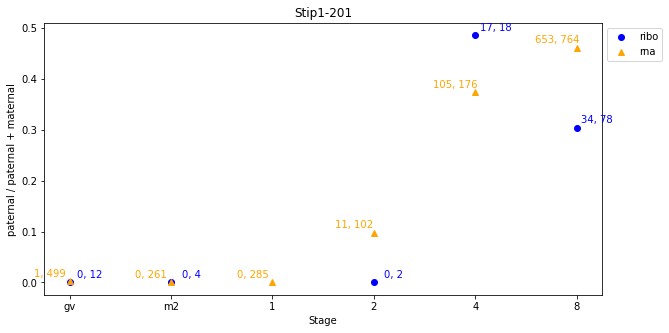

Ccnh-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


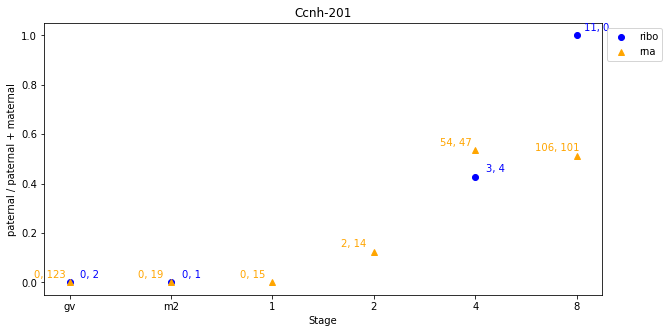

Mrto4-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


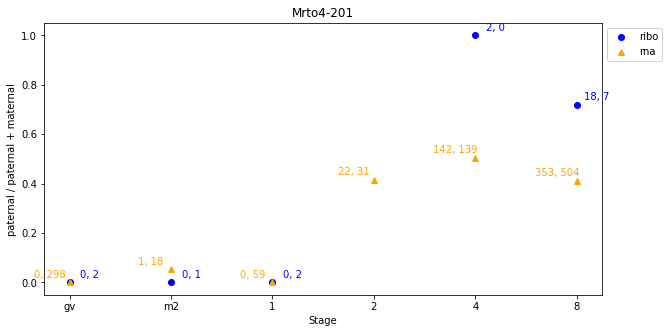

Rpl38-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


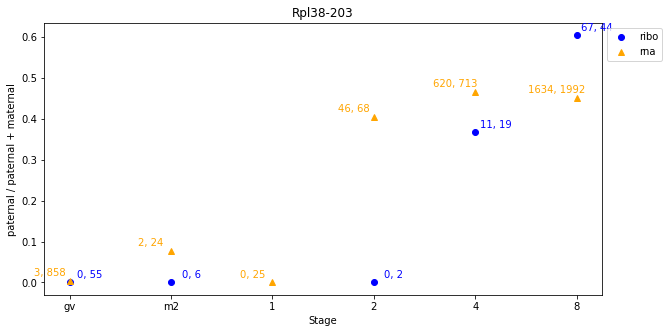

Ddx3x-201


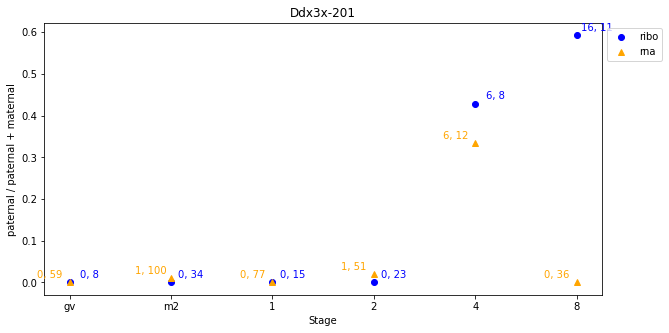

Tpx2-206


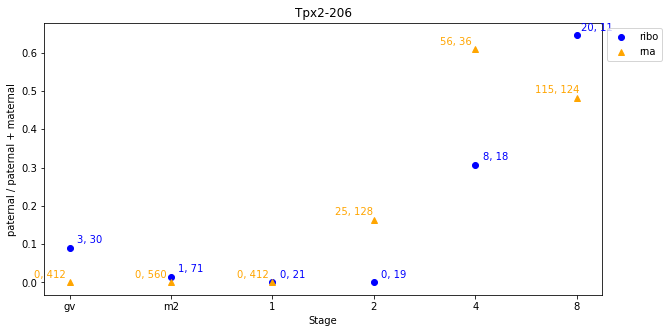

Plk1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


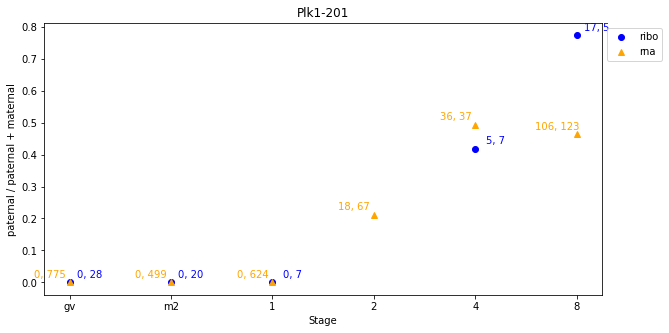

Zfc3h1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


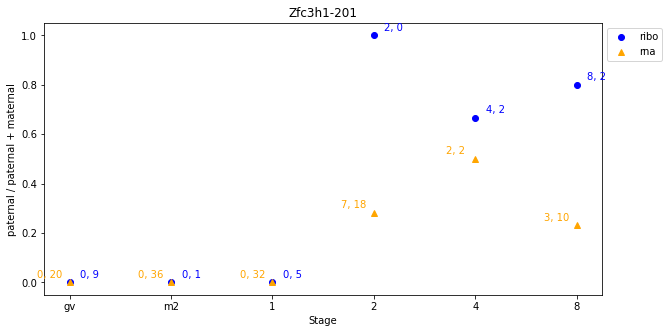

Pa2g4-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


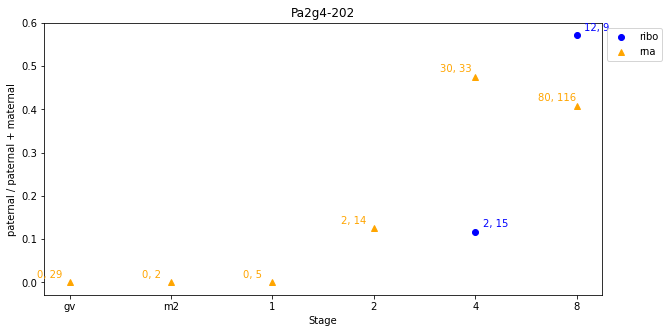

Mrps9-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


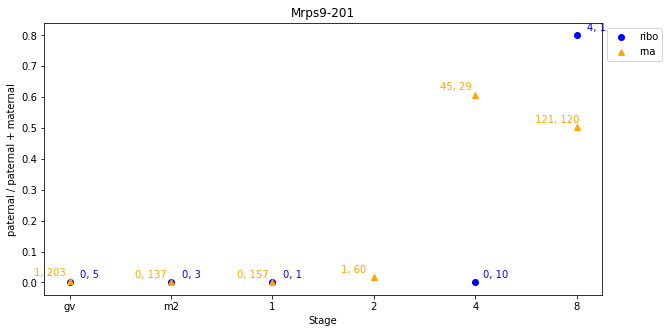

Tsr1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


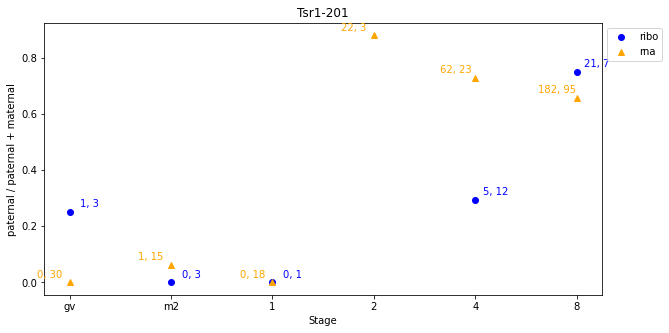

Rps6-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


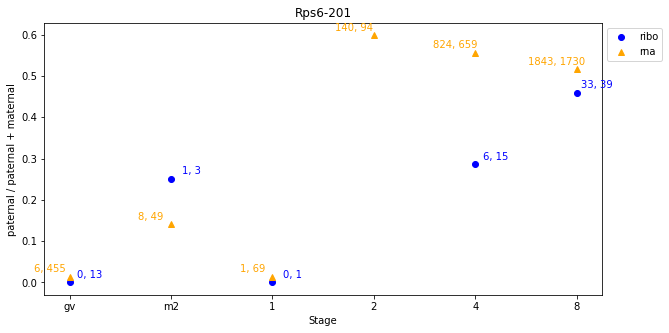

Sgo2a-201


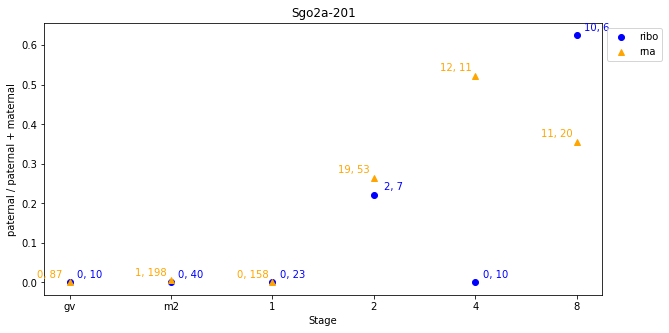

Eif3g-201


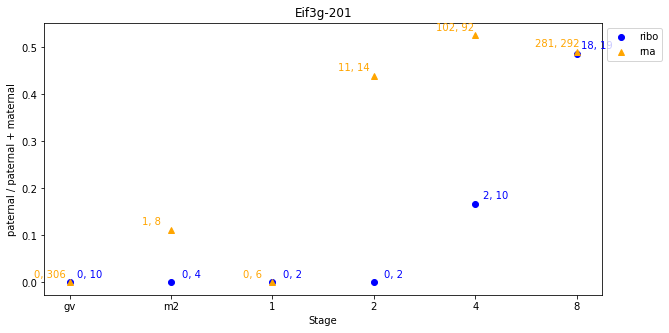

Wdr73-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


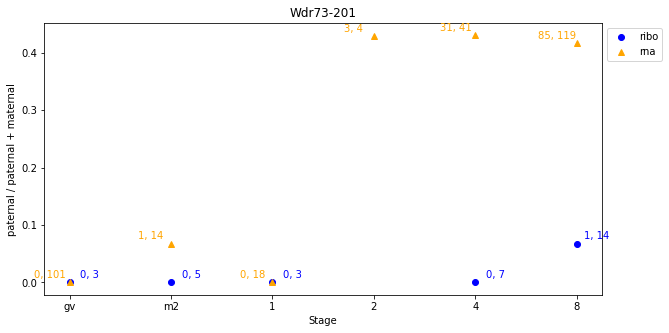

Slc6a8-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


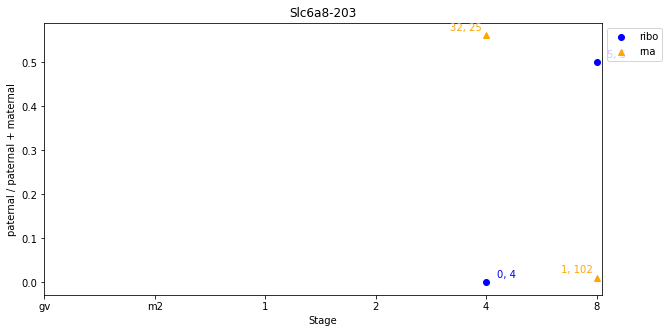

Bcat1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


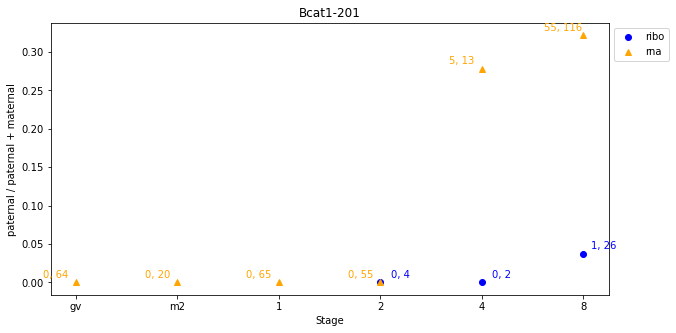

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


Riok2-201


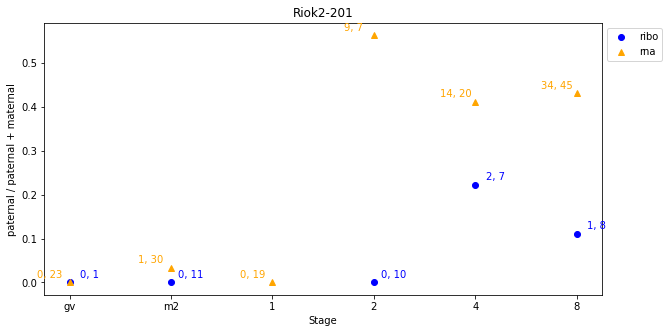

Usp15-211


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


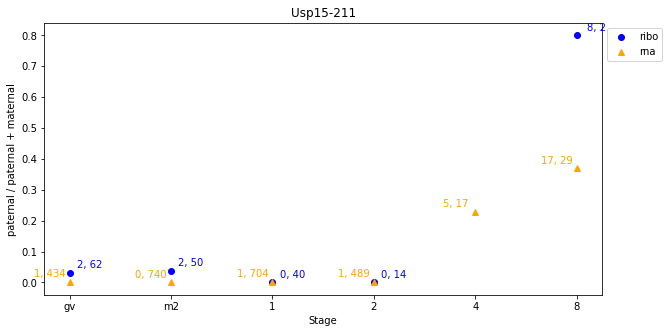

Tsen2-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


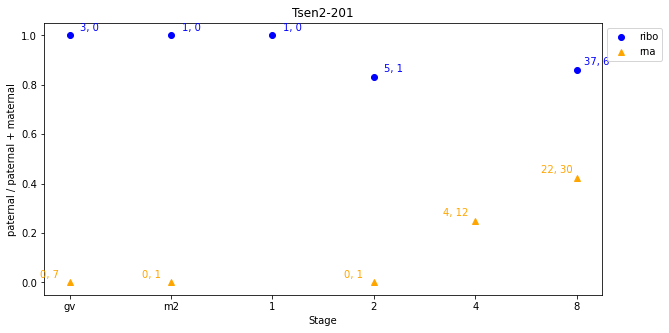

Lclat1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


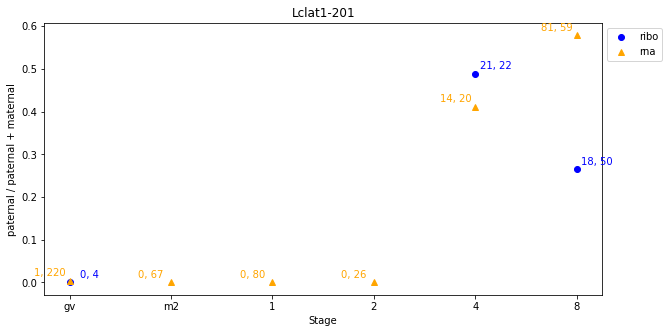

Tnpo3-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


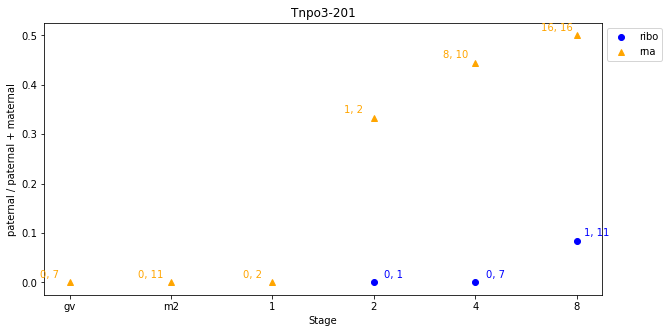

Baz1a-205


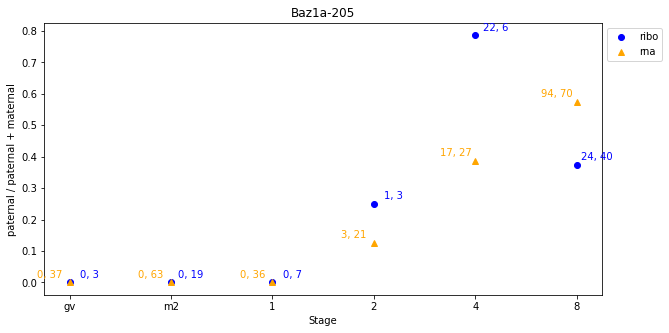

Eef1b2-204


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


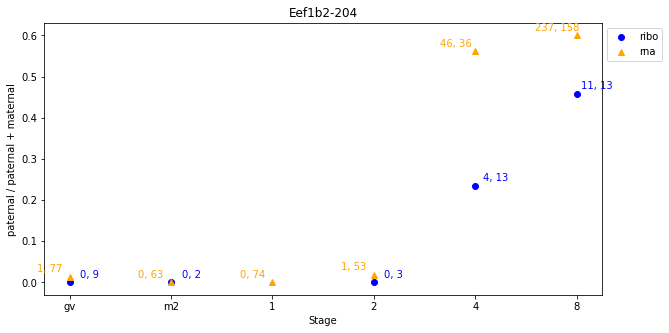

Txlna-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


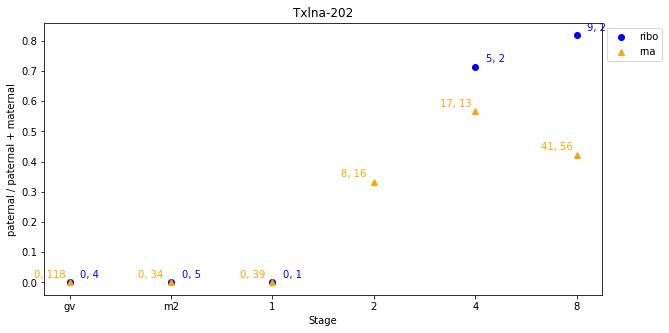

Dctd-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


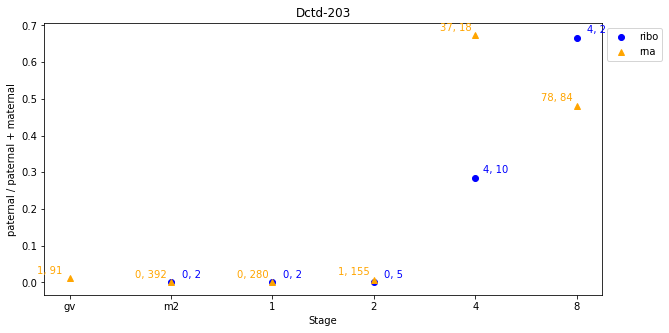

Cct6a-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


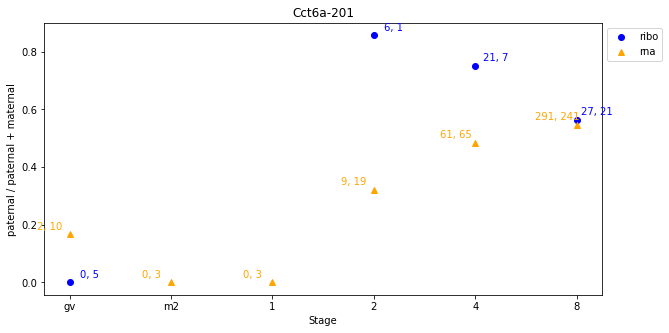

Pemt-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


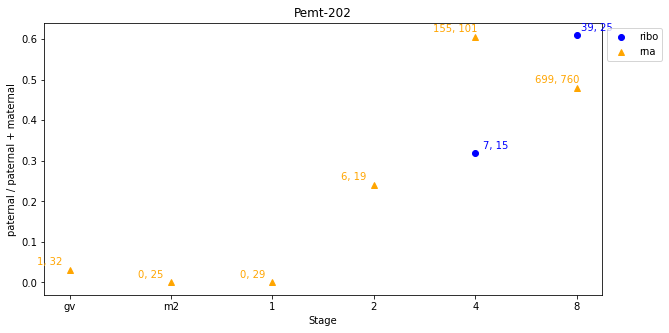

Nup155-201


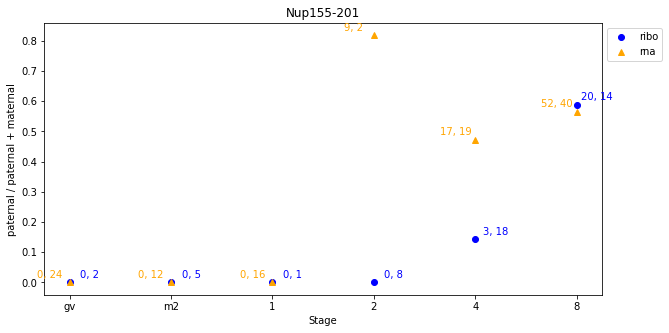

BC055324-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


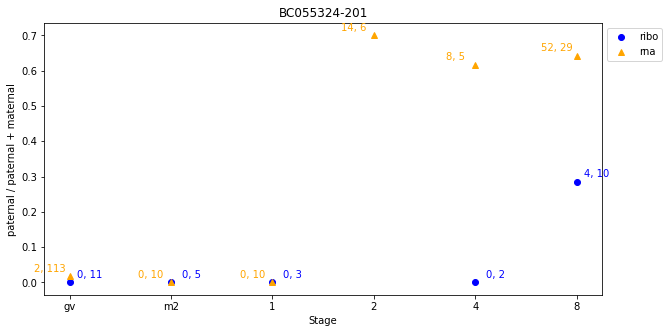

Ulk1-201


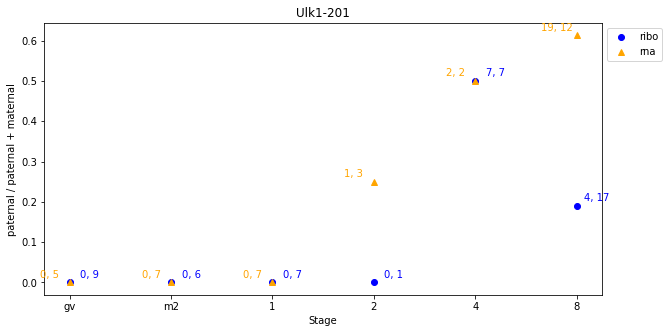

Nin-202


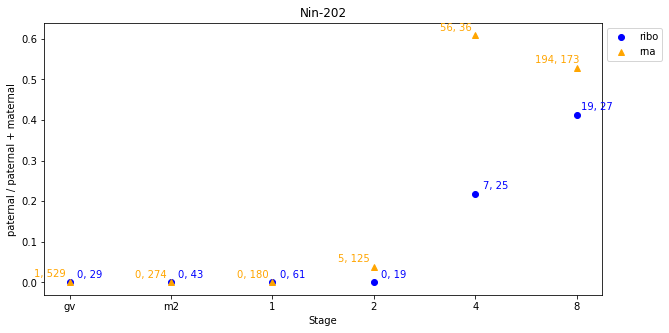

Cdc42-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


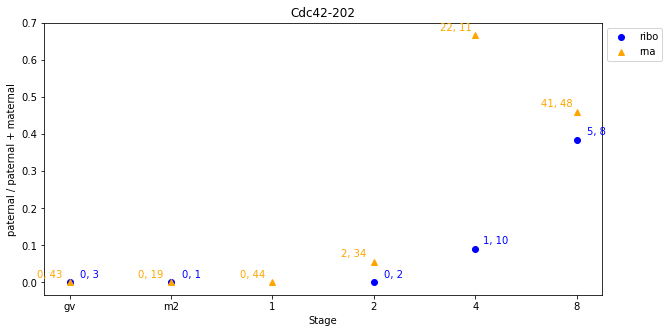

Ccnb1-201


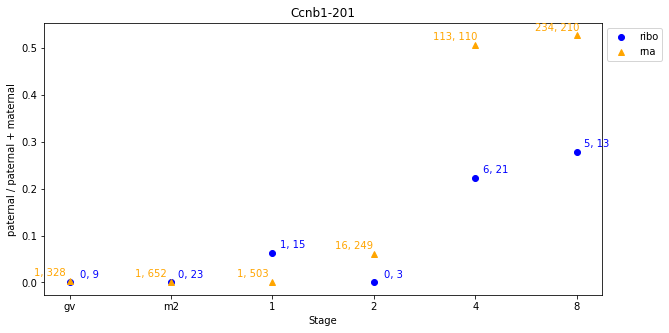

Ppat-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


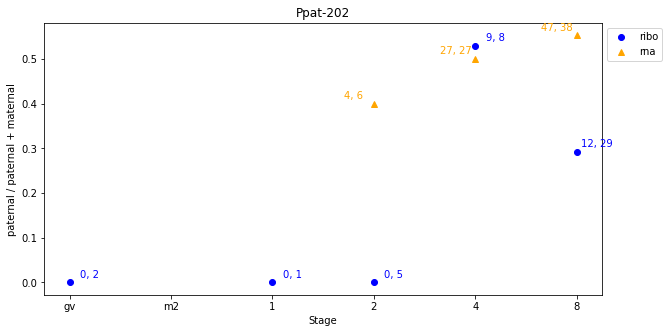

Gtf3c5-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


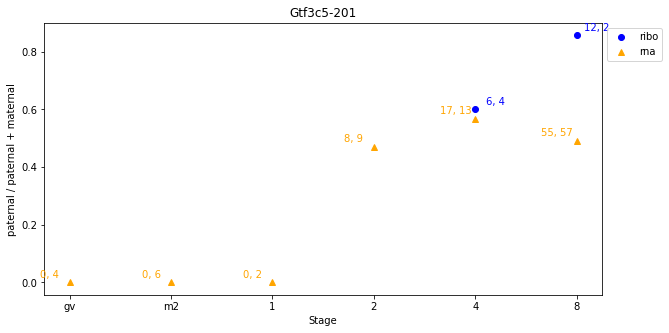

Abhd6-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


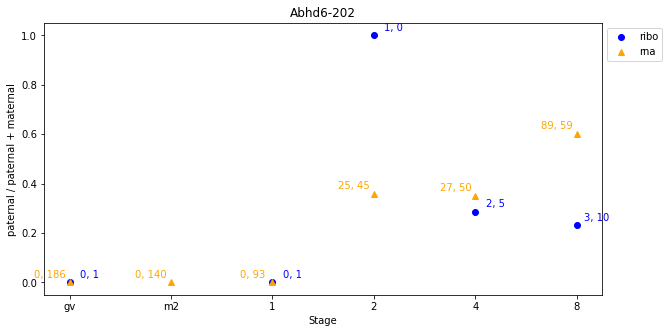

Slc13a2-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


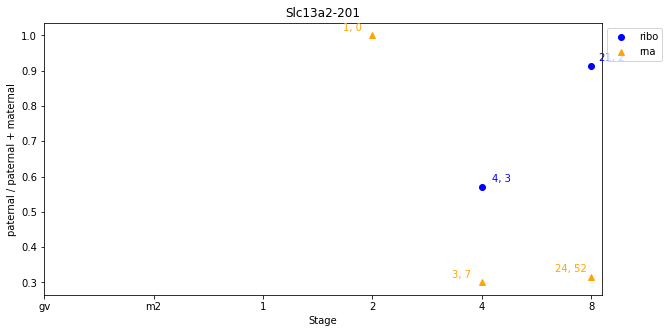

Snrnp70-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


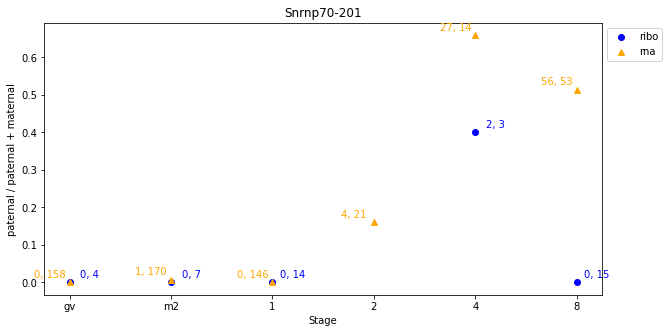

Cdk1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


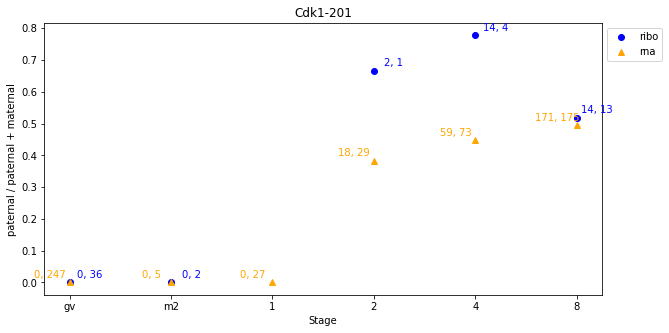

Ankrd10-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


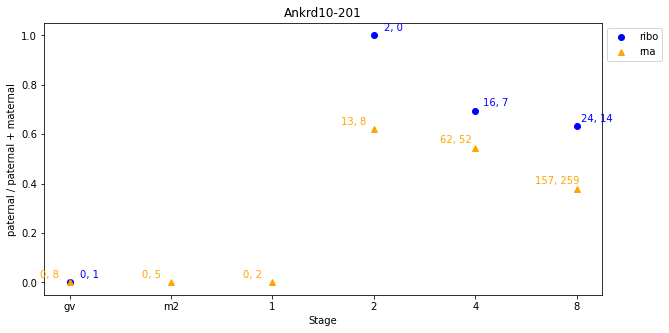

Polr1e-204


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


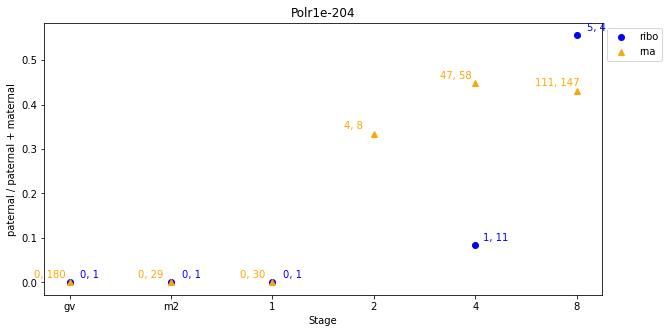

Pgd-201


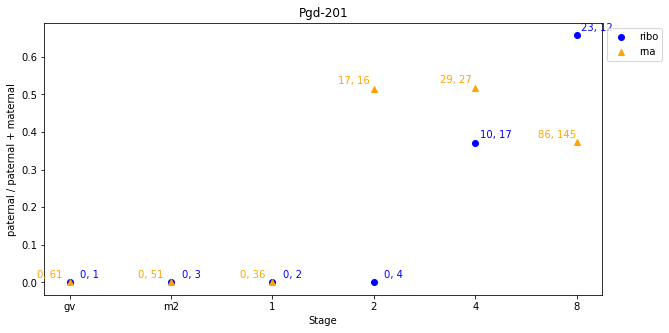

Pkm-201


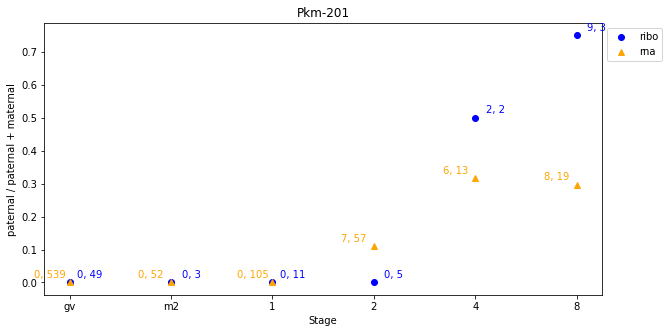

Bmi1-201


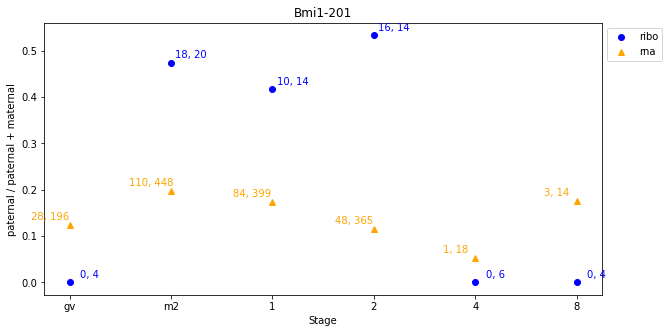

Rpl21-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


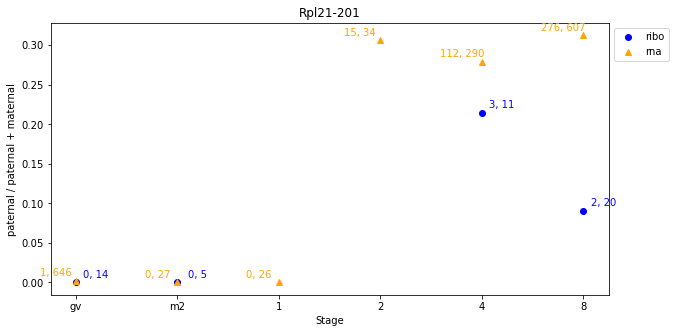

Mcm7-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


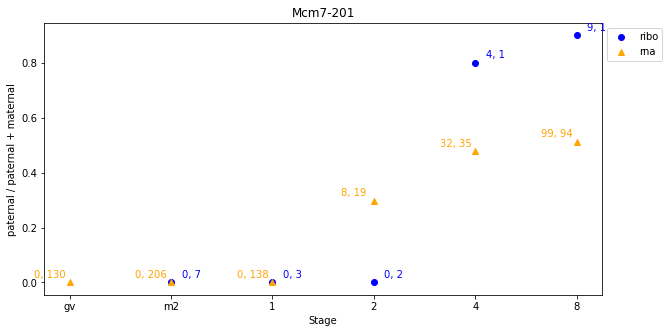

Znrf2-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


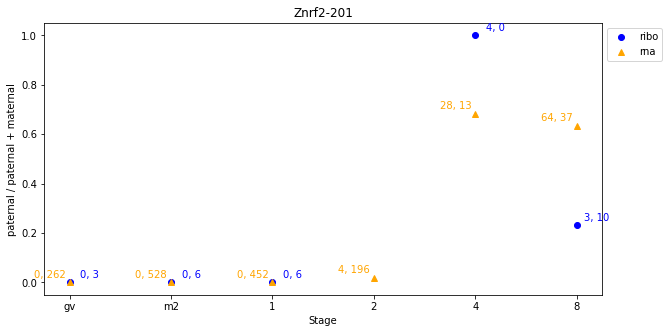

Ccdc47-201


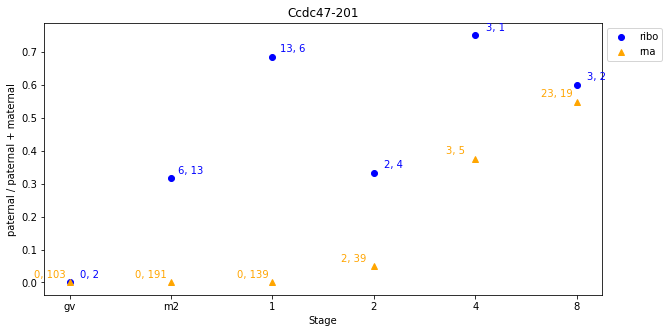

Fbxw16-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


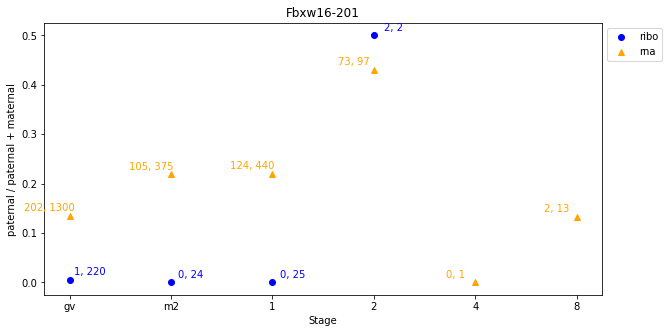

Ddx21-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


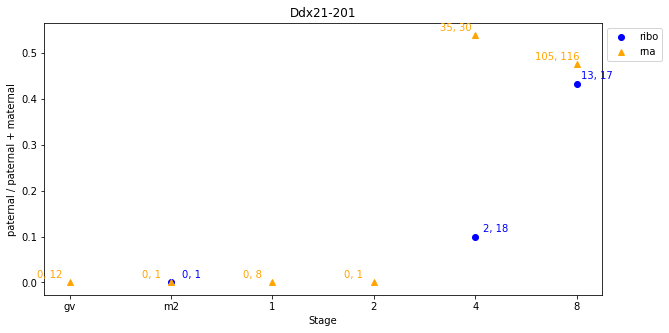

Noc2l-201


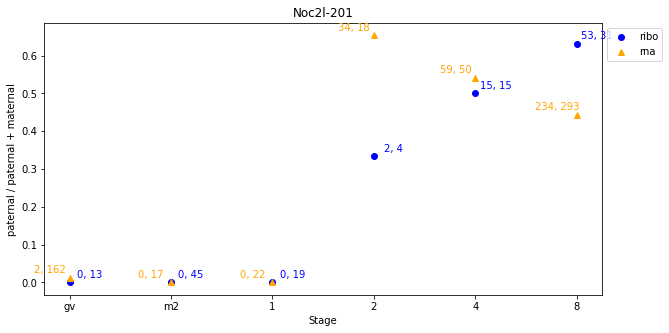

Actr5-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


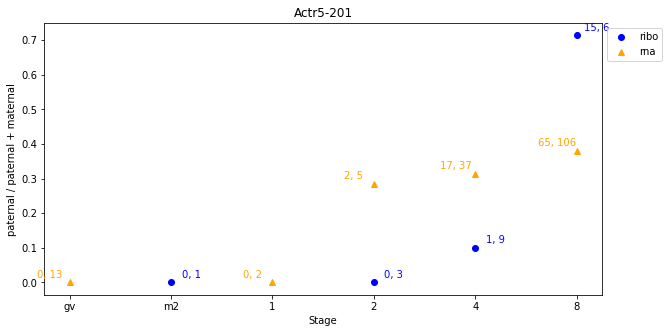

Ddx52-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


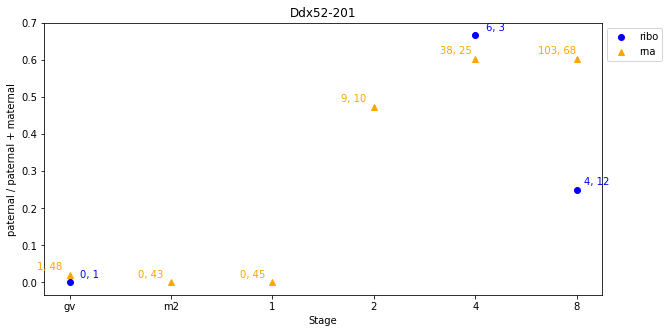

Rpl26-206


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


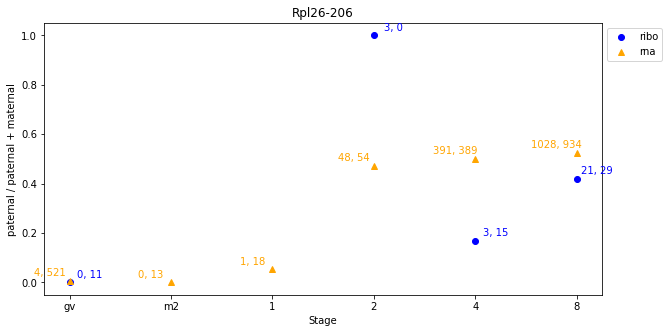

Ltn1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


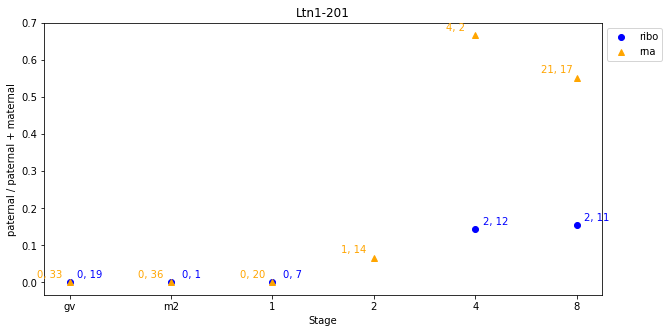

Scaf4-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


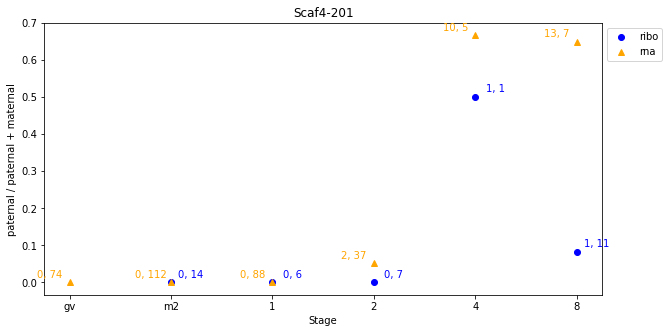

Card6-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


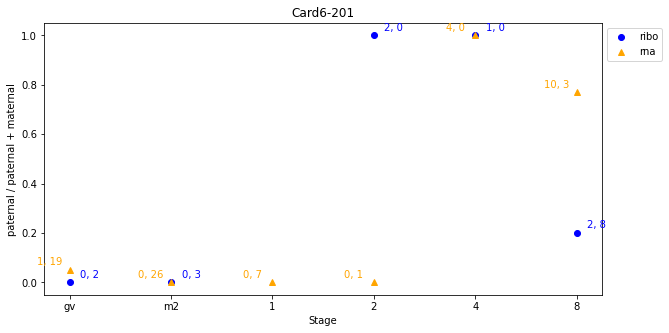

Klhdc4-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


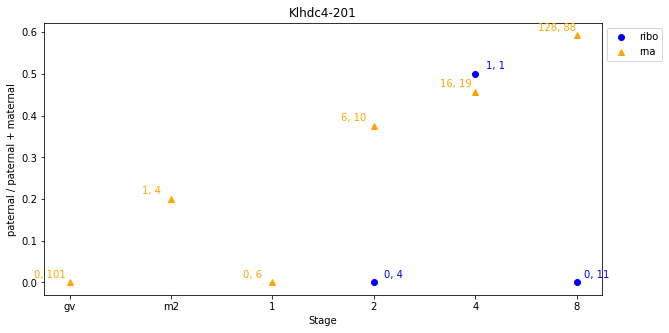

Ppp2ca-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


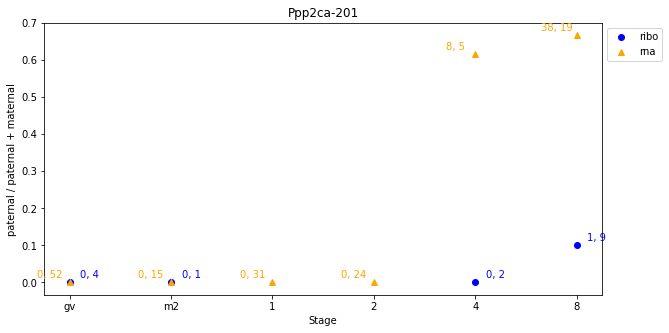

Znhit3-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


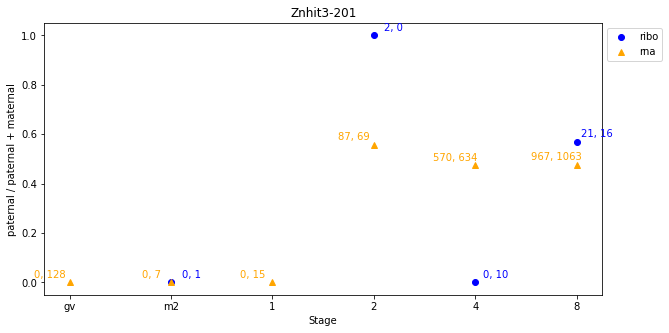

Idh3g-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


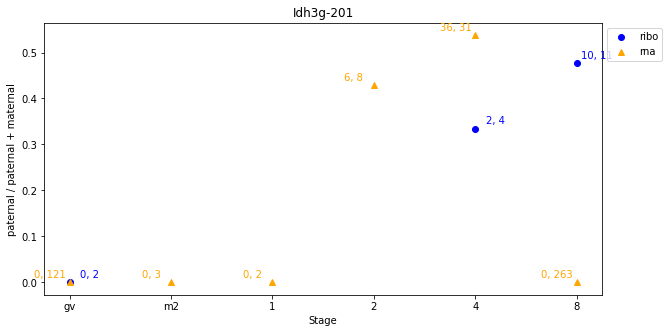

Eprs-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


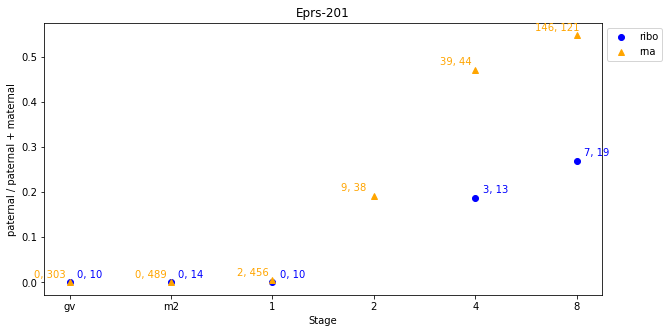

Lyar-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


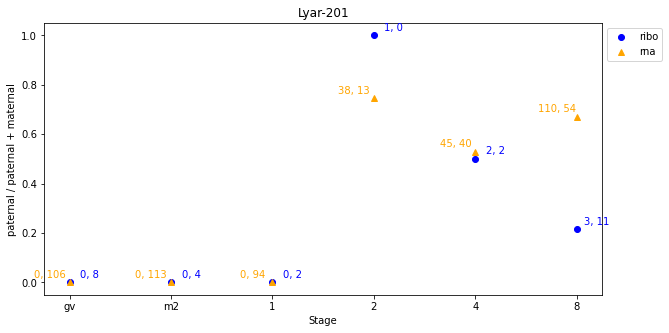

Zfp296-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


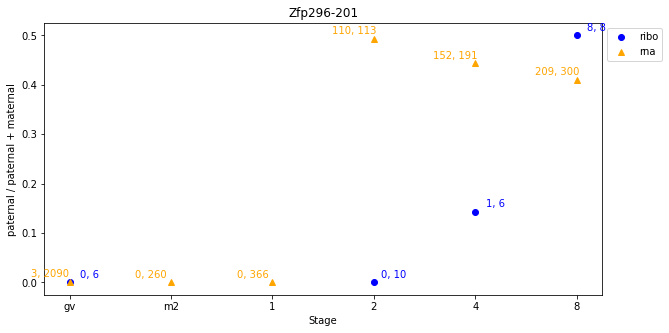

Tgoln1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


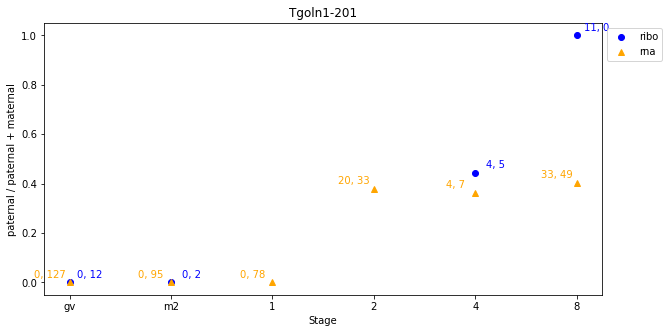

Kdm2b-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


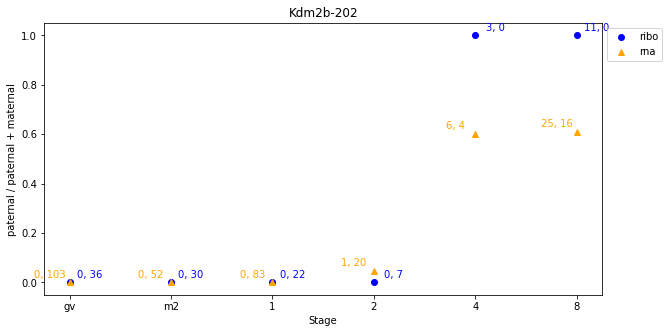

Isyna1-204


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


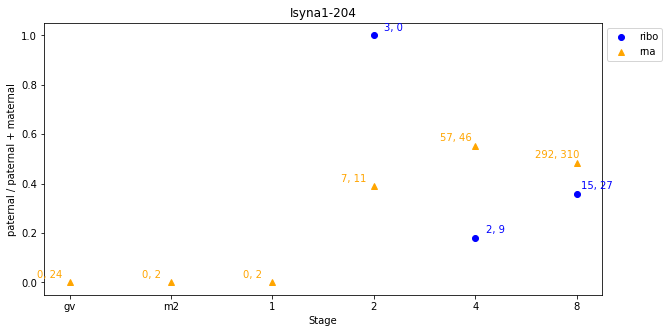

Wtap-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


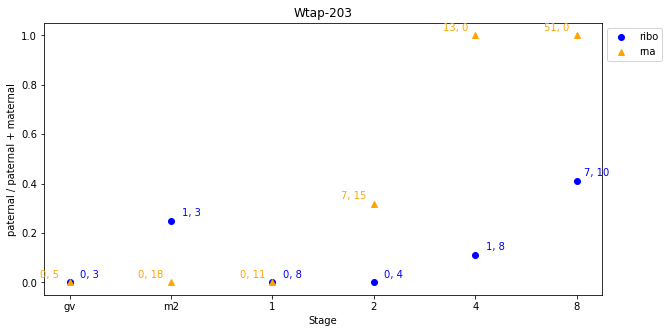

Dnaja2-201


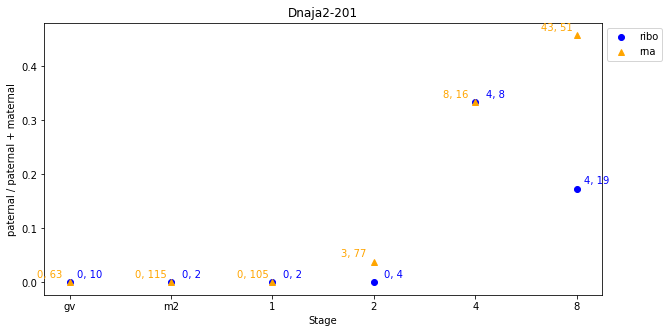

Naalad2-204


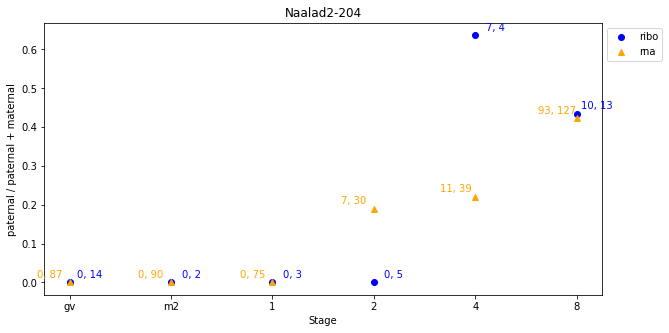

Umps-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


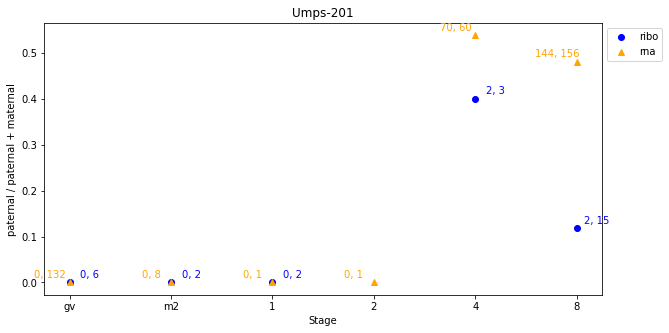

Ctsc-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


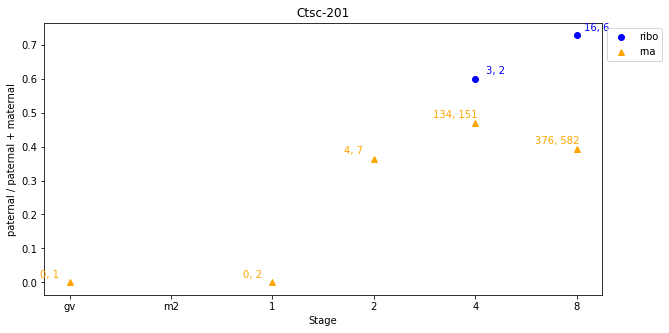

Tmppe-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


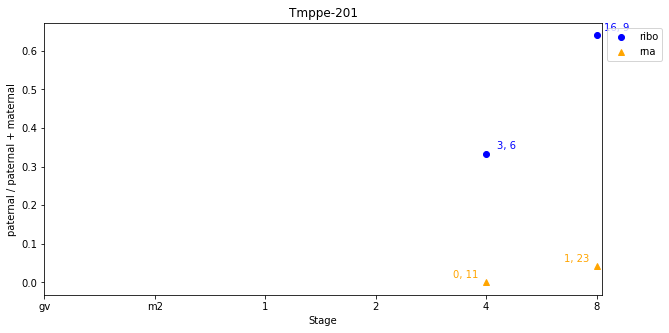

Ralbp1-201


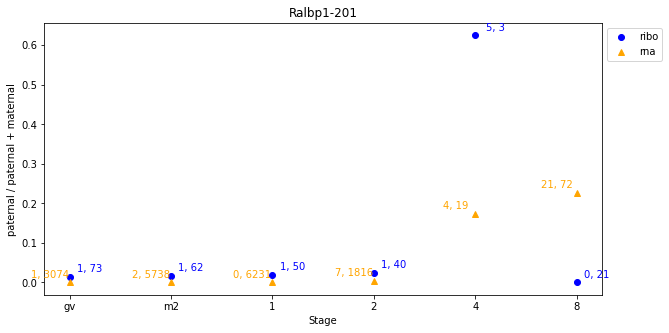

Eif4b-201


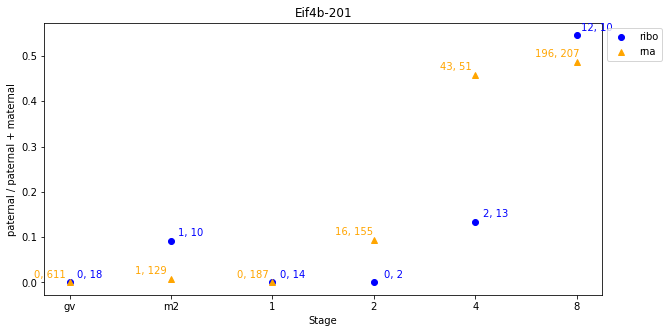

Dnmt1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


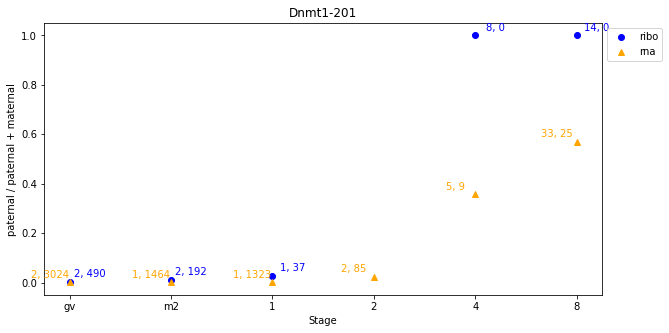

Atg7-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


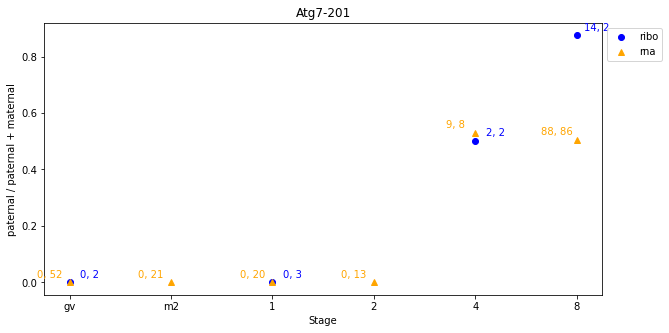

Rpa1-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


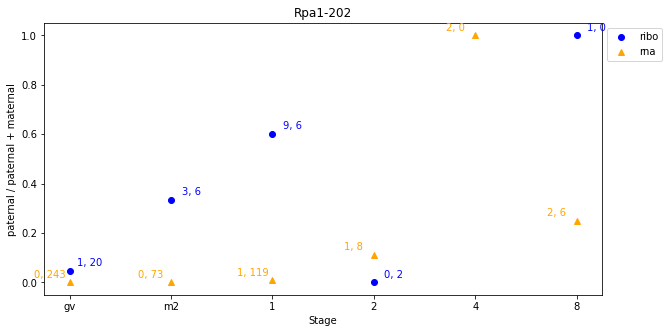

Rps19-203


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


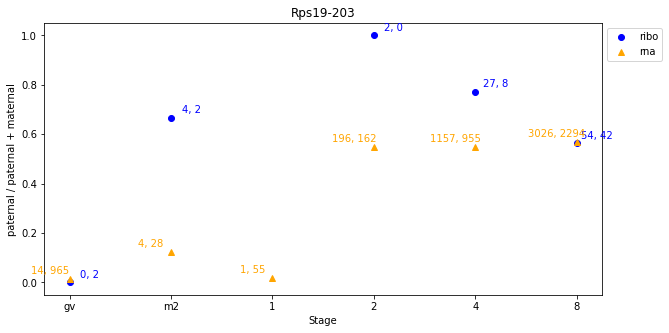

Sdf4-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


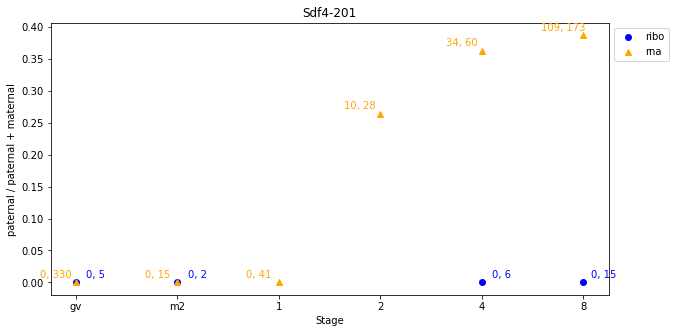

Mtf1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


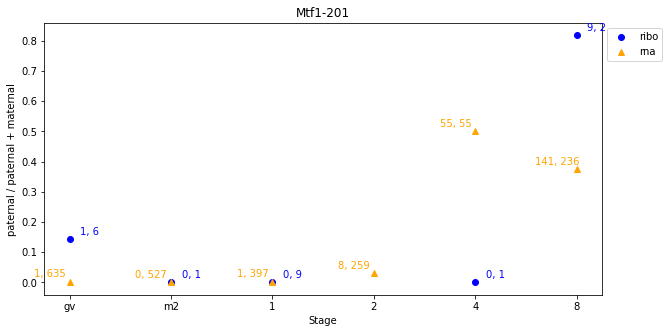

/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


Cth-201


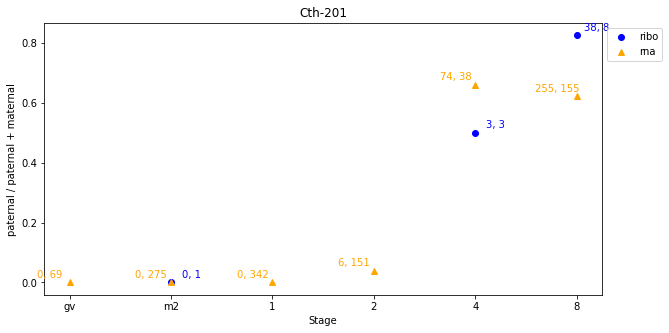

Rpn2-202


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


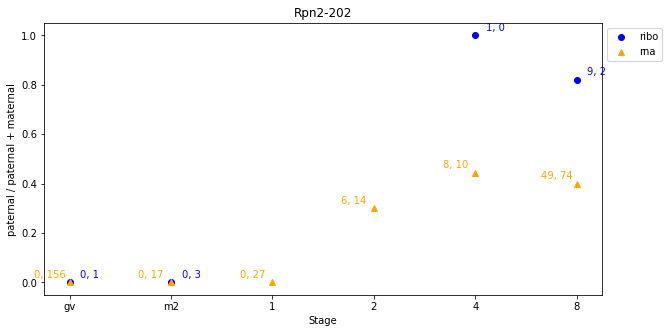

Nop14-201


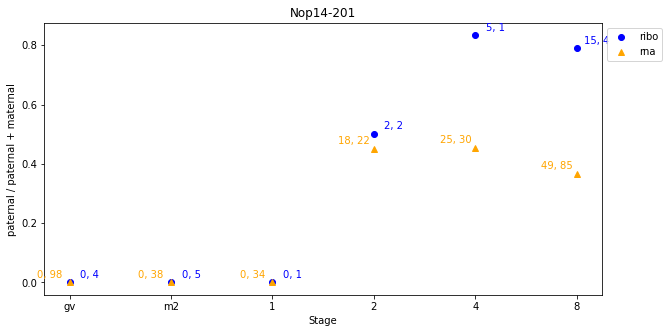

Hnrnpdl-202


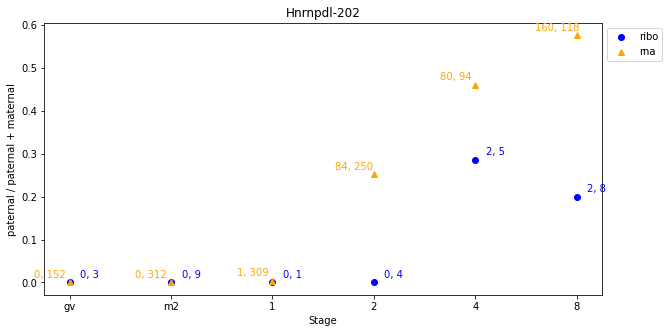

Folr1-204


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


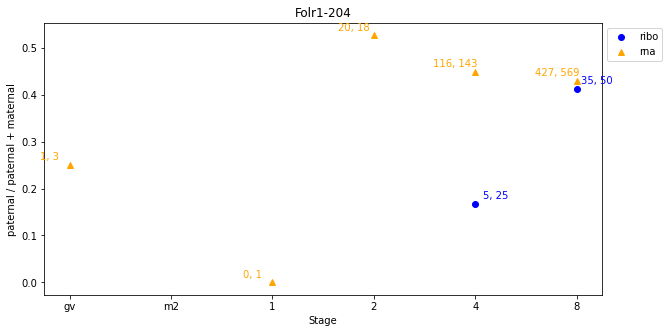

Dyrk3-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


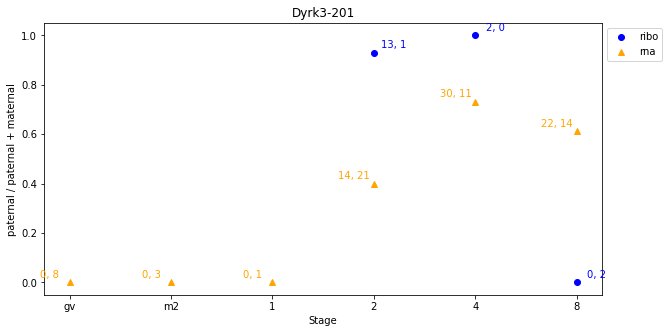

Huwe1-201


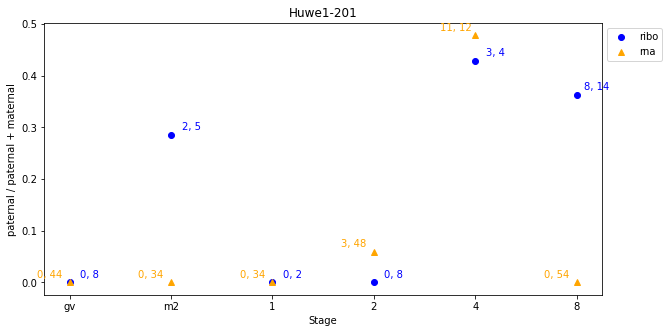

Dnajc21-201


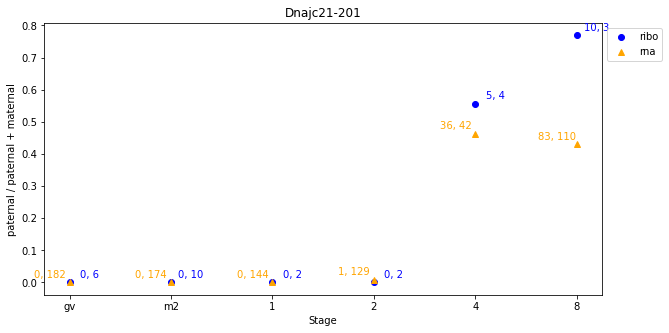

Rpl28-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


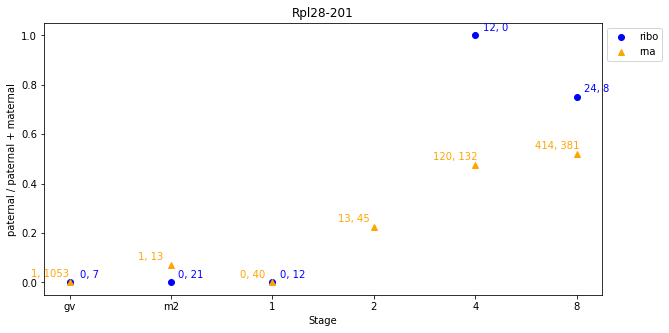

Ppil1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


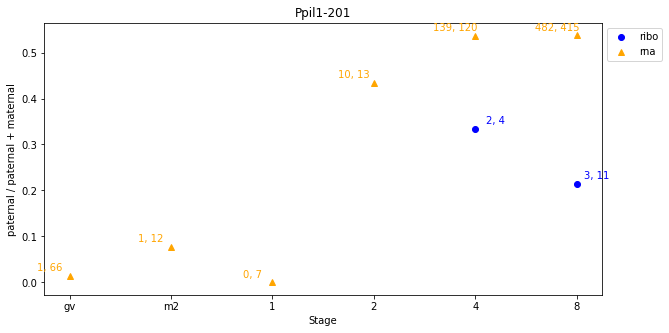

Cbx3-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


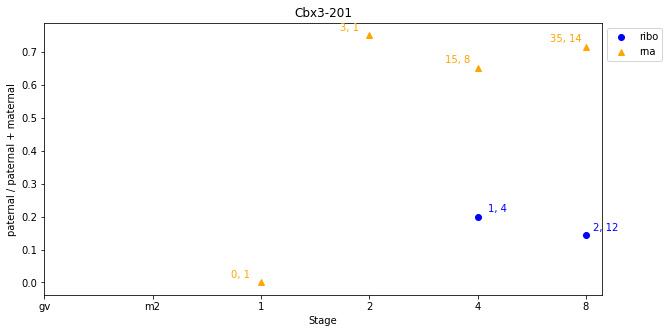

Ltv1-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


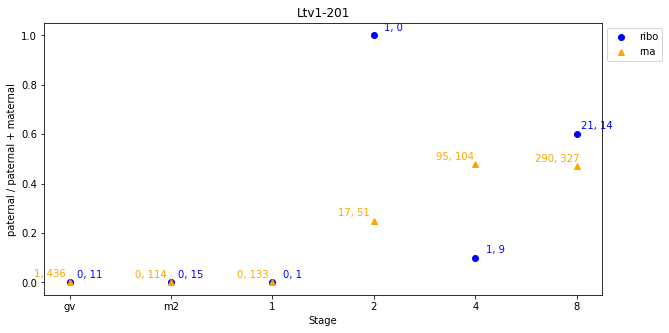

Gmnn-201


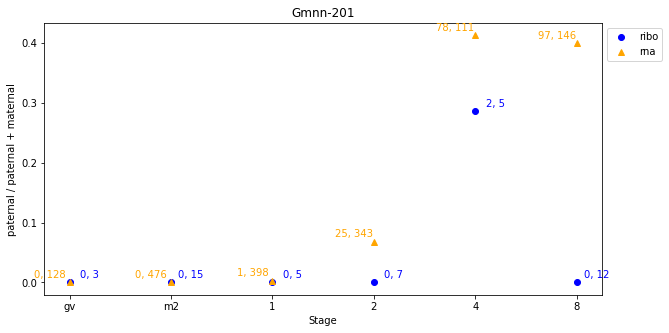

Wdr48-201


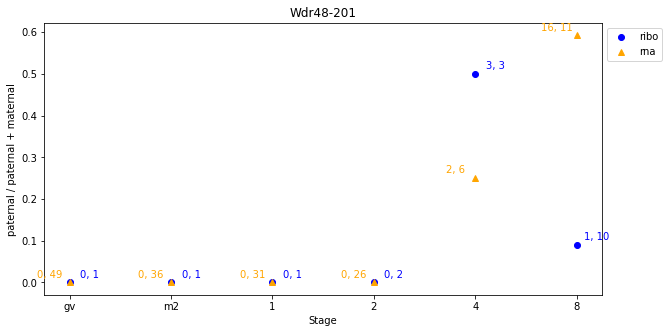

Eif3d-201


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


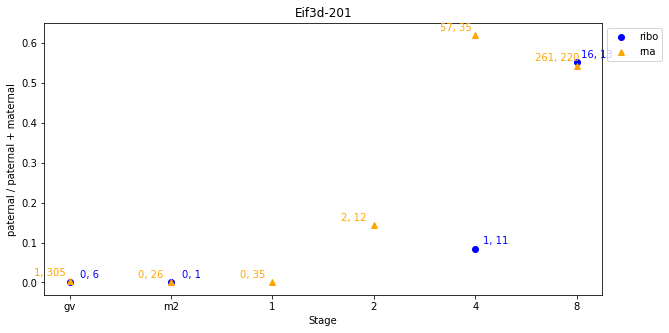

Srpk1-204


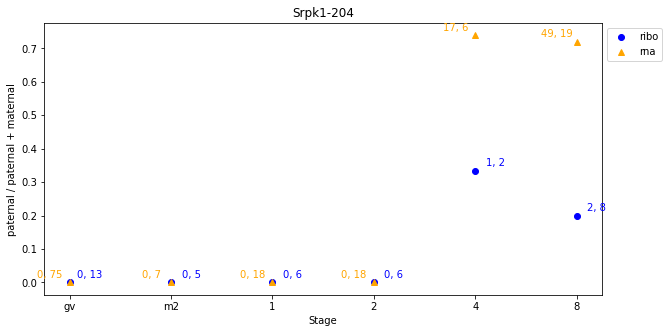

Brca2-201


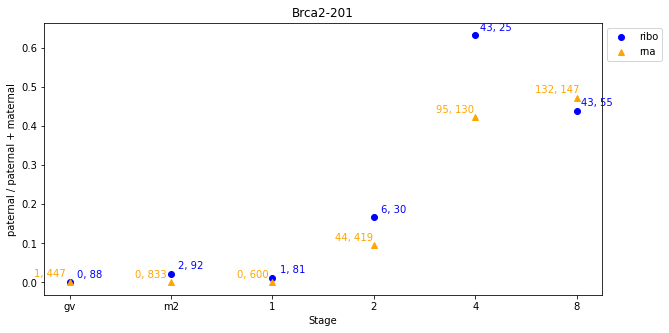

Rtf2-201


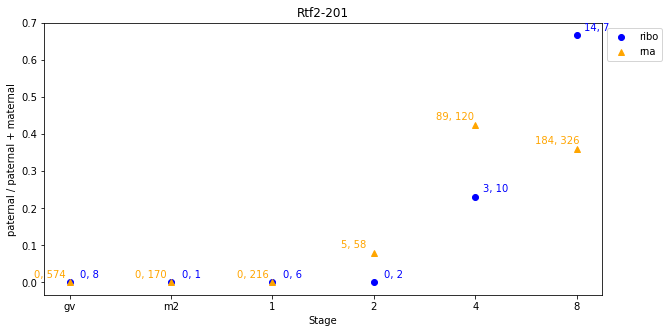

Atp13a3-202


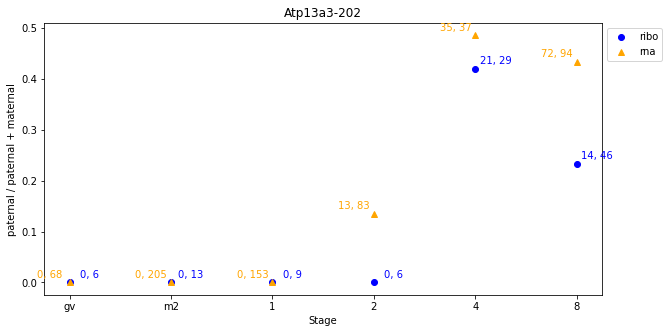

Spdl1-201


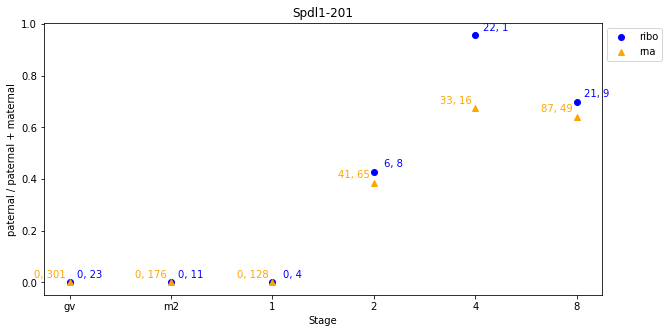

In [159]:
for g in set_of_interesting_genes:
    print(g)
    plot_transcript_ratios(g);